# **<font color='red'>Import libraries</font>**

In [25]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.features import GeoJsonTooltip
from folium.features import GeoJson, GeoJsonTooltip
from sklearn.linear_model import LinearRegression

%matplotlib inline

# **<font color='purple'>Datasets</font>**

## **Creation of a calendar dataframe**

In [2]:
# Calendar dataframe for the whole study period
calendar_df = pd.DataFrame({'date':pd.date_range(start='1/1/1992', end='12/31/2015')})
calendar_df['year'] = calendar_df['date'].dt.year
calendar_df['month'] = calendar_df['date'].dt.month
calendar_df['weekday'] = calendar_df['date'].dt.weekday #Monday=0

calendar_df.head(10)

date  year  month  weekday
0 1992-01-01  1992      1        2
1 1992-01-02  1992      1        3
2 1992-01-03  1992      1        4
3 1992-01-04  1992      1        5
4 1992-01-05  1992      1        6
5 1992-01-06  1992      1        0
6 1992-01-07  1992      1        1
7 1992-01-08  1992      1        2
8 1992-01-09  1992      1        3
9 1992-01-10  1992      1        4

## **Load weather data**

In [3]:
# Climate data
climate = r"C:\Users\m.drexler\Documents\DataScientest\Project\Final ML\weather_data_forest.csv.gz"
cdf = pd.read_csv(climate, compression = 'gzip', index_col = 0)
## Convert 'date' column in datetime64[ns]
cdf['date'] = pd.to_datetime(cdf['date'])
pd.set_option('display.max_columns', None)

cdf.head(10)

PROCLAIMED       date  TAVG_mean  TMAX_mean  TMIN_mean  PRCP_mean  \
365  105935010328 1992-01-01      -5.50   4.766667 -11.533333       0.00   
366  105935010328 1992-01-02      -4.45   5.133333 -10.366667       0.00   
367  105935010328 1992-01-03      -4.25   2.433333  -9.000000      10.40   
368  105935010328 1992-01-04       0.05   5.866667  -3.200000       4.95   
369  105935010328 1992-01-05       0.75   3.300000  -1.200000       9.40   
370  105935010328 1992-01-06      -2.90   1.433333  -4.866667      31.85   
371  105935010328 1992-01-07      -6.30  -2.033333 -12.200000       1.80   
372  105935010328 1992-01-08      -8.15   2.733333 -15.800000       0.00   
373  105935010328 1992-01-09      -4.05   6.500000 -12.466667       0.00   
374  105935010328 1992-01-10      -1.20   8.800000  -7.300000       0.00   

     WSPD_mean  WDIR_mean  TMAX_mean_10D  TMAX_mean_30D  TAVG_mean_10D  \
365        NaN        NaN       4.673333       6.601111         -1.995   
366        NaN        NaN       4.780000       6.661111         -2.480   
367        NaN        NaN       4.750000       6.531111         -2.710   
368        NaN        NaN       4.626667       6.313333         -2.970   
369        NaN        NaN       4.620000       6.257778         -2.765   
370        NaN        NaN       4.180000       5.903333         -2.510   
371        NaN        NaN       3.733333       5.663333         -2.525   
372        NaN        NaN       3.186667       5.261111         -2.980   
373        NaN        NaN       3.086667       4.998889         -3.710   
374        NaN        NaN       3.610000       4.995556         -3.870   

     TAVG_mean_30D  TMIN_mean_10D  TMIN_mean_30D  PRCP_mean_10D  PRCP_mean_30D  
365      -0.766667      -6.493333      -5.263333          1.460       2.298333  
366      -0.768333      -7.200000      -5.150000          1.445       2.298333  
367      -0.773333      -7.586667      -5.061111          1.445       2.298333  
368      -0.870000      -8.136667      -5.086667          2.470       2.645000  
369      -0.893333      -7.793333      -5.051111          2.965       2.733333  
370      -0.883333      -7.143333      -4.946667          3.905       3.046667  
371      -0.963333      -6.980000      -4.938889          7.090       4.108333  
372      -1.183333      -7.693333      -5.173333          7.015       4.168333  
373      -1.536667      -8.656667      -5.623333          6.765       4.168333  
374      -1.738333      -9.293333      -6.016667          5.990       3.701667

## **Load lightnings data**

In [4]:
# Lightning data
lightning = r"C:\Users\m.drexler\Documents\DataScientest\Project\Final ML\light_data_forest.csv.gz"
ldf = pd.read_csv(lightning, compression = 'gzip')
# Convert '#ZDAY' column in datetime64[ns]
ldf['#ZDAY'] = pd.to_datetime(ldf['#ZDAY'], format='%Y-%m-%d')
ldf = ldf.rename(columns={'#ZDAY':'date', 'TOTAL_COUNT':'#lightnings'})
ldf['lightnings'] = 1
pd.set_option('display.max_columns', None)

ldf.head(10)

PROCLAIMED       date  #lightnings  lightnings
0  105935010328 1992-02-23            3           1
1  105935010328 1992-03-06            4           1
2  105935010328 1992-03-07            2           1
3  105935010328 1992-03-08            5           1
4  105935010328 1992-03-17            1           1
5  105935010328 1992-03-21            3           1
6  105935010328 1992-03-23           15           1
7  105935010328 1992-03-24           10           1
8  105935010328 1992-03-26            1           1
9  105935010328 1992-03-27            1           1

## **Load wildfires data**

In [5]:
# Load wildfires data
wildfire = r"C:\Users\m.drexler\Documents\DataScientest\Project\Final ML\wildfires_data_forest.csv.gz"
wdf = pd.read_csv(wildfire, compression = 'gzip')
wdf = wdf.groupby(by=['PROCLAIMED', 'DISCO_DATE']) \
                                .agg({'FOD_ID':'count'}).rename(columns={'FOD_ID':'#wildfires'}).reset_index()
wdf['DISCO_DATE'] = pd.to_datetime(wdf['DISCO_DATE'], format='%Y-%m-%d')
wdf = wdf.rename(columns={'DISCO_DATE':'date'})
pd.set_option('display.max_columns', None)

wdf.head(10)

PROCLAIMED       date  #wildfires
0  66329010328 1992-06-10           1
1  66329010328 1992-06-11           1
2  66329010328 1992-07-03           1
3  66329010328 1992-07-04           3
4  66329010328 1992-07-09           1
5  66329010328 1992-07-10           4
6  66329010328 1992-07-11           1
7  66329010328 1992-07-16           3
8  66329010328 1992-07-17           1
9  66329010328 1992-07-18           3

## **Load forests data**

In [6]:
# Load forests with states
forest = r"C:\Users\m.drexler\Documents\DataScientest\Project\Final ML\us_forests_ext_d100+state.csv.gz"
fdf = pd.read_csv(forest, compression = 'gzip', index_col = 0)
pd.set_option('display.max_columns', None)

fdf.head(10)

PROCLAIMED                    FORESTNAME    GIS_ACRES  SHAPE_AREA  \
0  105935010328        Kaibab National Forest  1601002.978    0.647156   
1  106640010328       Fremont National Forest  1713917.383    0.760518   
2  106887010328     Mt. Baker National Forest  1317676.621    0.648567   
3  107266010328       Olympic National Forest   695868.519    0.337426   
4  107474010328       Wallowa National Forest  1064857.162    0.496222   
5  108201010328     Wenatchee National Forest  1963052.040    0.952602   
6  108625010328    Snoqualmie National Forest  1586107.274    0.761840   
7  109214010328       Whitman National Forest  1311082.638    0.605272   
8  262611010328        Winema National Forest  1094251.130    0.487341   
9  275385010328  Medicine Bow National Forest  1388358.646    0.606667   

   SHAPE_LEN                                           geometry  \
0   9.140002  MULTIPOLYGON (((-112.3946842542064 36.11971353...   
1  11.282002  MULTIPOLYGON (((-120.2196099831526 42.44059945...   
2  10.659633  MULTIPOLYGON (((-121.0182953055546 48.99885961...   
3   8.179740  MULTIPOLYGON (((-123.9516082000847 47.34538681...   
4   9.027734  MULTIPOLYGON (((-117.6943126670689 45.45236765...   
5  15.707300  MULTIPOLYGON (((-119.9742637874386 47.91657788...   
6  15.807654  MULTIPOLYGON (((-121.9723635170876 47.06879656...   
7  18.320346  MULTIPOLYGON (((-117.7238522932269 45.26575740...   
8  14.553148  MULTIPOLYGON (((-122.0879621677362 43.09555862...   
9  10.901328  MULTIPOLYGON (((-106.0464857155588 42.66430673...   

                     STATE  
0                  Arizona  
1        California,Oregon  
2               Washington  
3               Washington  
4  Oregon,Idaho,Washington  
5               Washington  
6               Washington  
7             Oregon,Idaho  
8                   Oregon  
9         Colorado,Wyoming

In [9]:
fdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 154 entries, 0 to 153
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PROCLAIMED  154 non-null    int64  
 1   FORESTNAME  154 non-null    object 
 2   GIS_ACRES   154 non-null    float64
 3   SHAPE_AREA  154 non-null    float64
 4   SHAPE_LEN   154 non-null    float64
 5   geometry    154 non-null    object 
 6   STATE       154 non-null    object 
dtypes: float64(3), int64(1), object(3)
memory usage: 9.6+ KB


# **<font color='darkblue'>Merging datasets</font>**

In [7]:
# Merge calendar with weather data
global_df = pd.merge(calendar_df, cdf, on='date', how='left')

# Add lightning data
global_df = pd.merge(global_df, ldf, on=['date', 'PROCLAIMED'], how='left')

# Add wildfire data
global_df = pd.merge(global_df, wdf, on=['date', 'PROCLAIMED'], how='left')

# Add forest data
global_df = pd.merge(global_df, fdf, on='PROCLAIMED', how='left')

# Show first rows of global dataframe
global_df.head()

date  year  month  weekday    PROCLAIMED  TAVG_mean  TMAX_mean  \
0 1992-01-01  1992      1        2  105935010328    -5.5000   4.766667   
1 1992-01-01  1992      1        2  106640010328    -1.7875   4.925000   
2 1992-01-01  1992      1        2  106887010328    -3.5500   0.533333   
3 1992-01-01  1992      1        2  107266010328     2.8000   5.600000   
4 1992-01-01  1992      1        2  107474010328    -2.6000   1.425000   

   TMIN_mean  PRCP_mean  WSPD_mean  WDIR_mean  TMAX_mean_10D  TMAX_mean_30D  \
0 -11.533333      0.000        NaN        NaN       4.673333       6.601111   
1  -8.075000      0.625        NaN        NaN       4.655000       4.833393   
2  -4.500000      1.250        NaN        NaN       1.276667       0.602222   
3   0.500000      0.000        NaN        NaN       6.108333       5.711667   
4  -5.925000      0.000        NaN        NaN       2.271000       1.503389   

   TAVG_mean_10D  TAVG_mean_30D  TMIN_mean_10D  TMIN_mean_30D  PRCP_mean_10D  \
0       -1.99500      -0.766667      -6.493333      -5.263333           1.46   
1       -0.55625      -1.021310      -4.225000      -5.333690           1.14   
2       -3.03000      -3.920000      -2.836667      -3.885556           1.39   
3        2.69500       1.708333       1.805000       0.693889           5.85   
4       -2.06000      -2.840278      -5.066500      -5.990944           0.25   

   PRCP_mean_30D  #lightnings  lightnings  #wildfires  \
0       2.298333          NaN         NaN         NaN   
1       1.900833          NaN         NaN         NaN   
2       7.930000          NaN         NaN         NaN   
3       6.465000          NaN         NaN         NaN   
4       2.081111          NaN         NaN         NaN   

                  FORESTNAME    GIS_ACRES  SHAPE_AREA  SHAPE_LEN  \
0     Kaibab National Forest  1601002.978    0.647156   9.140002   
1    Fremont National Forest  1713917.383    0.760518  11.282002   
2  Mt. Baker National Forest  1317676.621    0.648567  10.659633   
3    Olympic National Forest   695868.519    0.337426   8.179740   
4    Wallowa National Forest  1064857.162    0.496222   9.027734   

                                            geometry                    STATE  
0  MULTIPOLYGON (((-112.3946842542064 36.11971353...                  Arizona  
1  MULTIPOLYGON (((-120.2196099831526 42.44059945...        California,Oregon  
2  MULTIPOLYGON (((-121.0182953055546 48.99885961...               Washington  
3  MULTIPOLYGON (((-123.9516082000847 47.34538681...               Washington  
4  MULTIPOLYGON (((-117.6943126670689 45.45236765...  Oregon,Idaho,Washington

In [8]:
global_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1263184 entries, 0 to 1263183
Data columns (total 28 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   date           1263184 non-null  datetime64[ns]
 1   year           1263184 non-null  int32         
 2   month          1263184 non-null  int32         
 3   weekday        1263184 non-null  int32         
 4   PROCLAIMED     1263184 non-null  int64         
 5   TAVG_mean      1064985 non-null  float64       
 6   TMAX_mean      1249996 non-null  float64       
 7   TMIN_mean      1249757 non-null  float64       
 8   PRCP_mean      1201148 non-null  float64       
 9   WSPD_mean      179162 non-null   float64       
 10  WDIR_mean      62071 non-null    float64       
 11  TMAX_mean_10D  1244342 non-null  float64       
 12  TMAX_mean_30D  1237549 non-null  float64       
 13  TAVG_mean_10D  1059359 non-null  float64       
 14  TAVG_mean_30D  1049940 non-null  f

# **<font color='lightblue'>Visualization</font>**

In [9]:
# Calculate the total number of wildfires for each forest
forest_fire_count = global_df.groupby('FORESTNAME')['#wildfires'].sum()

# Sort forests based on total number of wildfires and select top 10
top_10_most_affected_forests = forest_fire_count.nlargest(10)

# Display the top 10 forests most impacted by fires
print("Top 10 forests most impacted by fires:")
print(top_10_most_affected_forests)

Top 10 forests most impacted by fires:
FORESTNAME
Coconino National Forest          9105.0
Tonto National Forest             6042.0
Deschutes National Forest         5443.0
Ouachita National Forest          4948.0
Chattahoochee National Forest     4250.0
Mark Twain National Forest        4134.0
Nantahala National Forest         4109.0
Lolo National Forest              4028.0
San Bernardino National Forest    3958.0
Gila National Forest              3926.0
Name: #wildfires, dtype: float64


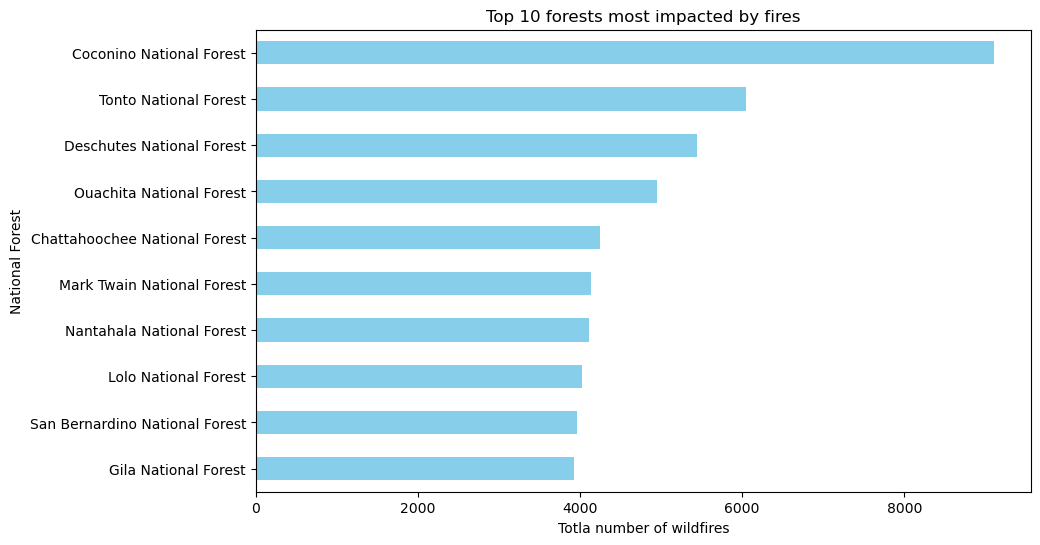

In [10]:
# Create a histogram for the most impacted forest by fires (in terms of total number of event)
plt.figure(figsize=(10, 6))
top_10_most_affected_forests.plot(kind='barh', color='skyblue')
plt.xlabel('Totla number of wildfires')
plt.ylabel('National Forest')
plt.title('Top 10 forests most impacted by fires')
plt.gca().invert_yaxis()
plt.show()

In [11]:
# Count the number of days of fire outbreak for each forest
forest_fire_days_count = global_df.groupby('FORESTNAME')['#wildfires'].count()

# Sort forests based on total number of fire start days and select the first 20
top_20_most_affected_forests = forest_fire_days_count.nlargest(20)

# Display the top 20 forests most impacted by fires in terms of fire start days
print("Top 20 forests most impacted by fires (in terms of fire start days):")
print(top_20_most_affected_forests)

Top 20 forests most impacted by fires (in terms of fire start days):
FORESTNAME
Coconino National Forest          3235
Tonto National Forest             2806
San Bernardino National Forest    2475
Deschutes National Forest         2435
Ouachita National Forest          2393
Angeles National Forest           2126
Chattahoochee National Forest     2043
Nantahala National Forest         1927
De Soto National Forest           1890
Black Hills National Forest       1859
Kaibab National Forest            1806
Santa Fe National Forest          1709
Eldorado National Forest          1658
Cleveland National Forest         1656
Mark Twain National Forest        1647
Sitgreaves National Forest        1633
Coronado National Forest          1630
Lolo National Forest              1622
Gila National Forest              1611
Toiyabe National Forest           1599
Name: #wildfires, dtype: int64


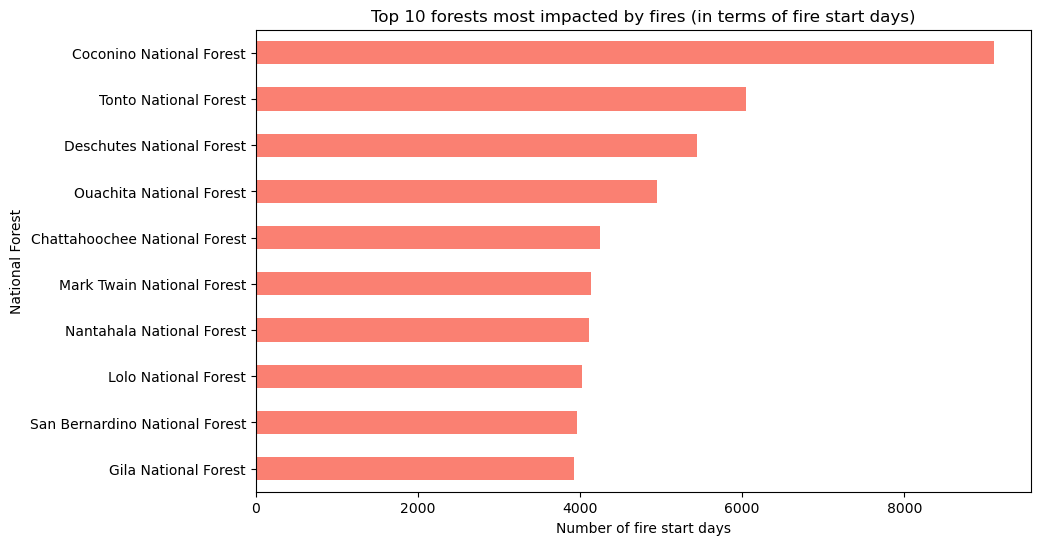

In [12]:
# Create a histogram for the most impacted forest by fires (in terms of fire start days)
plt.figure(figsize=(10, 6))
top_10_most_affected_forests.plot(kind='barh', color='salmon')
plt.xlabel('Number of fire start days')
plt.ylabel('National Forest')
plt.title('Top 10 forests most impacted by fires (in terms of fire start days)')
plt.gca().invert_yaxis()
plt.show()

In [13]:
# Select the ten forests having had the greatest number of days of fire outbreaks
top_10_most_affected_forests = forest_fire_days_count.nlargest(20)

# Retrieve state information ('STATE') for each forest
top_20_forests_states = global_df.loc[global_df['FORESTNAME'].isin(top_10_most_affected_forests.index), ['FORESTNAME', 'STATE']]

# Remove duplicates in forest and state information
top_20_forests_states.drop_duplicates(inplace=True)

# Merge data from the most affected forests with state information
top_20_forests_with_state = pd.merge(top_20_most_affected_forests, top_20_forests_states, left_index=True, right_on='FORESTNAME')

# Reindex the DataFrame to get a better presentation
top_20_forests_with_state.reset_index(drop=True, inplace=True)

# Show table with state information ('STATE')
print("Top 20 forests most impacted by fires (in terms of fire start days) with STATE:")
top_20_forests_with_state

Top 20 forests most impacted by fires (in terms of fire start days) with STATE:


#wildfires                      FORESTNAME  \
0         3235        Coconino National Forest   
1         2806           Tonto National Forest   
2         2475  San Bernardino National Forest   
3         2435       Deschutes National Forest   
4         2393        Ouachita National Forest   
5         2126         Angeles National Forest   
6         2043   Chattahoochee National Forest   
7         1927       Nantahala National Forest   
8         1890         De Soto National Forest   
9         1859     Black Hills National Forest   
10        1806          Kaibab National Forest   
11        1709        Santa Fe National Forest   
12        1658        Eldorado National Forest   
13        1656       Cleveland National Forest   
14        1647      Mark Twain National Forest   
15        1633      Sitgreaves National Forest   
16        1630        Coronado National Forest   
17        1622            Lolo National Forest   
18        1611            Gila National Forest   
19        1599         Toiyabe National Forest   

                                              STATE  
0                                           Arizona  
1                                           Arizona  
2                                        California  
3                                            Oregon  
4                                 Arkansas,Oklahoma  
5                                        California  
6   Georgia,South Carolina,North Carolina,Tennessee  
7   Georgia,South Carolina,North Carolina,Tennessee  
8                                       Mississippi  
9                              Wyoming,South Dakota  
10                                          Arizona  
11                                       New Mexico  
12                                California,Nevada  
13                                       California  
14                                Arkansas,Missouri  
15                                          Arizona  
16                               New Mexico,Arizona  
17                                    Idaho,Montana  
18                               New Mexico,Arizona  
19                                California,Nevada

In [14]:
# Create a choropleth (number of fire start days)

# Count the number of days of fire outbreak for each forest
forest_fire_days_count = global_df.groupby('FORESTNAME')['#wildfires'].count()

# Display the forests most impacted by fires in terms of fire start days
print("Forests most impacted by fires (in terms of fire start days):")
print(forest_fire_days_count)

# Load the GeoDataFrame containing the boundaries of national forests
# Replace 'path_to_your_shapefile' with the actual path to your shapefile
forests_gdf = gpd.read_file(r"C:\Users\m.drexler\Documents\DataScientest\Project\Final ML\forests_shape-20240528T075301Z-001\forests_shape\S_USA.ProclaimedForest.shp")

# Ensure the forest names are matched correctly
forests_gdf['FORESTNAME'] = forests_gdf['FORESTNAME'].str.strip()

# Merge the forest fire data with the GeoDataFrame
forests_gdf = forests_gdf.merge(forest_fire_days_count, on='FORESTNAME', how='left')

# Fill NaN values with 0 (for forests that do not have fire start days in the dataset)
forests_gdf['#wildfires'] = forests_gdf['#wildfires'].fillna(0)

# Create a folium map centered on the US
m = folium.Map(location=[37.0902, -95.7129], zoom_start=5)

# Add the forest fire data as a choropleth layer
choropleth = folium.Choropleth(
    geo_data=forests_gdf,
    name='choropleth',
    data=forests_gdf,
    columns=['FORESTNAME', '#wildfires'],
    key_on='feature.properties.FORESTNAME',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of Fire Start Days'
).add_to(m)

# Add tooltips to display forest names and fire start days
tooltip = GeoJsonTooltip(
    fields=['FORESTNAME', '#wildfires'],
    aliases=['Forest Name:', 'Number of Fire Start Days:']
)

choropleth.geojson.add_child(tooltip)

# Save the map to an HTML file
m.save('forest_fire_choropleth_all_forests.html')

print("Map has been saved to 'forest_fire_choropleth_all_forests.html'")

Forests most impacted by fires (in terms of fire start days):
FORESTNAME
Allegheny National Forest               201
Angeles National Forest                2126
Angelina National Forest                649
Apache National Forest                 1463
Apalachicola National Forest            774
                                       ... 
White River National Forest             835
Whitman National Forest                 977
Willamette National Forest             1153
William B. Bankhead National Forest     382
Winema National Forest                  898
Name: #wildfires, Length: 147, dtype: int64
Map has been saved to 'forest_fire_choropleth_all_forests.html'


In [15]:
# Create a choropleth (number of fire start days - top 10)

# Count the number of days of fire outbreak for each forest
forest_fire_days_count = global_df.groupby('FORESTNAME')['#wildfires'].count()

# Sort forests based on total number of fire start days and select the first 20
top_10_most_affected_forests = forest_fire_days_count.nlargest(20)

# Load the GeoDataFrame containing the boundaries of national forests
# You need to download a shapefile or GeoJSON file with the boundaries of national forests
forests_gdf = gpd.read_file(r"C:\Users\m.drexler\Documents\DataScientest\Project\Final ML\forests_shape-20240528T075301Z-001\forests_shape\S_USA.ProclaimedForest.shp")

# Merge the forest fire data with the GeoDataFrame
forests_gdf = forests_gdf.merge(top_10_most_affected_forests, on='FORESTNAME', how='left')

# Fill NaN values with 0 (for forests that are not in the top 10)
forests_gdf['#wildfires'] = forests_gdf['#wildfires'].fillna(0)

# Create a folium map centered on the US
m = folium.Map(location=[37.0902, -95.7129], zoom_start=5)

# Add the forest fire data as a choropleth layer
choropleth = folium.Choropleth(
    geo_data=forests_gdf,
    name='choropleth',
    data=forests_gdf,
    columns=['FORESTNAME', '#wildfires'],
    key_on='feature.properties.FORESTNAME',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of Fire Start Days'
).add_to(m)

# Add tooltips to display forest names and fire start days
tooltip = GeoJsonTooltip(
    fields=['FORESTNAME', '#wildfires'],
    aliases=['Forest Name:', 'Number of Fire Start Days:']
)

choropleth.geojson.add_child(tooltip)

# Save the map to an HTML file
m.save('forest_fire_choropleth.html')

print("Top 10 forests most impacted by fires (in terms of fire start days):")
print(top_10_most_affected_forests)


Top 10 forests most impacted by fires (in terms of fire start days):
FORESTNAME
Coconino National Forest          3235
Tonto National Forest             2806
San Bernardino National Forest    2475
Deschutes National Forest         2435
Ouachita National Forest          2393
Angeles National Forest           2126
Chattahoochee National Forest     2043
Nantahala National Forest         1927
De Soto National Forest           1890
Black Hills National Forest       1859
Kaibab National Forest            1806
Santa Fe National Forest          1709
Eldorado National Forest          1658
Cleveland National Forest         1656
Mark Twain National Forest        1647
Sitgreaves National Forest        1633
Coronado National Forest          1630
Lolo National Forest              1622
Gila National Forest              1611
Toiyabe National Forest           1599
Name: #wildfires, dtype: int64


In [18]:
# Create a choropleth (fire trend over years)

# Load the shapefile of the forests
forests_gdf = gpd.read_file(r"C:\Users\m.drexler\Documents\DataScientest\Project\Final ML\forests_shape-20240528T075301Z-001\forests_shape\S_USA.ProclaimedForest.shp")

# Add a 'year' column to global_df
global_df['year'] = pd.to_datetime(global_df['date']).dt.year

# Group by forest and year to get the count of wildfires each year
yearly_fires_by_forest = global_df.groupby(['FORESTNAME', 'year'])['#wildfires'].sum().reset_index()

# Get the unique list of forests
forests = yearly_fires_by_forest['FORESTNAME'].unique()

# Dictionary to store the slopes
forest_slopes = {}

# Calculate the slope of wildfires over the years for each forest
for forest in forests:
    forest_data = yearly_fires_by_forest[yearly_fires_by_forest['FORESTNAME'] == forest]
    
    if len(forest_data) < 2:
        continue
    
    X = forest_data['year'].values.reshape(-1, 1)
    y = forest_data['#wildfires'].values
    
    model = LinearRegression()
    model.fit(X, y)
    
    slope = model.coef_[0]
    forest_slopes[forest] = slope

# Convert the dictionary to a DataFrame
slopes_df = pd.DataFrame(list(forest_slopes.items()), columns=['FORESTNAME', 'slope'])

# Merge with the GeoDataFrame
forests_gdf = forests_gdf.merge(slopes_df, left_on='FORESTNAME', right_on='FORESTNAME', how='left')

# Initialize a Folium map
m = folium.Map(location=[37.0902, -95.7129], zoom_start=5)

# Define a color scale
color_scale = folium.LinearColormap(['yellow', 'red'], vmin=slopes_df['slope'].min(), vmax=slopes_df['slope'].max())

# Function to style each feature
def style_function(feature):
    slope = feature['properties']['slope']
    return {
        'fillOpacity': 0.5,
        'weight': 0.5,
        'fillColor': 'gray' if slope is None else color_scale(slope)
    }

# Function to create tooltip
def tooltip_function(feature):
    return folium.Tooltip(f"{feature['properties']['FORESTNAME']}: {feature['properties']['slope']}")

# Add the GeoJson to the map
geojson = GeoJson(
    forests_gdf,
    style_function=style_function,
    tooltip=GeoJsonTooltip(fields=['FORESTNAME', 'slope'])
).add_to(m)

# Add color scale to the map
color_scale.add_to(m)

# Save the map to an HTML file
m.save('forests_fire_trend.html')


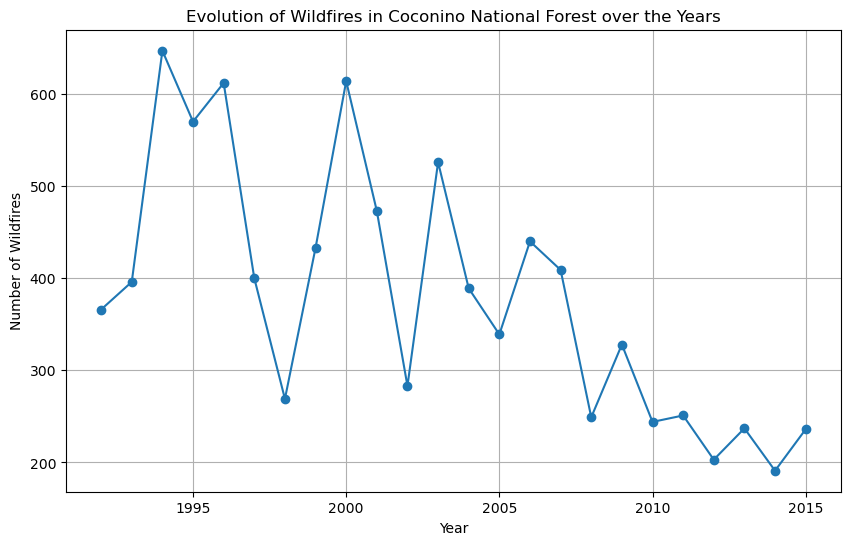

In [19]:
# Display fire trend at Coconino National Forest (test1)

coconino_df = global_df[global_df['FORESTNAME'] == 'Coconino National Forest']

yearly_fire_counts_coconino = coconino_df.groupby('year')['#wildfires'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(yearly_fire_counts_coconino['year'], yearly_fire_counts_coconino['#wildfires'], marker='o')
plt.title('Evolution of Wildfires in Coconino National Forest over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Wildfires')
plt.grid(True)
plt.show()

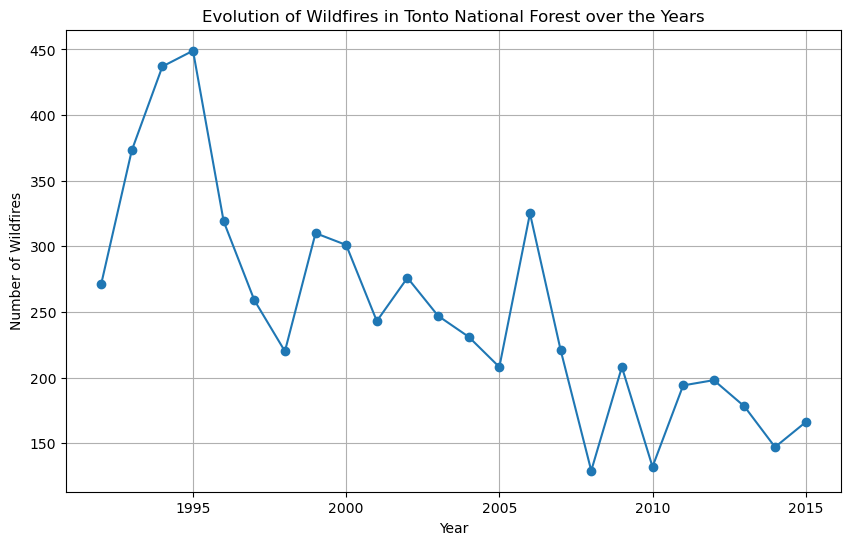

In [20]:
# Display fire trend at Coconino National Forest (test2)

coconino_df = global_df[global_df['FORESTNAME'] == 'Tonto National Forest']

yearly_fire_counts_coconino = coconino_df.groupby('year')['#wildfires'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(yearly_fire_counts_coconino['year'], yearly_fire_counts_coconino['#wildfires'], marker='o')
plt.title('Evolution of Wildfires in Tonto National Forest over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Wildfires')
plt.grid(True)
plt.show()

Forests with an increasing number of wildfires over time:
Wayne National Forest: slope = 2.46
Manistee National Forest: slope = 2.08
Mt. Hood National Forest: slope = 1.60
Carson National Forest: slope = 1.28
Huron National Forest: slope = 0.95
Ocala National Forest: slope = 0.87
Uwharrie National Forest: slope = 0.77
Deerlodge National Forest: slope = 0.73
Davy Crockett National Forest: slope = 0.72
Angelina National Forest: slope = 0.71
San Juan National Forest: slope = 0.64
Mt. Baker National Forest: slope = 0.63
Colville National Forest: slope = 0.62
Sabine National Forest: slope = 0.62
Tahoe National Forest: slope = 0.59
Daniel Boone National Forest: slope = 0.56
Sam Houston National Forest: slope = 0.43
Conecuh National Forest: slope = 0.43
Hiawatha National Forest: slope = 0.42
Shawnee National Forest: slope = 0.40
Cache National Forest: slope = 0.38
Allegheny National Forest: slope = 0.32
Green Mountain National Forest: slope = 0.26
Ottawa National Forest: slope = 0.26
El Yunqu

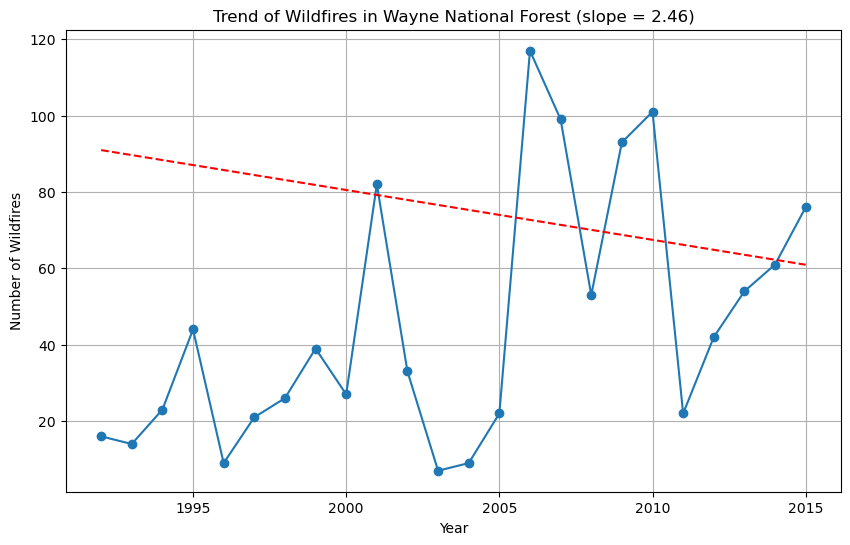

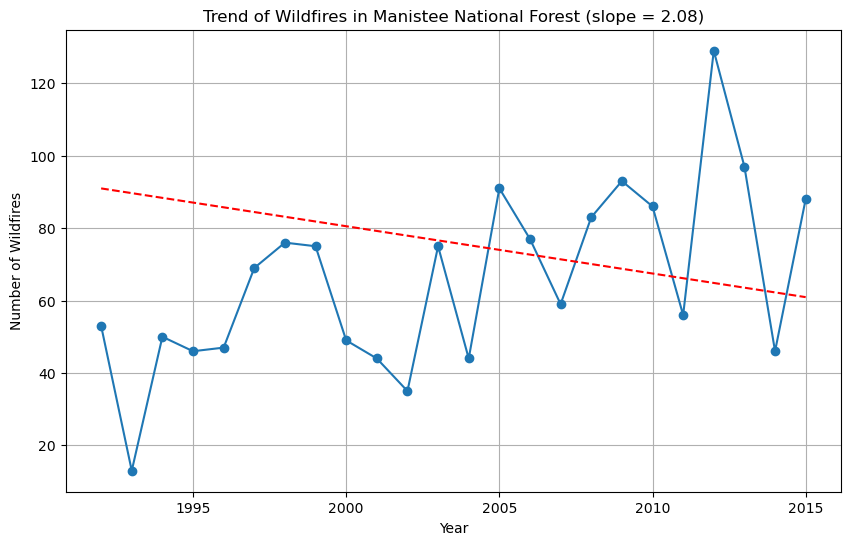

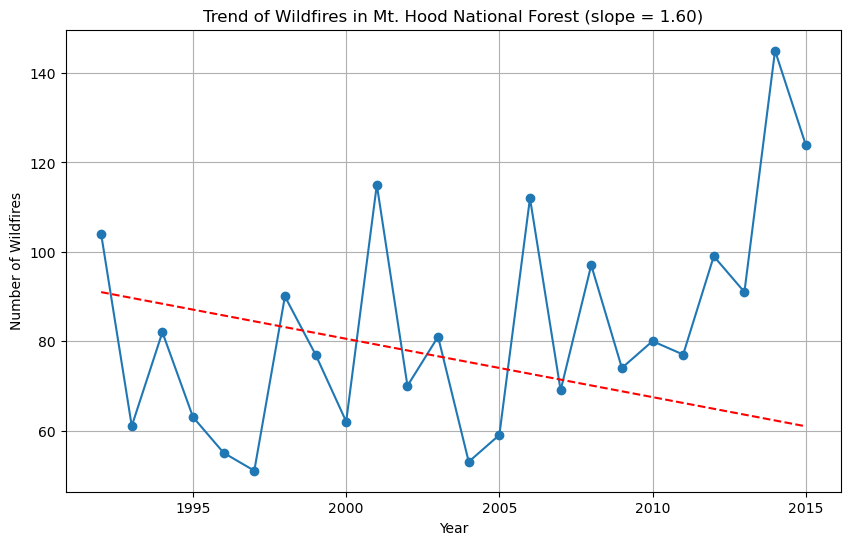

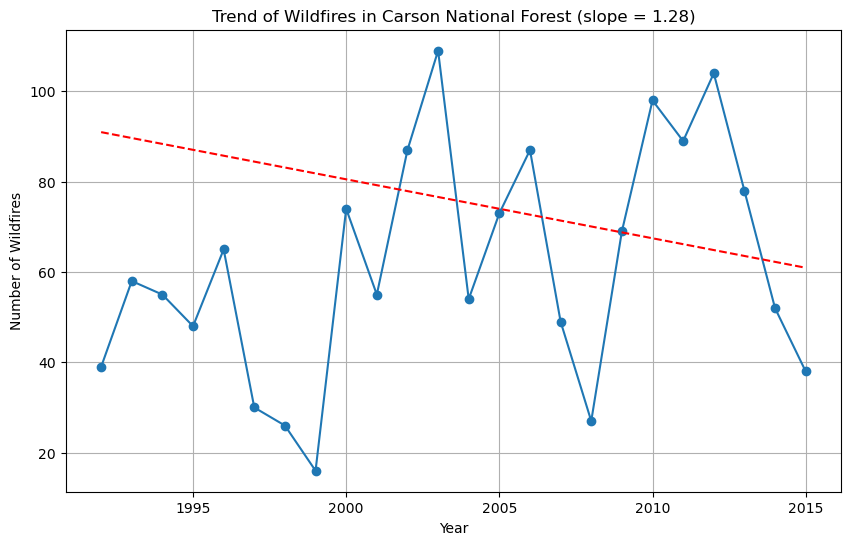

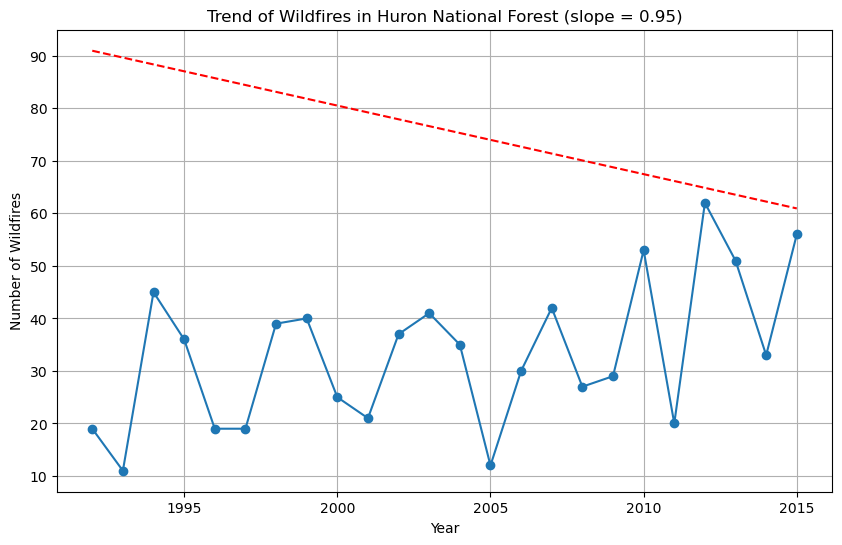

In [21]:
# Display the top 5 increase in the number of fires over time 

global_df['year'] = pd.to_datetime(global_df['date']).dt.year

yearly_fires_by_forest = global_df.groupby(['FORESTNAME', 'year'])['#wildfires'].sum().reset_index()

forests = yearly_fires_by_forest['FORESTNAME'].unique()

forests_with_increasing_fires = []

# Analyze each forest individually
for forest in forests:
    forest_data = yearly_fires_by_forest[yearly_fires_by_forest['FORESTNAME'] == forest]
    
    # If we don't have enough data, continue with the next forest
    if len(forest_data) < 2:
        continue
    
    # Extract years and number of fires
    X = forest_data['year'].values.reshape(-1, 1)
    y = forest_data['#wildfires'].values
    
    # Apply linear regression
    model = LinearRegression()
    model.fit(X, y)
    
    # Recover slope
    slope = model.coef_[0]
    
    # If the slope is positive, add the forest to the list
    if slope > 0:
        forests_with_increasing_fires.append((forest, slope))

# Show forests with an increase in the number of fires
forests_with_increasing_fires.sort(key=lambda x: x[1], reverse=True)
print("Forests with an increasing number of wildfires over time:")
for forest, slope in forests_with_increasing_fires:
    print(f"{forest}: slope = {slope:.2f}")

# Optionally, visualize the trends for the top few forests with the highest slopes
top_forests = forests_with_increasing_fires[:5]
for forest, slope in top_forests:
    forest_data = yearly_fires_by_forest[yearly_fires_by_forest['FORESTNAME'] == forest]
    X = forest_data['year'].values
    y = forest_data['#wildfires'].values
    
    plt.figure(figsize=(10, 6))
    plt.plot(X, y, marker='o')
    plt.plot(X, model.predict(X.reshape(-1, 1)), linestyle='--', color='red')
    plt.title(f'Trend of Wildfires in {forest} (slope = {slope:.2f})')
    plt.xlabel('Year')
    plt.ylabel('Number of Wildfires')
    plt.grid(True)
    plt.show()

# **<font color='grey'>Select few forests for ML</font>**

In [22]:
# Filter data for the forest
## Top 5
coconino_df = global_df[global_df['FORESTNAME'] == 'Coconino National Forest']
tonto_df = global_df[global_df['FORESTNAME'] == 'Tonto National Forest']
sanbernadino_df = global_df[global_df['FORESTNAME'] == 'San Bernardino National Forest']
deschutes_df = global_df[global_df['FORESTNAME'] == 'Deschutes National Forest']
ouachita_df = global_df[global_df['FORESTNAME'] == 'Ouachita National Forest']

## Include other states forest
chattahoochee_df = global_df[global_df['FORESTNAME'] == 'Chattahoochee National Forest']
lolo_df = global_df[global_df['FORESTNAME'] == 'Lolo National Forest']
desoto_df = global_df[global_df['FORESTNAME'] == 'De Soto National Forest']

In [23]:
# List of forests to process
forests = ['Coconino National Forest', 'Tonto National Forest', 'San Bernardino National Forest', 
           'Deschutes National Forest', 'Ouachita National Forest', 'Chattahoochee National Forest', 
           'Lolo National Forest', 'De Soto National Forest']

# **<font color='darkorange'>Preprocessing</font>**

In [24]:
# Function to prepare the data
def prepare_data(df):
    # Fill missing values for 'lightnings' and '#wildfires' columns
    df = df.fillna({'lightnings': 0, '#wildfires': 0})

    # Select specific columns
    columns_to_keep = [
        'date', 'year', 'month', 'weekday', 
        'TMAX_mean', 'TMIN_mean', 'TMAX_mean_10D', 'TMAX_mean_30D', 
        'TMIN_mean_10D', 'TMIN_mean_30D', 'PRCP_mean', 
        'PRCP_mean_10D', 'PRCP_mean_30D', 'lightnings', '#wildfires'
    ]
    df = df[columns_to_keep]

    # Create derived columns for cumulative wildfires over different time periods
    df['#wildfires_1D'] = df['#wildfires'].rolling(window=1, closed='left').sum()
    df['#wildfires_10D'] = df['#wildfires'].rolling(window=10, closed='left').sum()
    df['#wildfires_30D'] = df['#wildfires'].rolling(window=30, closed='left').sum()

    # Fill missing values for new derived columns
    df = df.fillna({'#wildfires_1D': 0, '#wildfires_10D': 0, '#wildfires_30D': 0})

    # Create a binary target column
    df['target'] = df['#wildfires'].apply(lambda x: 0 if x == 0 else 1)

    return df

# **<font color='blue'>Machine learning</font>**

## ***Random Forest Classifier***

In [117]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Function to process the data and train the model
def process_and_train(df):
    # Data preparation
    X = df.drop(['date', 'target', '#wildfires'], axis=1)
    y = df['target']

    # Set numeric columns
    num_cols = ['TMAX_mean', 'TMIN_mean', 'TMAX_mean_10D', 'TMAX_mean_30D', 'TMIN_mean_10D', 'TMIN_mean_30D', 
                'PRCP_mean', 'PRCP_mean_10D', 'PRCP_mean_30D', 'lightnings', '#wildfires_1D', '#wildfires_10D', 
                '#wildfires_30D']
    circular_cols = ['month', 'weekday']
    
    # Impute missing values with median
    imputer = SimpleImputer(strategy='median')
    X[num_cols] = imputer.fit_transform(X[num_cols])

    # Shift the 'weekday' values ​​so that Monday is represented by 1
    X['weekday'] = X['weekday'] + 1
           
    # Create sin and cos for circular columns
    X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
    X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
    X['weekday_sin'] = np.sin(2 * np.pi * X['weekday'] / 7)
    X['weekday_cos'] = np.cos(2 * np.pi * X['weekday'] / 7)

    # Drop original circular columns
    #X = X.drop(columns=circular_cols)
    
    # Standardize the features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train a Random Forest Classifier model
    model = RandomForestClassifier(n_estimators=200, max_features=4, max_depth=None, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Evaluate the model performance
    print("Random Forest Classifier :") 
    print("Accuracy :", accuracy)
    print(classification_report(y_test, y_pred))

    # Plot feature importances
    importances = model.feature_importances_
    feature_names = X_train.columns
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
    
    # Remove sin and cos columns from the feature importances
    feature_importances = feature_importances[~feature_importances['feature'].isin(['month_sin', 'month_cos', 'weekday_sin', 'weekday_cos'])]
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(14, 8))
    sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')
    plt.title('Feature Importances')
    plt.show()
  


Processing Coconino National Forest

Random Forest Classifier :
Accuracy : 0.7816419612314709
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1107
           1       0.73      0.64      0.68       647

    accuracy                           0.78      1754
   macro avg       0.77      0.75      0.76      1754
weighted avg       0.78      0.78      0.78      1754



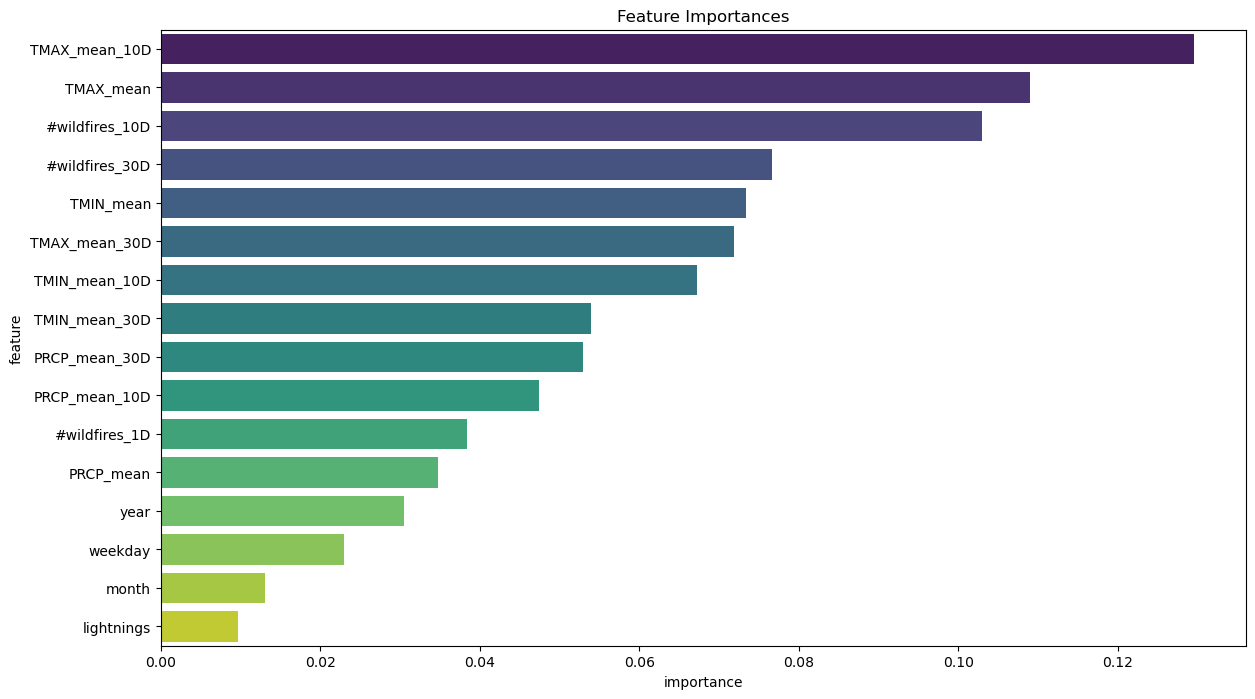


Processing Tonto National Forest

Random Forest Classifier :
Accuracy : 0.7651083238312428
              precision    recall  f1-score   support

           0       0.80      0.87      0.84      1215
           1       0.65      0.52      0.58       539

    accuracy                           0.77      1754
   macro avg       0.73      0.70      0.71      1754
weighted avg       0.76      0.77      0.76      1754



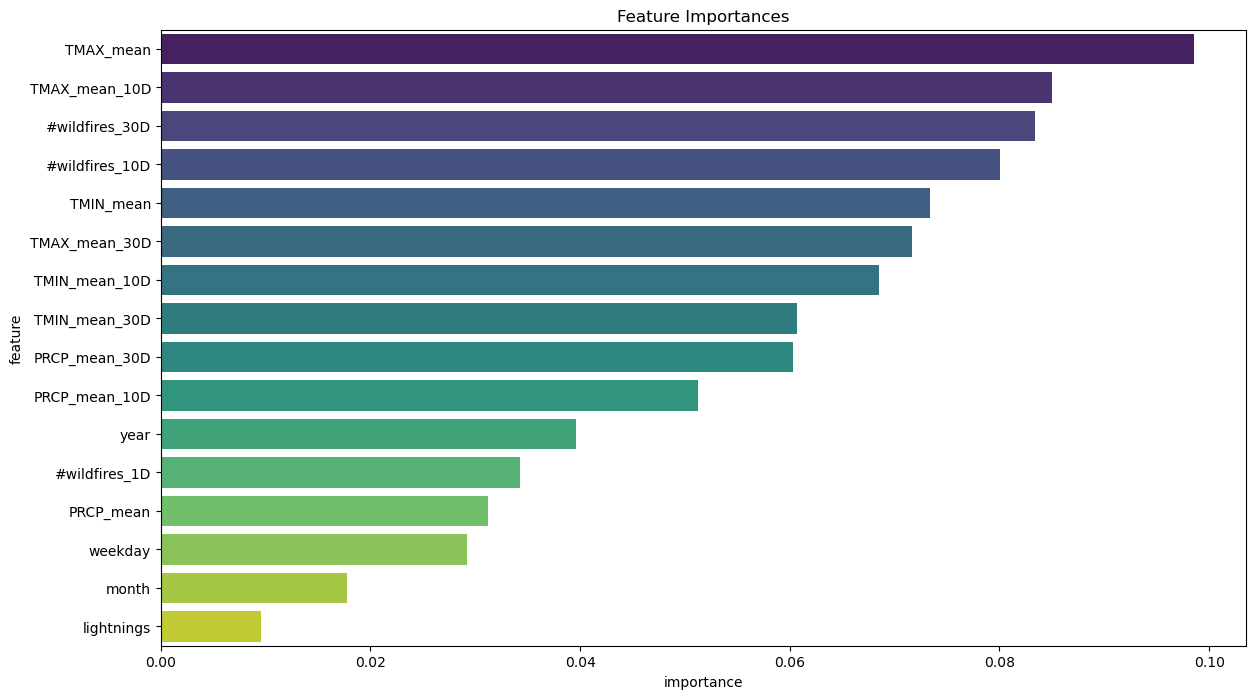


Processing San Bernardino National Forest

Random Forest Classifier :
Accuracy : 0.7462941847206386
              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1266
           1       0.57      0.37      0.45       488

    accuracy                           0.75      1754
   macro avg       0.68      0.63      0.64      1754
weighted avg       0.72      0.75      0.73      1754



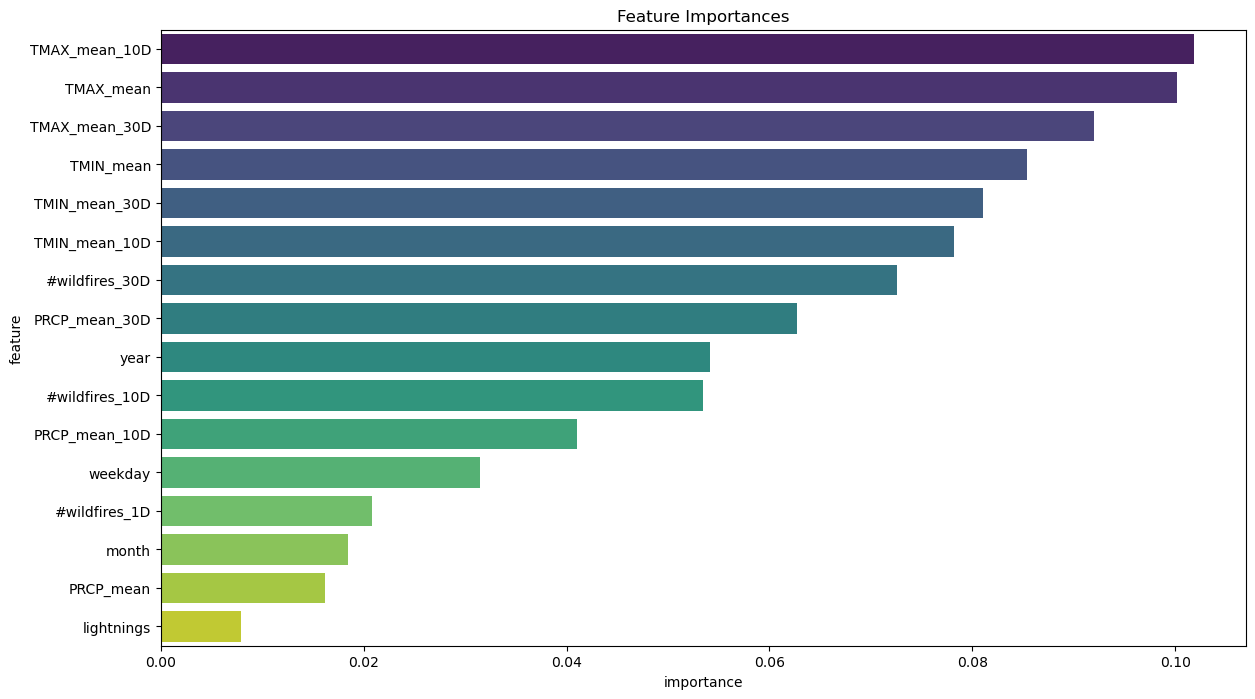


Processing Deschutes National Forest

Random Forest Classifier :
Accuracy : 0.7958950969213227
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1288
           1       0.63      0.55      0.59       466

    accuracy                           0.80      1754
   macro avg       0.74      0.72      0.73      1754
weighted avg       0.79      0.80      0.79      1754



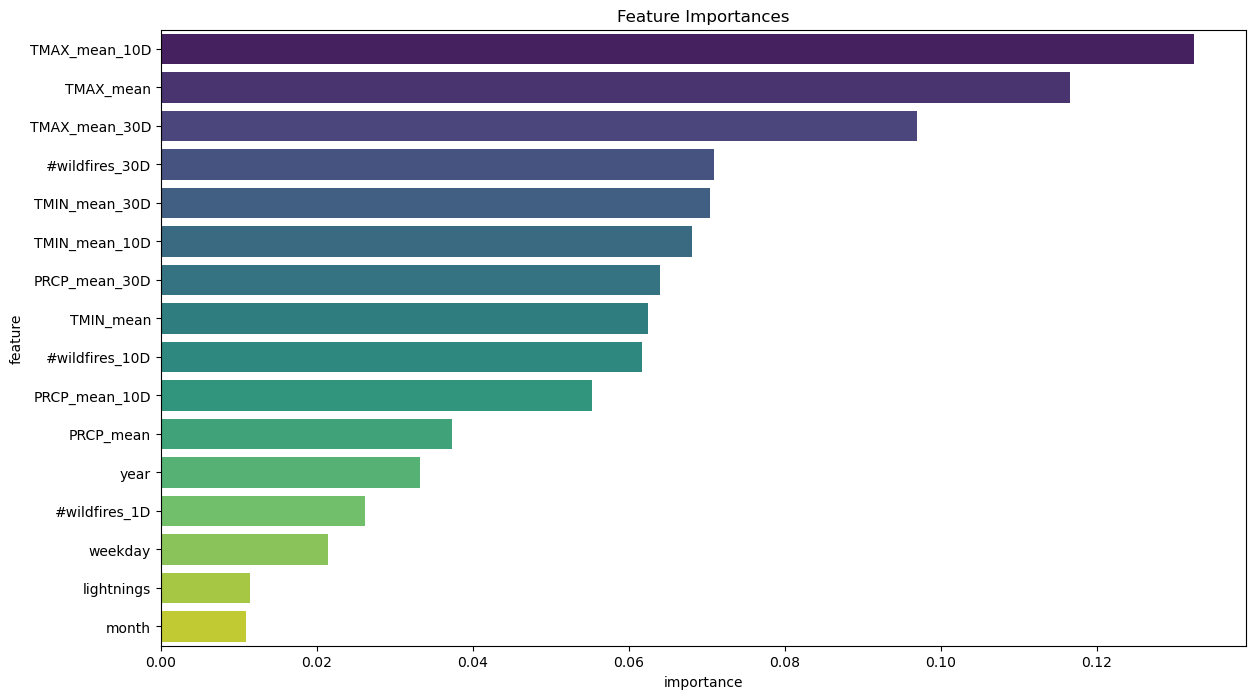


Processing Ouachita National Forest

Random Forest Classifier :
Accuracy : 0.7787913340935005
              precision    recall  f1-score   support

           0       0.81      0.91      0.86      1277
           1       0.64      0.44      0.52       477

    accuracy                           0.78      1754
   macro avg       0.72      0.67      0.69      1754
weighted avg       0.76      0.78      0.76      1754



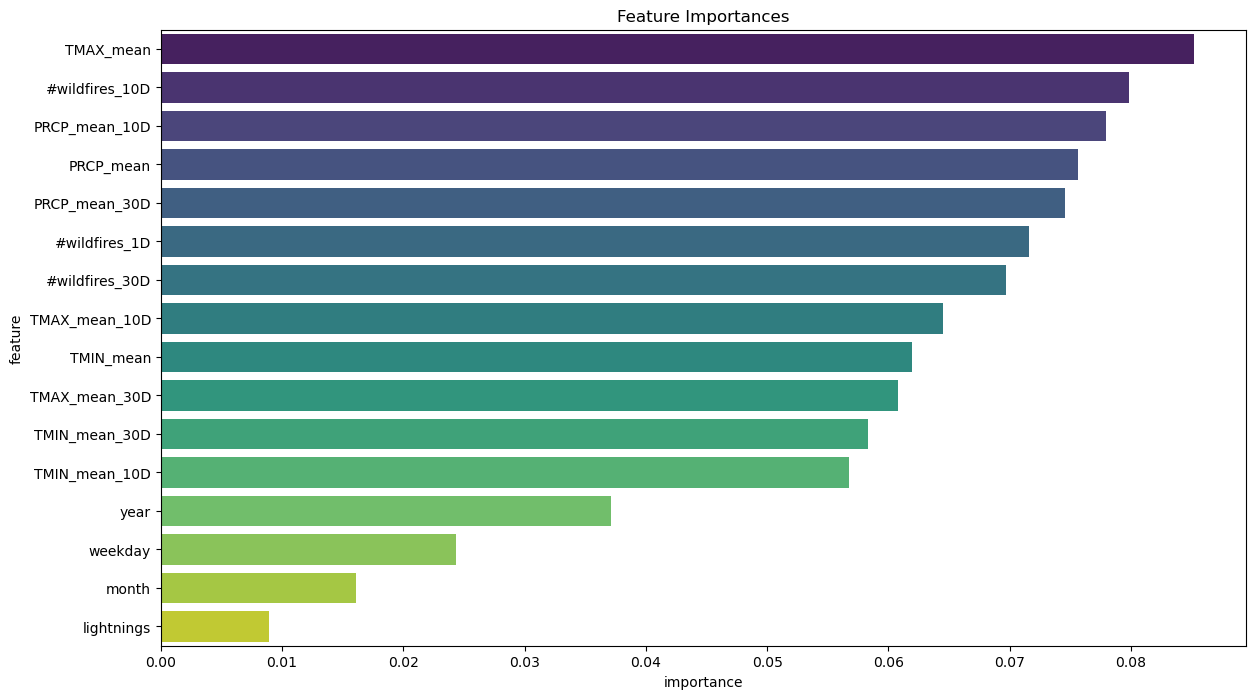


Processing Chattahoochee National Forest

Random Forest Classifier :
Accuracy : 0.8125714285714286
              precision    recall  f1-score   support

           0       0.84      0.94      0.88      1332
           1       0.68      0.41      0.51       418

    accuracy                           0.81      1750
   macro avg       0.76      0.68      0.70      1750
weighted avg       0.80      0.81      0.80      1750



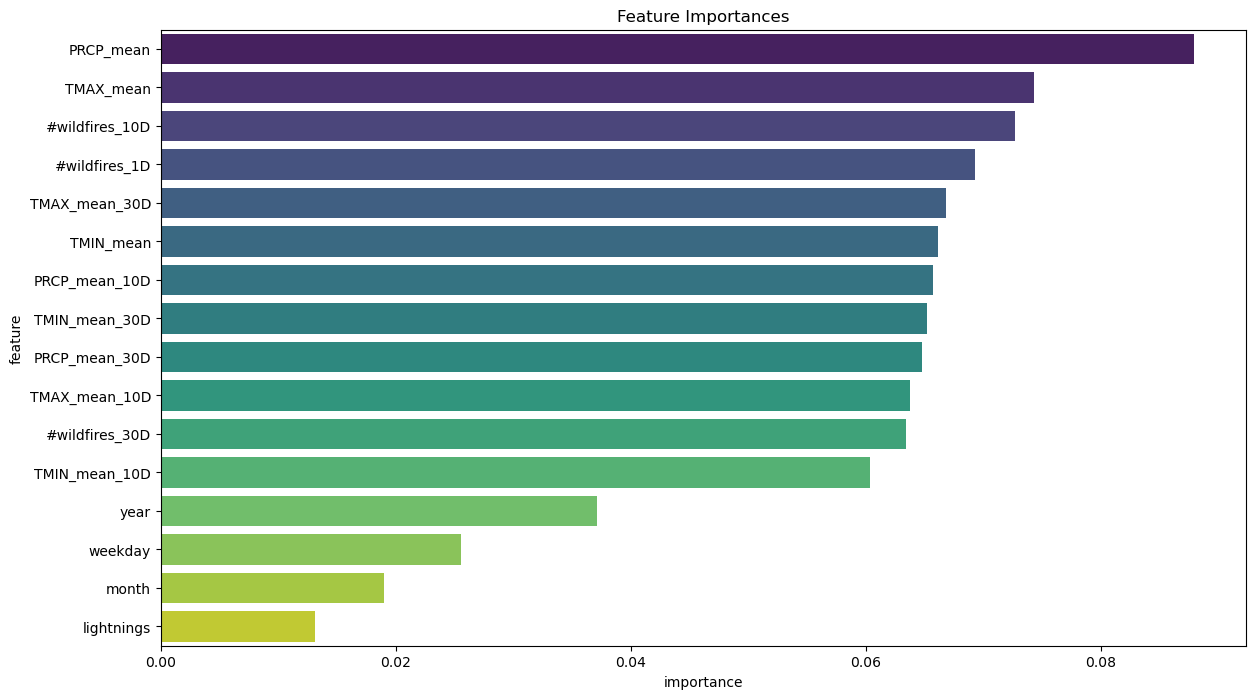


Processing Lolo National Forest

Random Forest Classifier :
Accuracy : 0.855188141391106
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1434
           1       0.64      0.47      0.54       320

    accuracy                           0.86      1754
   macro avg       0.76      0.71      0.73      1754
weighted avg       0.84      0.86      0.85      1754



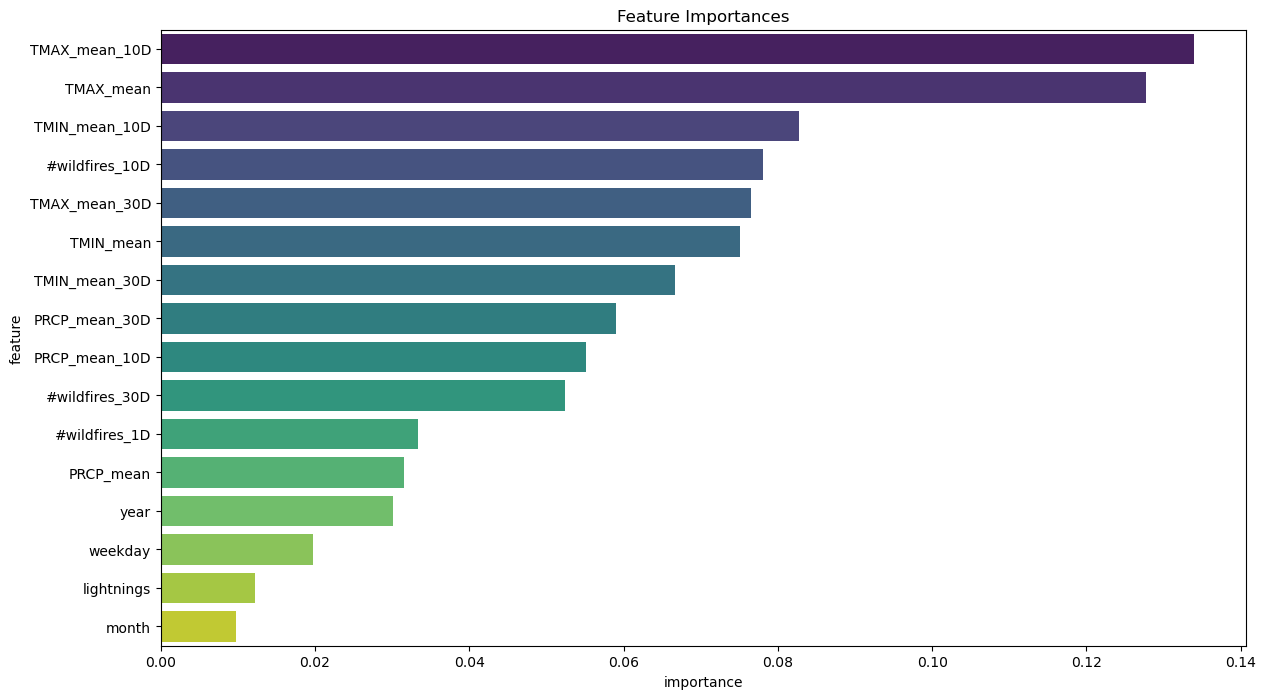


Processing De Soto National Forest

Random Forest Classifier :
Accuracy : 0.7946377638334284
              precision    recall  f1-score   support

           0       0.83      0.93      0.87      1353
           1       0.59      0.34      0.43       400

    accuracy                           0.79      1753
   macro avg       0.71      0.63      0.65      1753
weighted avg       0.77      0.79      0.77      1753



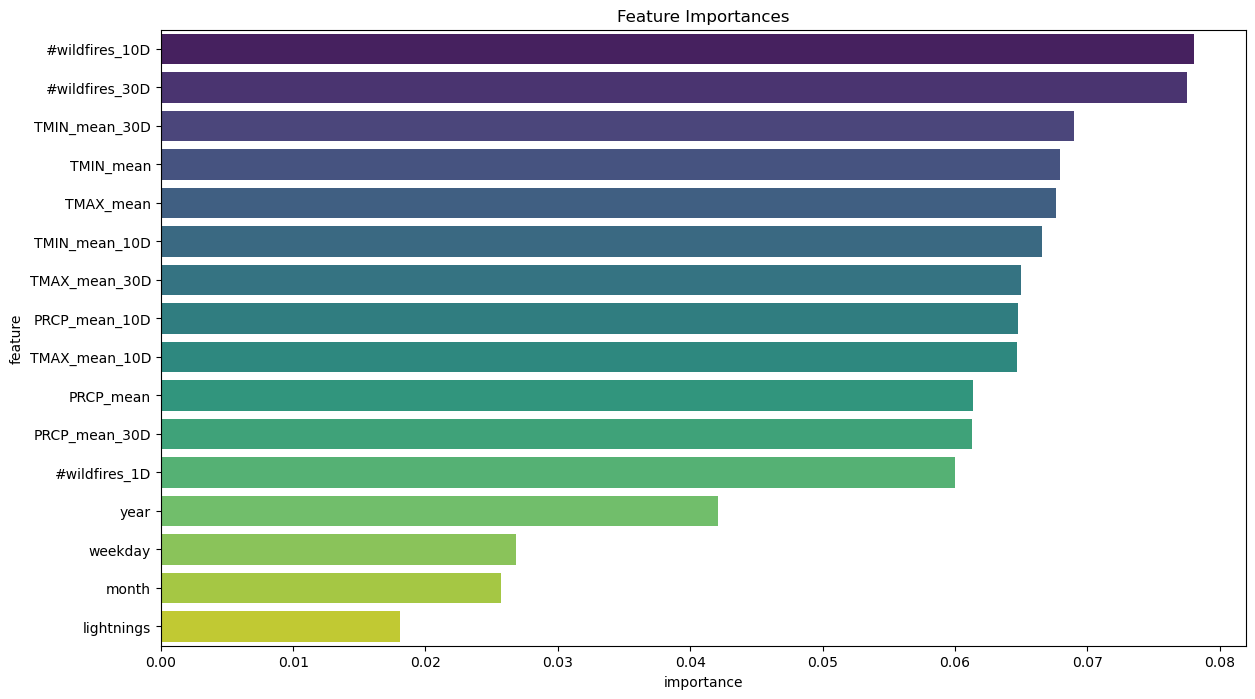

In [118]:
# Process each forest
for forest in forests:
    print(f"\nProcessing {forest}\n")
    forest_df = global_df[global_df['FORESTNAME'] == forest]
    forest_df = prepare_data(forest_df)
    process_and_train(forest_df)

## ***Logistic Regression***

In [115]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Function to process the data and train the models
def process_and_train(df):
    # Data preparation
    X = df.drop(['date', 'target', '#wildfires'], axis=1)
    y = df['target']

    # Set numeric and circular columns
    num_cols = ['TMAX_mean', 'TMIN_mean', 'TMAX_mean_10D', 'TMAX_mean_30D', 'TMIN_mean_10D', 'TMIN_mean_30D',
                'PRCP_mean', 'PRCP_mean_10D', 'PRCP_mean_30D', 'lightnings', '#wildfires_1D', '#wildfires_10D',
                '#wildfires_30D']
    circular_cols = ['month', 'weekday']

    # Impute missing values with median
    imputer = SimpleImputer(strategy='median')
    X[num_cols] = imputer.fit_transform(X[num_cols])

    # Shift the 'weekday' values so that Monday is represented by 1
    X['weekday'] = X['weekday'] + 1
           
    # Create sin and cos for circular columns
    X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
    X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
    X['weekday_sin'] = np.sin(2 * np.pi * X['weekday'] / 7)
    X['weekday_cos'] = np.cos(2 * np.pi * X['weekday'] / 7)

    # Drop original circular columns
    #X = X.drop(columns=circular_cols)

    # Standardize the features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train a Logistic Regression model
    model = LogisticRegression(penalty='l2', C=1.0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Evaluate the model performance
    print("Logistic Regression :")
    print("Accuracy:", accuracy)
    print(classification_report(y_test, y_pred))

    # Plot feature importances (coefficients)
    coefficients = model.coef_[0]
    feature_names = X_train.columns
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': coefficients})

    # Remove sin and cos columns from the feature importances
    feature_importances = feature_importances[~feature_importances['feature'].isin(['month_sin', 'month_cos', 'weekday_sin', 'weekday_cos'])]
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(14, 8))
    sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')
    plt.title('Feature Importances (Logistic Regression Coefficients)')
    plt.show()
    


Processing Coconino National Forest

Logistic Regression :
Accuracy: 0.7782212086659065
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1107
           1       0.74      0.61      0.67       647

    accuracy                           0.78      1754
   macro avg       0.77      0.74      0.75      1754
weighted avg       0.77      0.78      0.77      1754



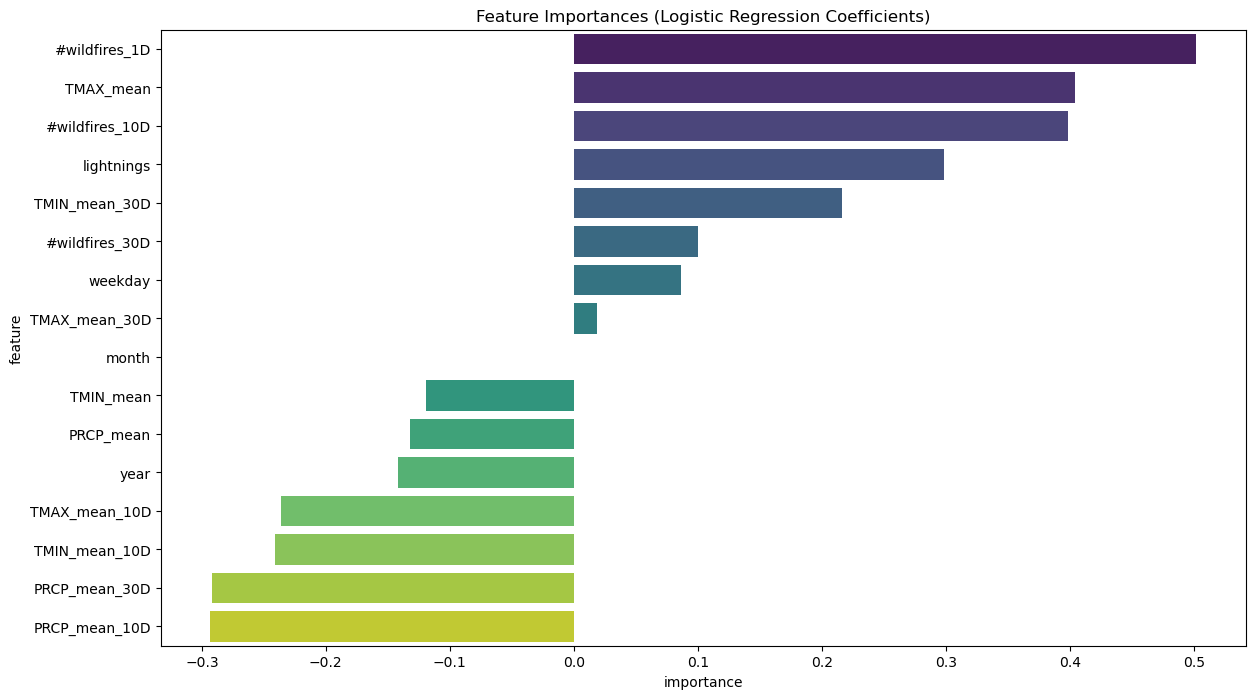


Processing Tonto National Forest

Logistic Regression :
Accuracy: 0.7696693272519954
              precision    recall  f1-score   support

           0       0.80      0.89      0.84      1215
           1       0.67      0.49      0.57       539

    accuracy                           0.77      1754
   macro avg       0.73      0.69      0.70      1754
weighted avg       0.76      0.77      0.76      1754



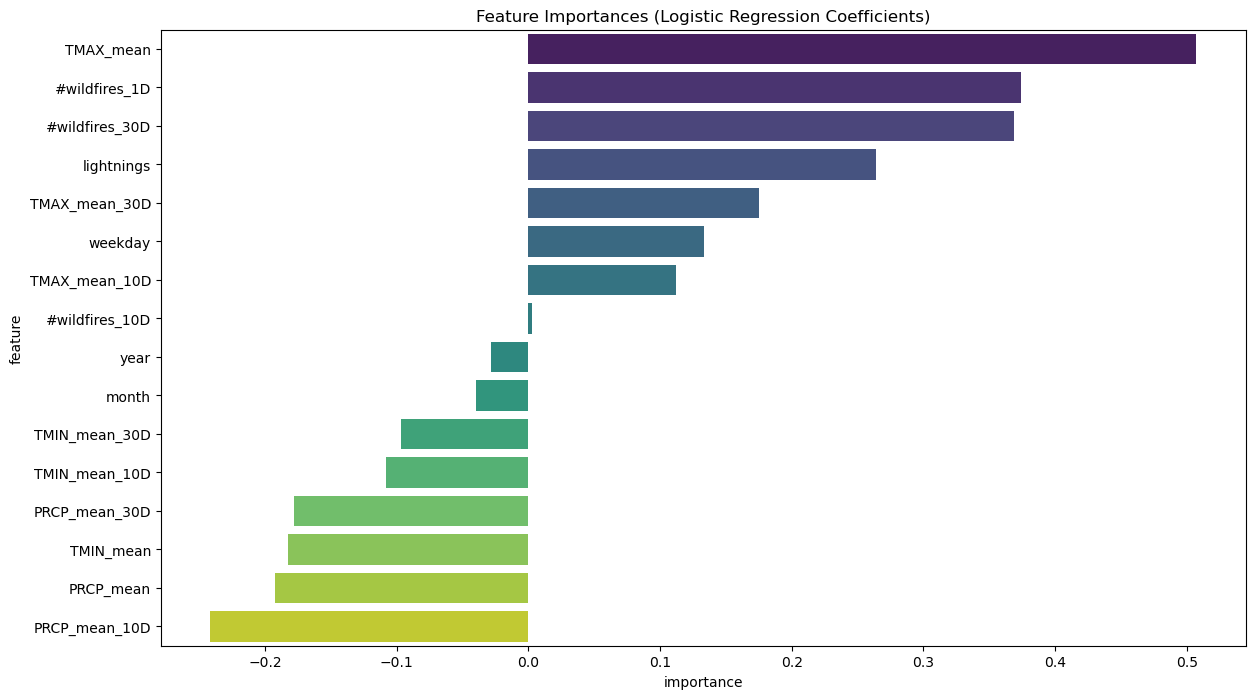


Processing San Bernardino National Forest

Logistic Regression :
Accuracy: 0.7519954389965793
              precision    recall  f1-score   support

           0       0.78      0.91      0.84      1266
           1       0.59      0.34      0.44       488

    accuracy                           0.75      1754
   macro avg       0.69      0.63      0.64      1754
weighted avg       0.73      0.75      0.73      1754



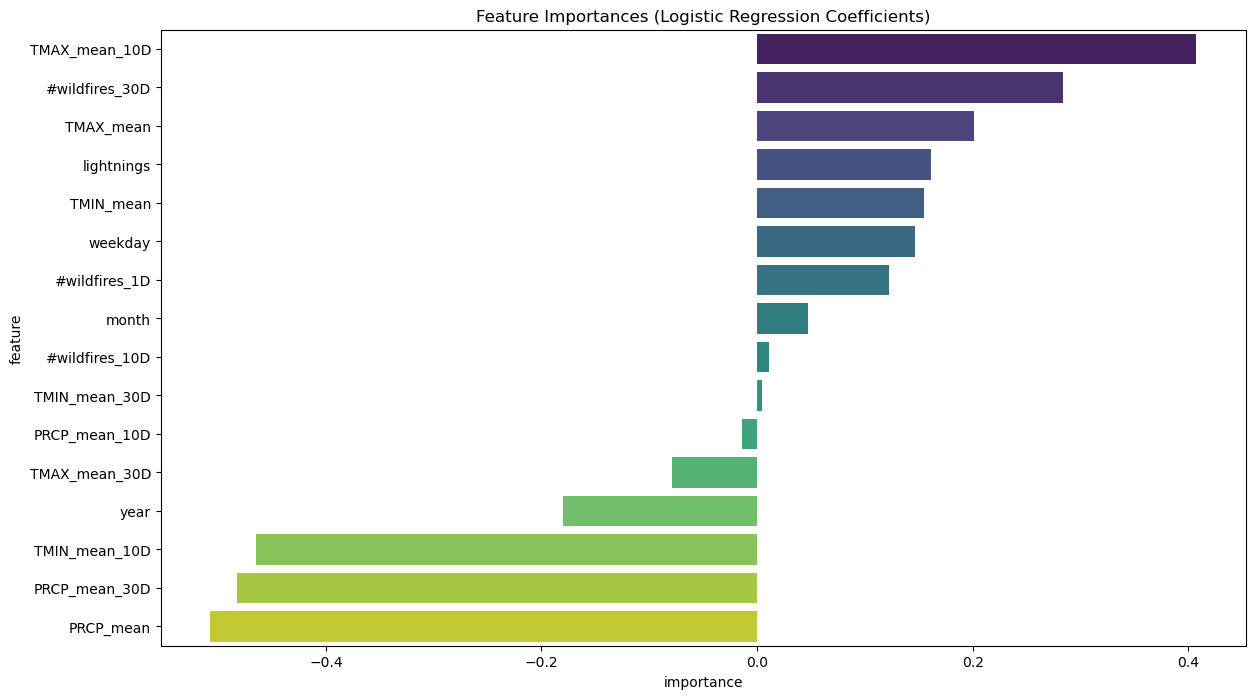


Processing Deschutes National Forest

Logistic Regression :
Accuracy: 0.8050171037628279
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1288
           1       0.65      0.57      0.61       466

    accuracy                           0.81      1754
   macro avg       0.75      0.73      0.74      1754
weighted avg       0.80      0.81      0.80      1754



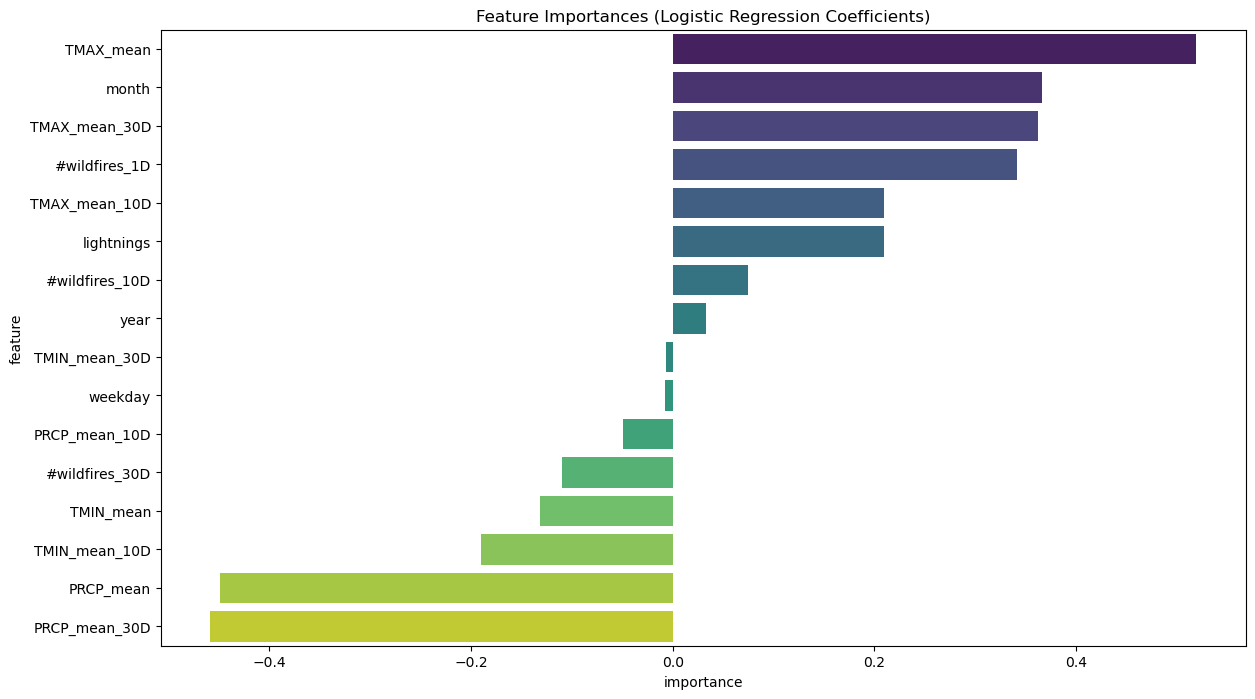


Processing Ouachita National Forest

Logistic Regression :
Accuracy: 0.7867730900798175
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1277
           1       0.67      0.42      0.52       477

    accuracy                           0.79      1754
   macro avg       0.74      0.67      0.69      1754
weighted avg       0.77      0.79      0.77      1754



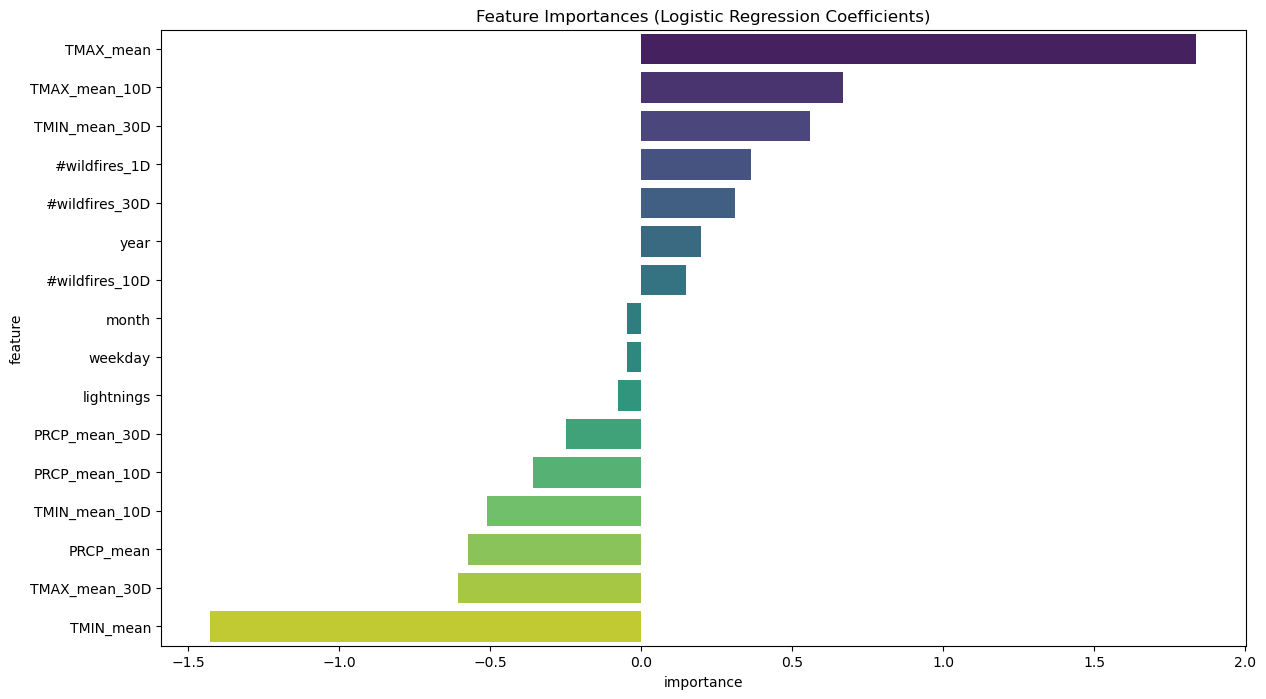


Processing Chattahoochee National Forest

Logistic Regression :
Accuracy: 0.8228571428571428
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      1332
           1       0.73      0.41      0.53       418

    accuracy                           0.82      1750
   macro avg       0.78      0.68      0.71      1750
weighted avg       0.81      0.82      0.80      1750



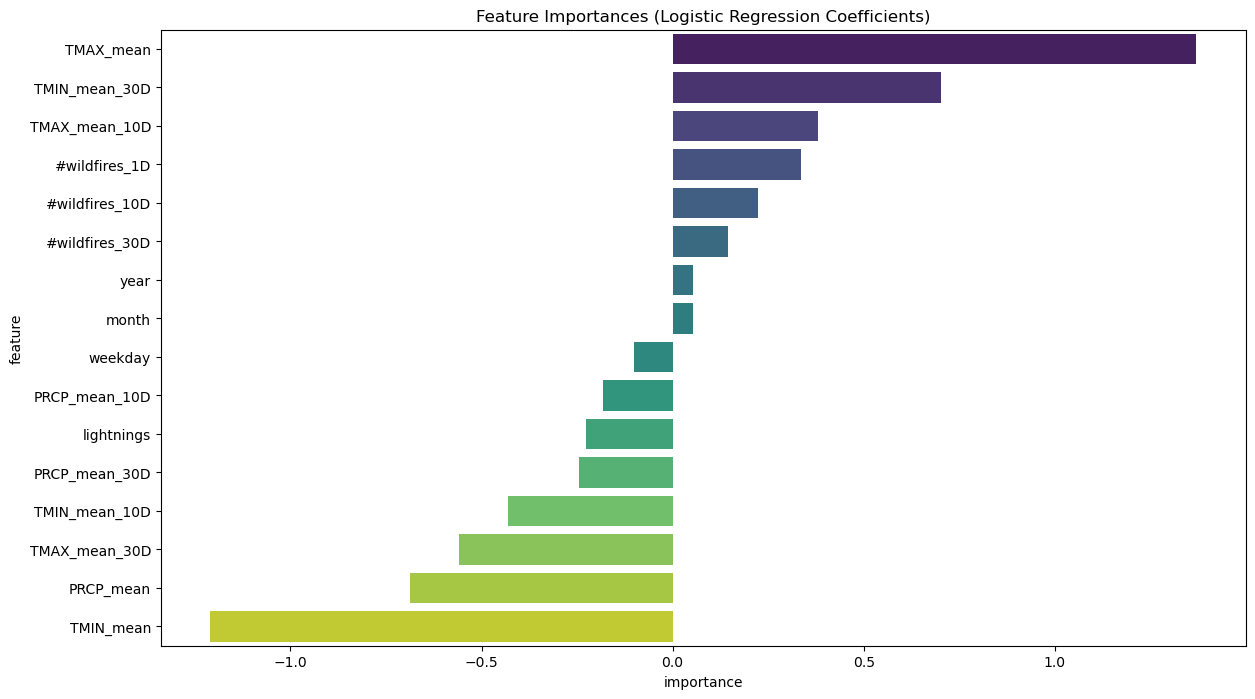


Processing Lolo National Forest

Logistic Regression :
Accuracy: 0.8591790193842646
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1434
           1       0.67      0.45      0.54       320

    accuracy                           0.86      1754
   macro avg       0.78      0.70      0.73      1754
weighted avg       0.85      0.86      0.85      1754



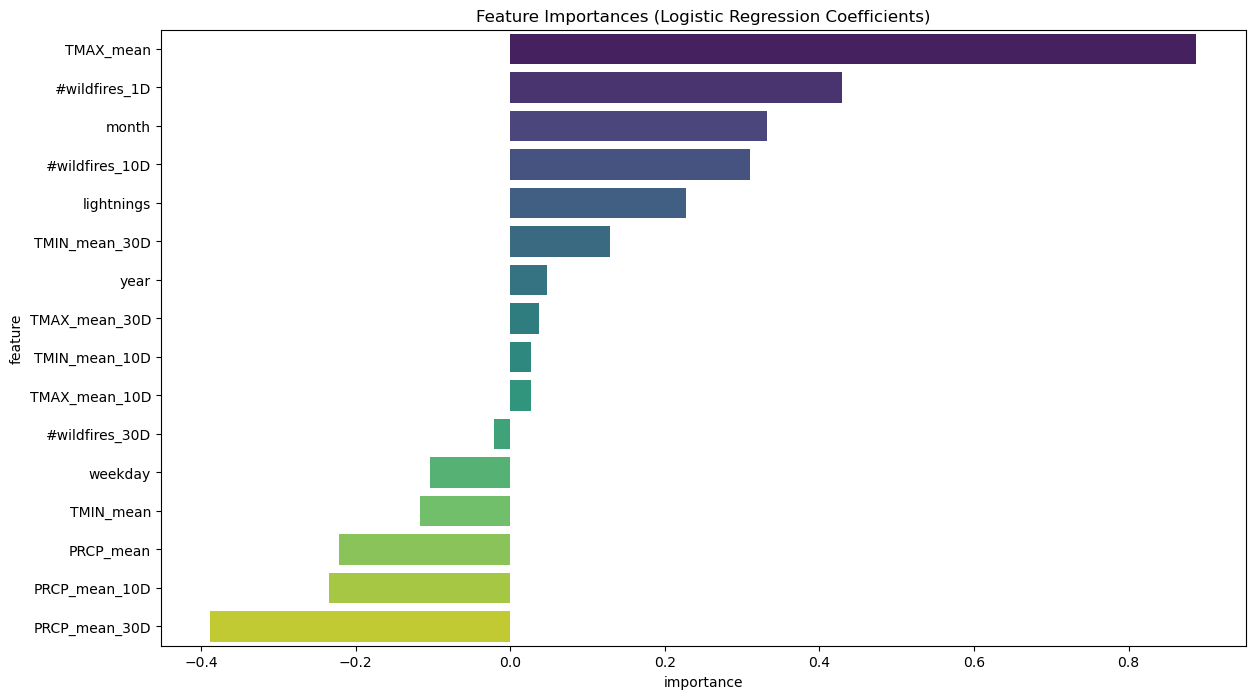


Processing De Soto National Forest

Logistic Regression :
Accuracy: 0.8060467769537935
              precision    recall  f1-score   support

           0       0.83      0.95      0.88      1353
           1       0.65      0.33      0.44       400

    accuracy                           0.81      1753
   macro avg       0.74      0.64      0.66      1753
weighted avg       0.79      0.81      0.78      1753



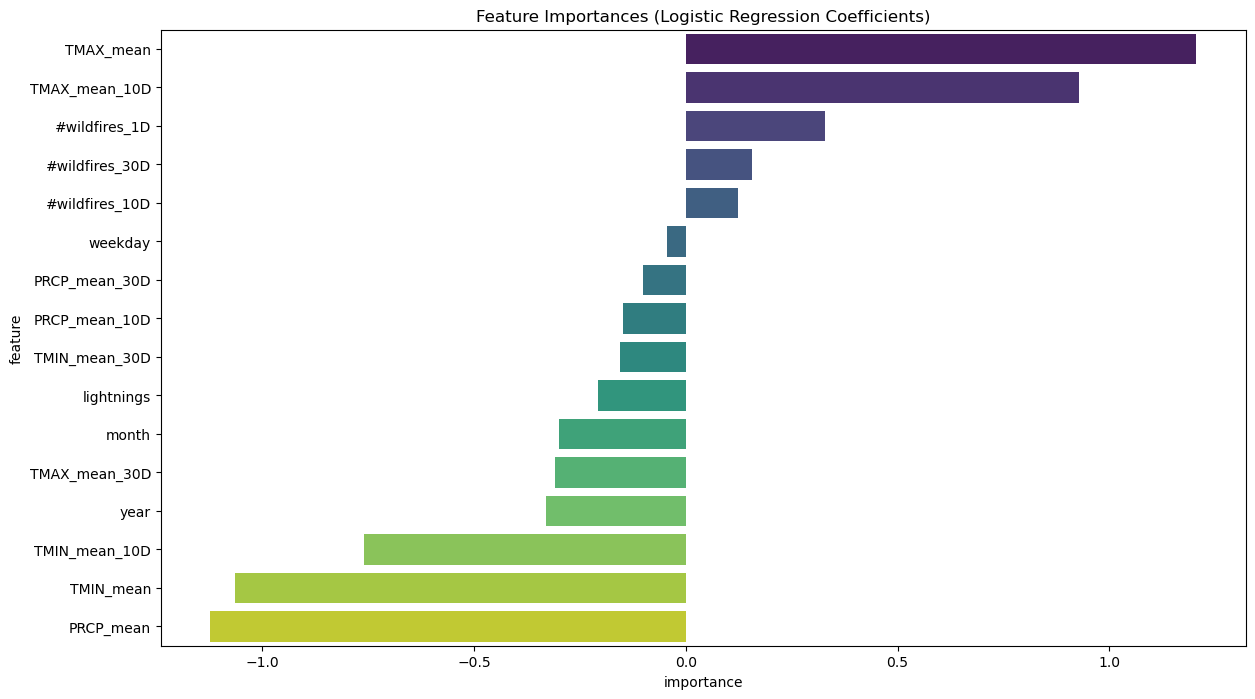

In [116]:
# Process each forest
for forest in forests:
    print(f"\nProcessing {forest}\n")
    forest_df = global_df[global_df['FORESTNAME'] == forest]
    forest_df = prepare_data(forest_df)
    process_and_train(forest_df)

## ***Multi Layer Perceptron***

In [113]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

# Function to process the data and train the models
def process_and_train(df):
    # Data preparation
    X = df.drop(['date', 'target', '#wildfires'], axis=1)
    y = df['target']

    # Set numeric and circular columns
    num_cols = ['TMAX_mean', 'TMIN_mean', 'TMAX_mean_10D', 'TMAX_mean_30D', 'TMIN_mean_10D', 'TMIN_mean_30D',
                'PRCP_mean', 'PRCP_mean_10D', 'PRCP_mean_30D', 'lightnings', '#wildfires_1D', '#wildfires_10D',
                '#wildfires_30D']
    circular_cols = ['month', 'weekday']

    # Impute missing values with median
    imputer = SimpleImputer(strategy='median')
    X[num_cols] = imputer.fit_transform(X[num_cols])

    # Shift the 'weekday' values so that Monday is represented by 1
    X['weekday'] = X['weekday'] + 1
           
    # Create sin and cos for circular columns
    X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
    X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
    X['weekday_sin'] = np.sin(2 * np.pi * X['weekday'] / 7)
    X['weekday_cos'] = np.cos(2 * np.pi * X['weekday'] / 7)

    # Drop original circular columns
    #X = X.drop(columns=circular_cols)

    # Standardize the features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train an MLPClassifier
    model = MLPClassifier(hidden_layer_sizes=(50,), activation='identity', alpha=0.005,
                                    learning_rate='adaptive', solver='sgd', random_state=42, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Evaluate the model performance
    print("MLP Classifier :")
    print("Accuracy:", accuracy)
    print(classification_report(y_test, y_pred))

    # Plot feature importances (using the weights of the first hidden layer)
    coefs = model.coefs_[0]  # Coefficients of the first hidden layer
    feature_names = X_train.columns
    importances = np.mean(np.abs(coefs), axis=1)  # Mean absolute weights

    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

    # Remove sin and cos columns from the feature importances
    feature_importances = feature_importances[~feature_importances['feature'].isin(['month_sin', 'month_cos', 'weekday_sin', 'weekday_cos'])]
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(14, 8))
    sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')
    plt.title('Feature Importances (MLP Weights)')
    plt.show()



Processing Coconino National Forest

MLP Classifier :
Accuracy: 0.7793614595210946
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1107
           1       0.74      0.61      0.67       647

    accuracy                           0.78      1754
   macro avg       0.77      0.74      0.75      1754
weighted avg       0.78      0.78      0.77      1754



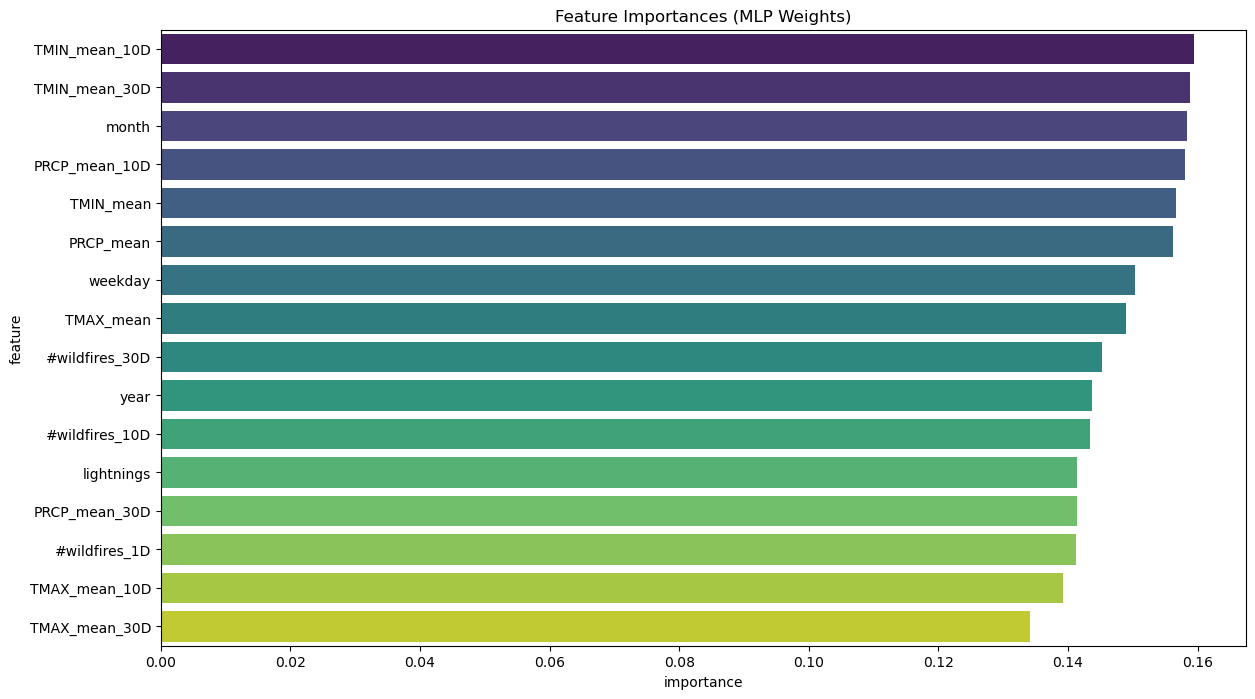


Processing Tonto National Forest

MLP Classifier :
Accuracy: 0.7702394526795895
              precision    recall  f1-score   support

           0       0.80      0.90      0.84      1215
           1       0.67      0.49      0.57       539

    accuracy                           0.77      1754
   macro avg       0.74      0.69      0.70      1754
weighted avg       0.76      0.77      0.76      1754



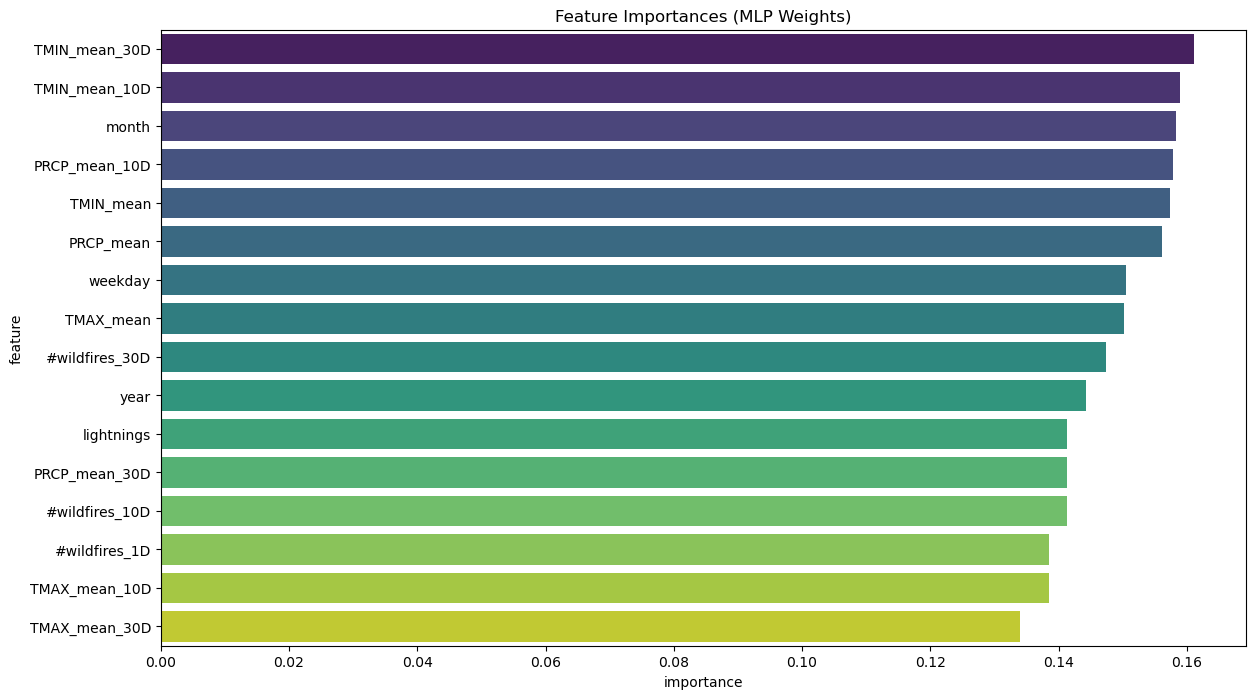


Processing San Bernardino National Forest

MLP Classifier :
Accuracy: 0.7525655644241733
              precision    recall  f1-score   support

           0       0.78      0.91      0.84      1266
           1       0.60      0.34      0.43       488

    accuracy                           0.75      1754
   macro avg       0.69      0.63      0.64      1754
weighted avg       0.73      0.75      0.73      1754



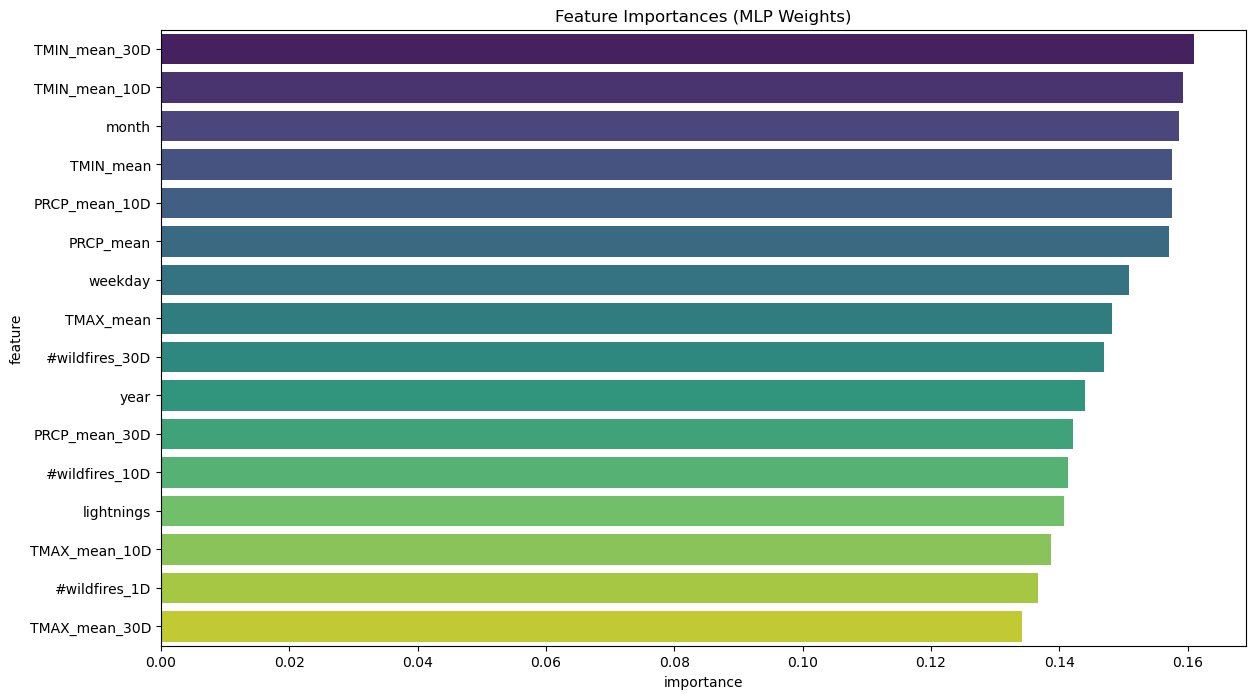


Processing Deschutes National Forest

MLP Classifier :
Accuracy: 0.8072976054732041
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1288
           1       0.66      0.57      0.61       466

    accuracy                           0.81      1754
   macro avg       0.76      0.73      0.74      1754
weighted avg       0.80      0.81      0.80      1754



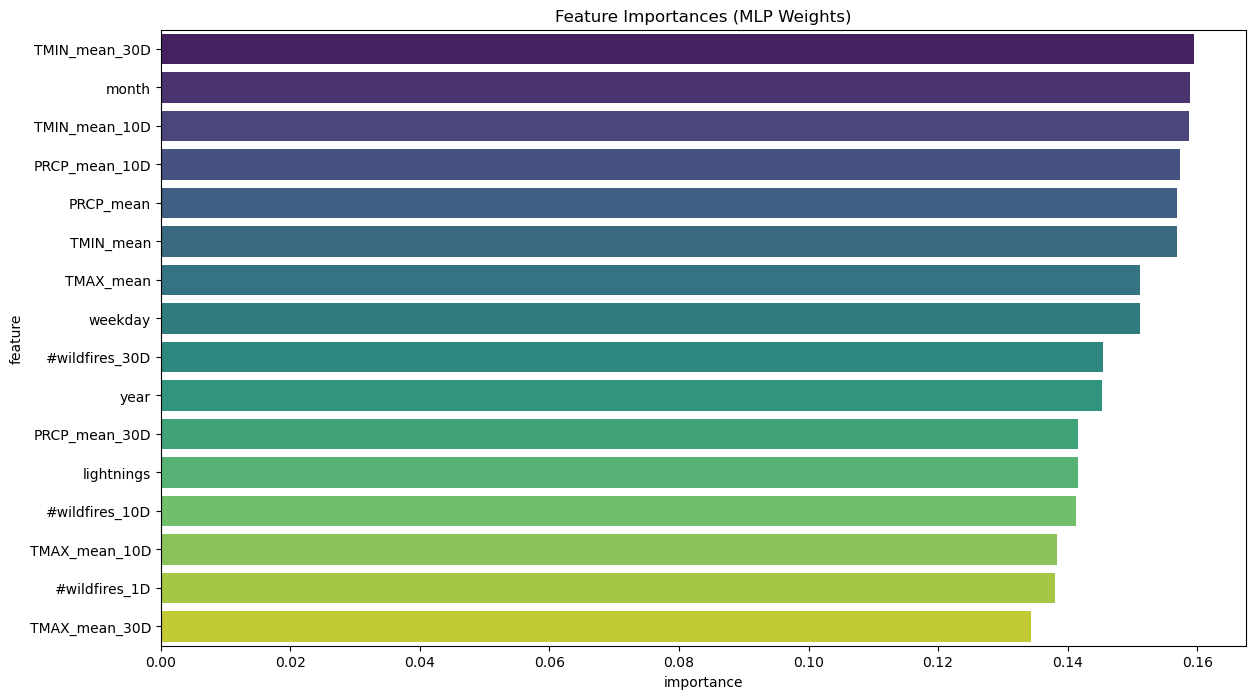


Processing Ouachita National Forest

MLP Classifier :
Accuracy: 0.7879133409350056
              precision    recall  f1-score   support

           0       0.81      0.93      0.86      1277
           1       0.68      0.42      0.52       477

    accuracy                           0.79      1754
   macro avg       0.74      0.67      0.69      1754
weighted avg       0.77      0.79      0.77      1754



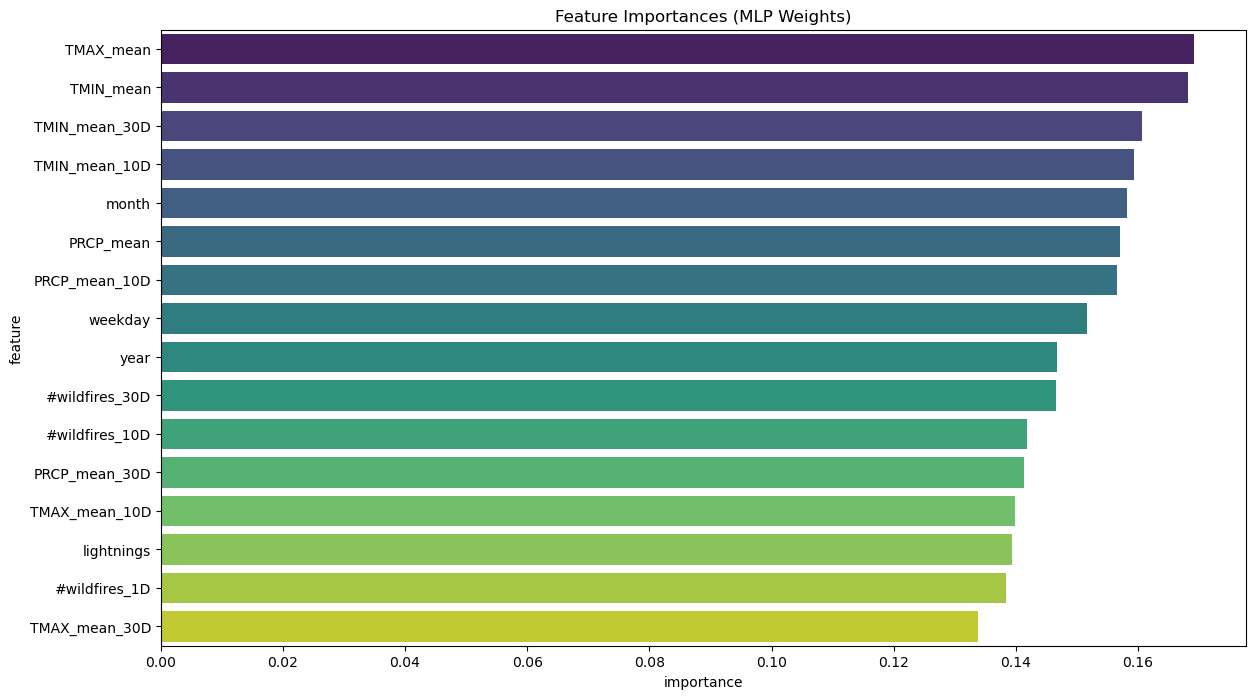


Processing Chattahoochee National Forest

MLP Classifier :
Accuracy: 0.8205714285714286
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1332
           1       0.73      0.39      0.51       418

    accuracy                           0.82      1750
   macro avg       0.78      0.67      0.70      1750
weighted avg       0.81      0.82      0.80      1750



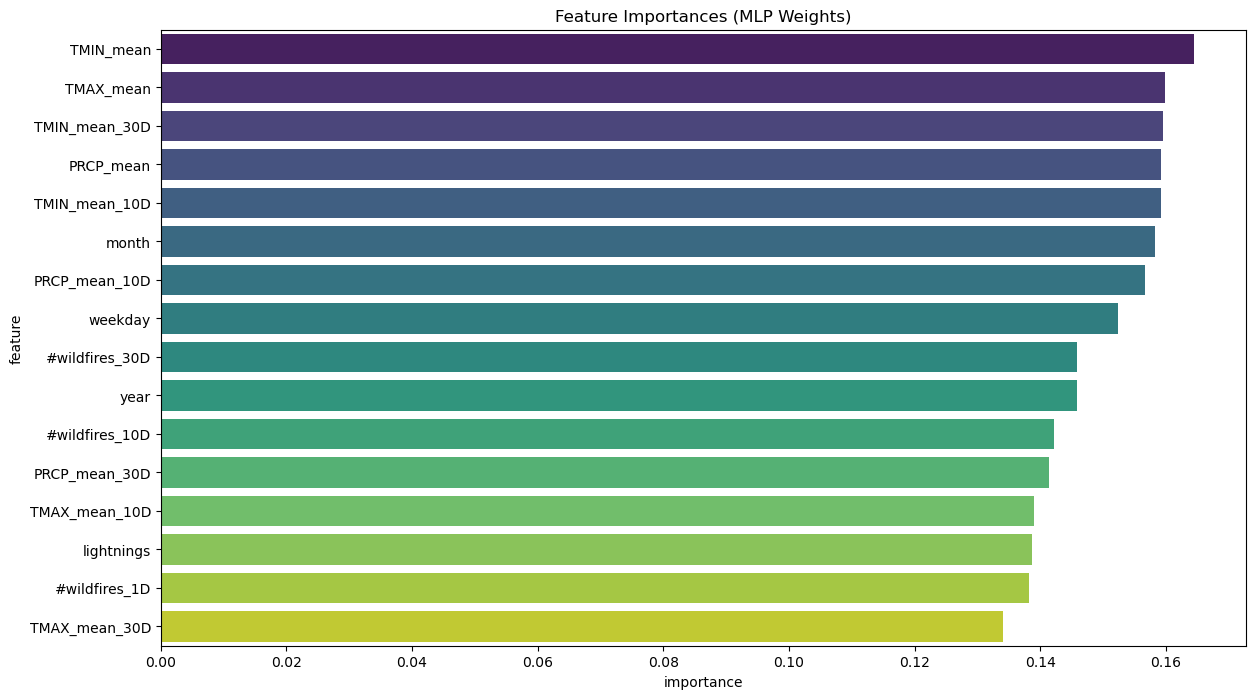


Processing Lolo National Forest

MLP Classifier :
Accuracy: 0.8586088939566705
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      1434
           1       0.67      0.44      0.53       320

    accuracy                           0.86      1754
   macro avg       0.78      0.70      0.72      1754
weighted avg       0.85      0.86      0.85      1754



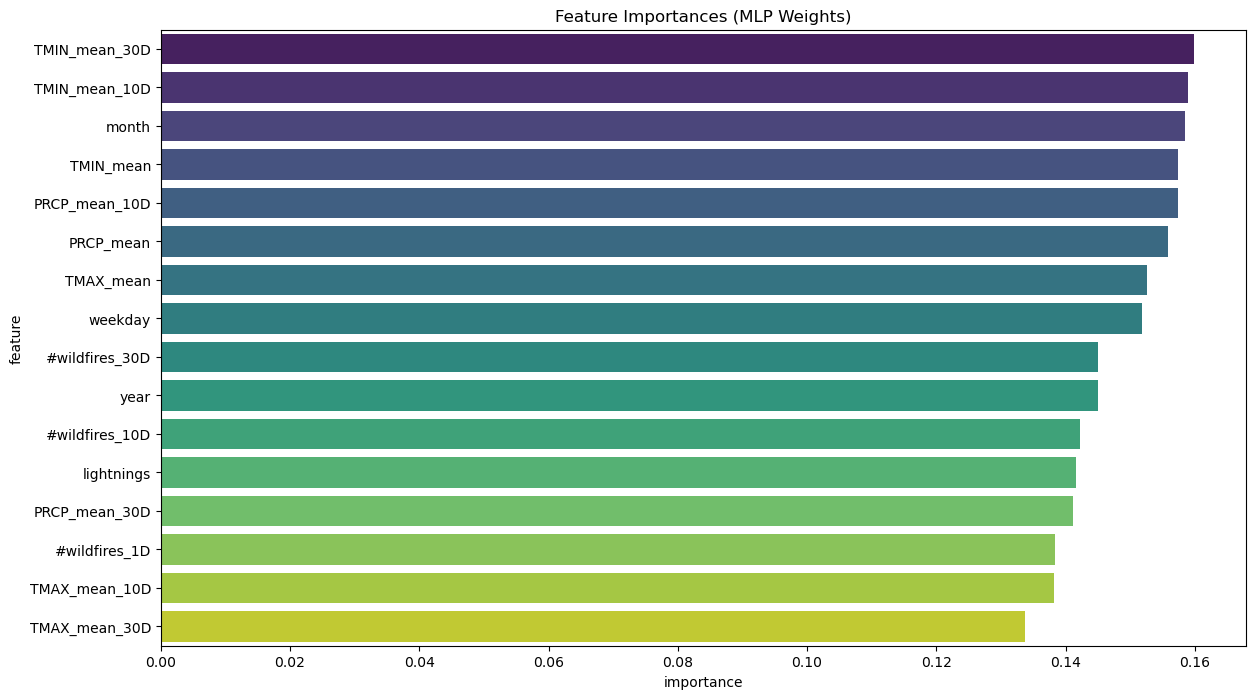


Processing De Soto National Forest

MLP Classifier :
Accuracy: 0.802624073017684
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      1353
           1       0.64      0.30      0.41       400

    accuracy                           0.80      1753
   macro avg       0.73      0.63      0.65      1753
weighted avg       0.78      0.80      0.77      1753



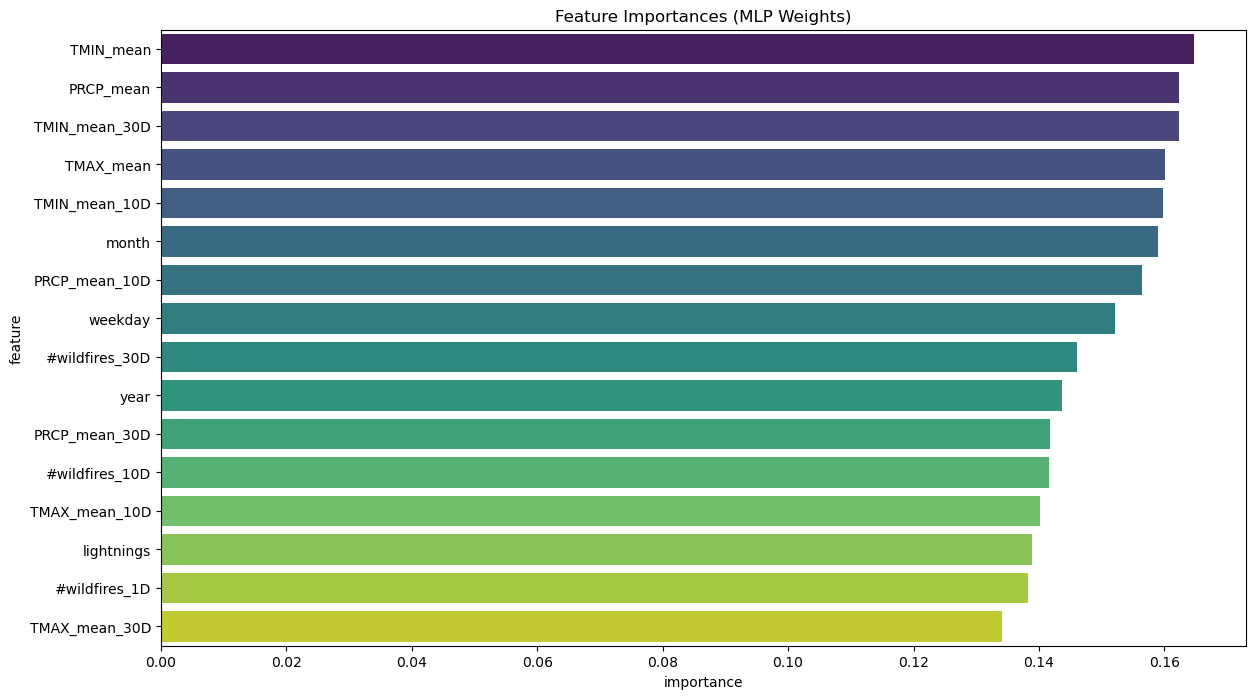

In [114]:
# Process each forest
for forest in forests:
    print(f"\nProcessing {forest}\n")
    forest_df = global_df[global_df['FORESTNAME'] == forest]
    forest_df = prepare_data(forest_df)
    process_and_train(forest_df)

## ***Support Vector Machine***

In [75]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.inspection import permutation_importance

# Function to process the data and train the models
def process_and_train(df):
    # Data preparation
    X = df.drop(['date', 'target', '#wildfires'], axis=1)
    y = df['target']

    # Set numeric and circular columns
    num_cols = ['TMAX_mean', 'TMIN_mean', 'TMAX_mean_10D', 'TMAX_mean_30D', 'TMIN_mean_10D', 'TMIN_mean_30D',
                'PRCP_mean', 'PRCP_mean_10D', 'PRCP_mean_30D', 'lightnings', '#wildfires_1D', '#wildfires_10D',
                '#wildfires_30D']
    circular_cols = ['month', 'weekday']

    # Impute missing values with median
    imputer = SimpleImputer(strategy='median')
    X[num_cols] = imputer.fit_transform(X[num_cols])

    # Shift the 'weekday' values so that Monday is represented by 1
    X['weekday'] = X['weekday'] + 1
           
    # Create sin and cos for circular columns
    X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
    X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
    X['weekday_sin'] = np.sin(2 * np.pi * X['weekday'] / 7)
    X['weekday_cos'] = np.cos(2 * np.pi * X['weekday'] / 7)

    # Drop original circular columns
    X = X.drop(columns=circular_cols)

    # Standardize the features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train an SVM model
    model = SVC(kernel='rbf', gamma=0.0001, C=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Print the accuracy and classification report for the model
    print("SVM :")
    print("Accuracy:", accuracy)
    print(classification_report(y_test, y_pred))

    # Calculate feature importances using permutation importance
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    importances = perm_importance.importances_mean
    feature_names = X_train.columns
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
    
    # Remove sin and cos columns from the feature importances
    feature_importances = feature_importances[~feature_importances['feature'].isin(['month_sin', 'month_cos', 'weekday_sin', 'weekday_cos'])]
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(14, 8))
    sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')
    plt.title('Feature Importances (SVM RBF Kernel)')
    plt.show()



Processing Coconino National Forest...

SVM with year:
Accuracy: 0.7765108323831242
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1107
           1       0.75      0.59      0.66       647

    accuracy                           0.78      1754
   macro avg       0.77      0.74      0.75      1754
weighted avg       0.77      0.78      0.77      1754



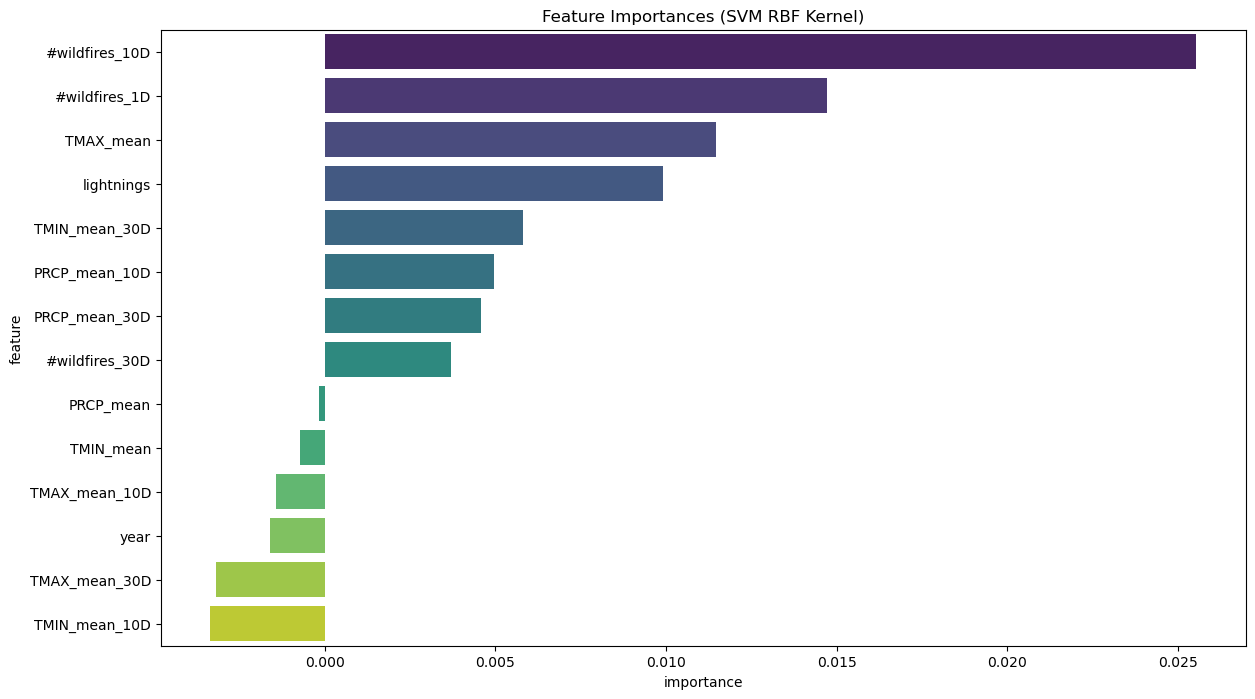


Processing Tonto National Forest...

SVM with year:
Accuracy: 0.7622576966932725
              precision    recall  f1-score   support

           0       0.77      0.93      0.84      1215
           1       0.71      0.38      0.50       539

    accuracy                           0.76      1754
   macro avg       0.74      0.66      0.67      1754
weighted avg       0.75      0.76      0.74      1754



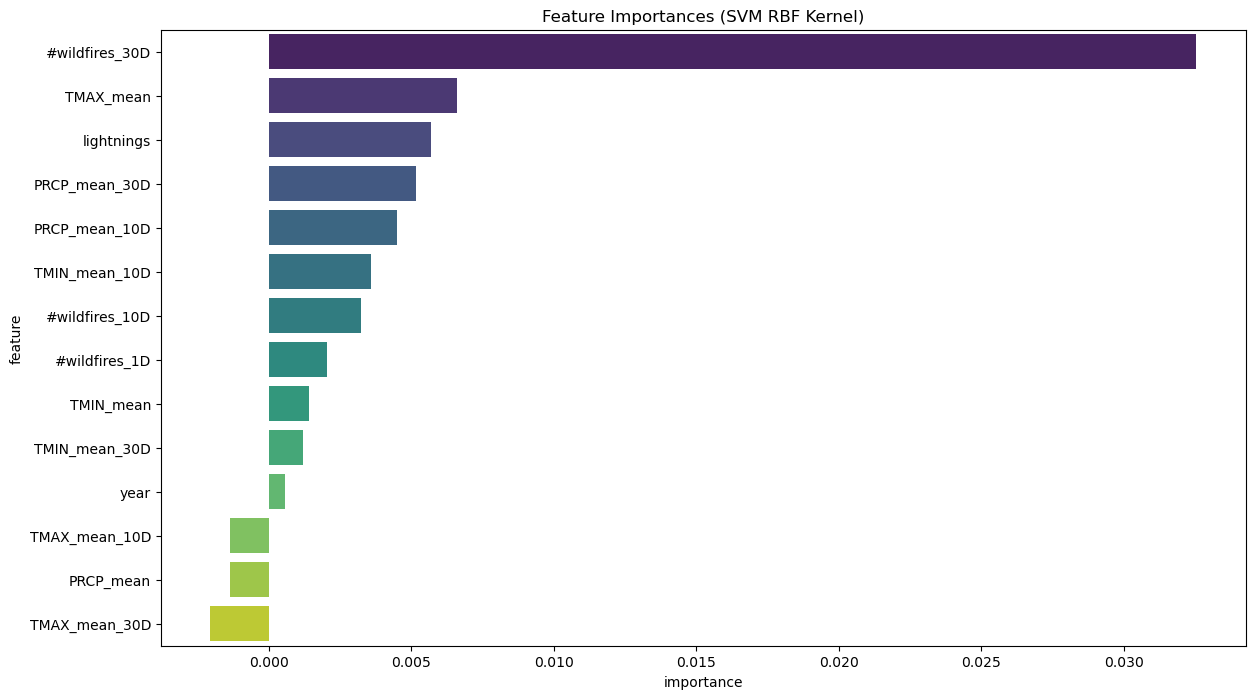


Processing San Bernardino National Forest...

SVM with year:
Accuracy: 0.7474344355758267
              precision    recall  f1-score   support

           0       0.75      0.97      0.85      1266
           1       0.70      0.16      0.27       488

    accuracy                           0.75      1754
   macro avg       0.72      0.57      0.56      1754
weighted avg       0.74      0.75      0.69      1754



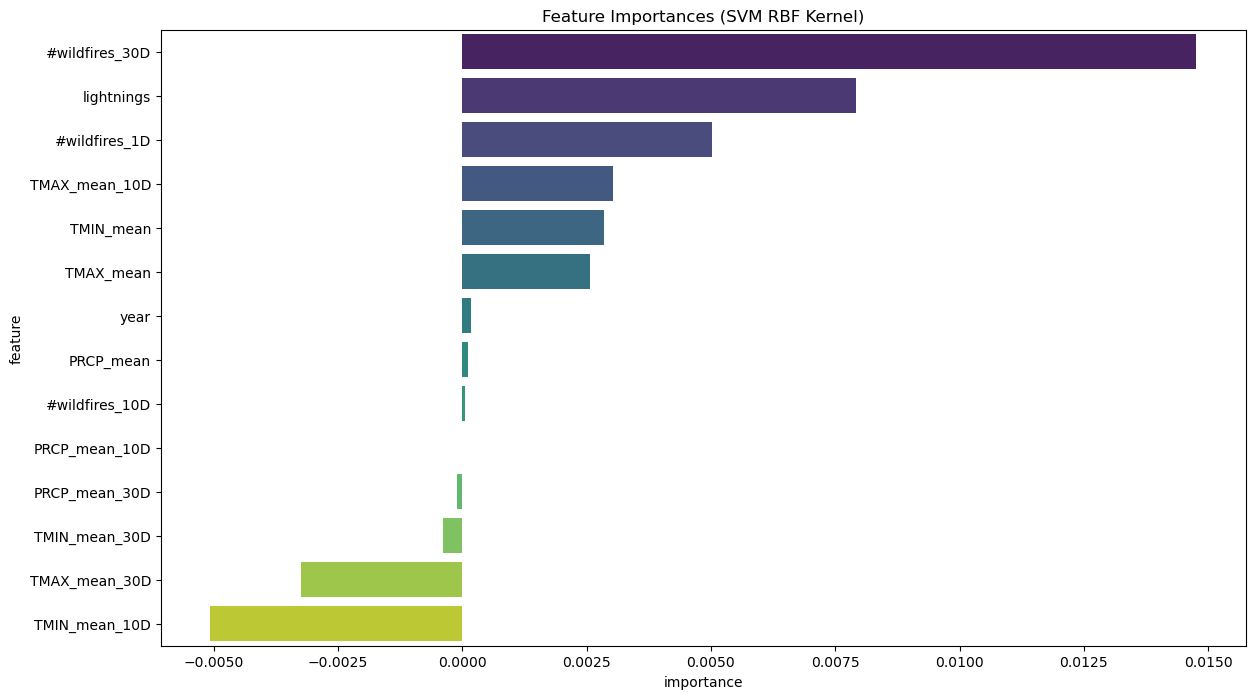


Processing Deschutes National Forest...

SVM with year:
Accuracy: 0.8090079817559863
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1288
           1       0.65      0.61      0.63       466

    accuracy                           0.81      1754
   macro avg       0.76      0.74      0.75      1754
weighted avg       0.81      0.81      0.81      1754



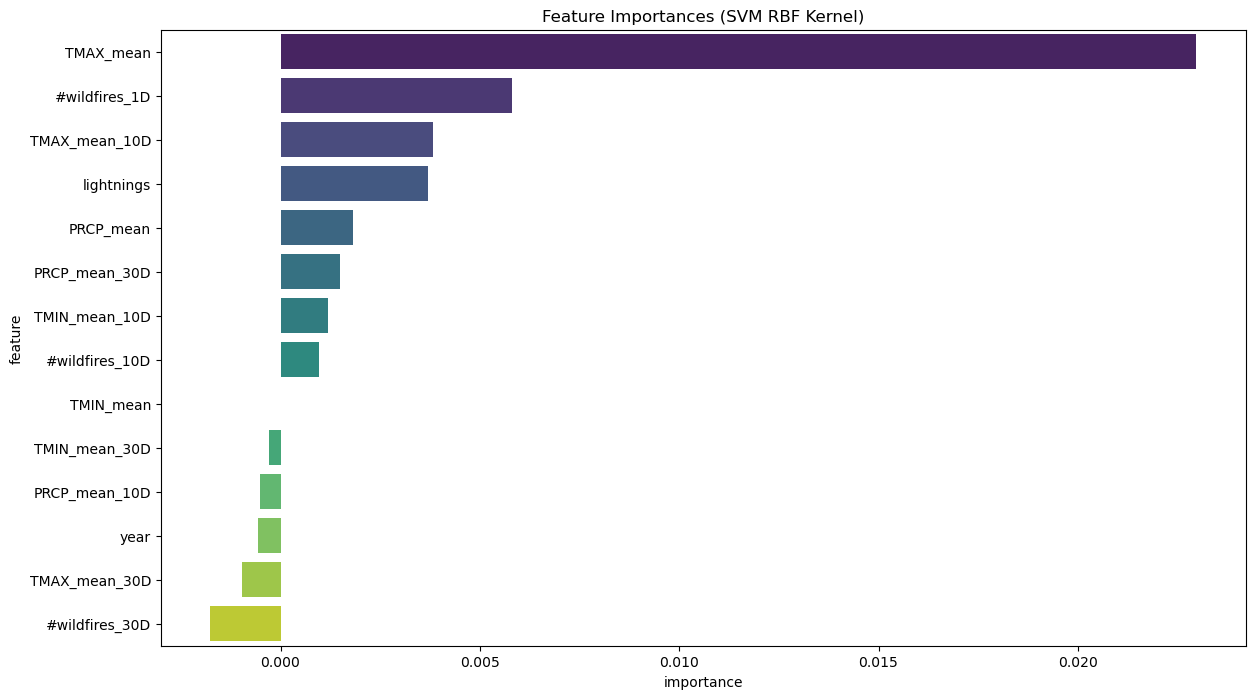


Processing Ouachita National Forest...

SVM with year:
Accuracy: 0.7879133409350056
              precision    recall  f1-score   support

           0       0.80      0.95      0.87      1277
           1       0.73      0.35      0.48       477

    accuracy                           0.79      1754
   macro avg       0.76      0.65      0.67      1754
weighted avg       0.78      0.79      0.76      1754



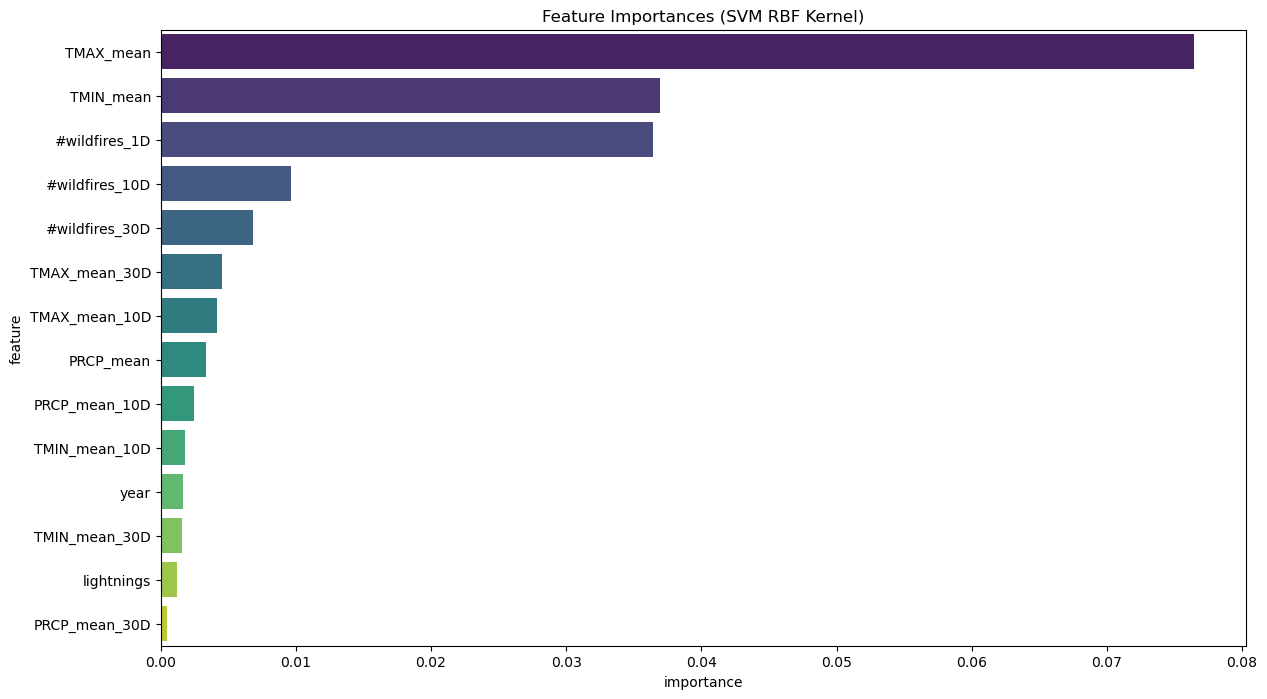


Processing Chattahoochee National Forest...

SVM with year:
Accuracy: 0.8034285714285714
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      1332
           1       0.76      0.26      0.39       418

    accuracy                           0.80      1750
   macro avg       0.78      0.62      0.64      1750
weighted avg       0.80      0.80      0.76      1750



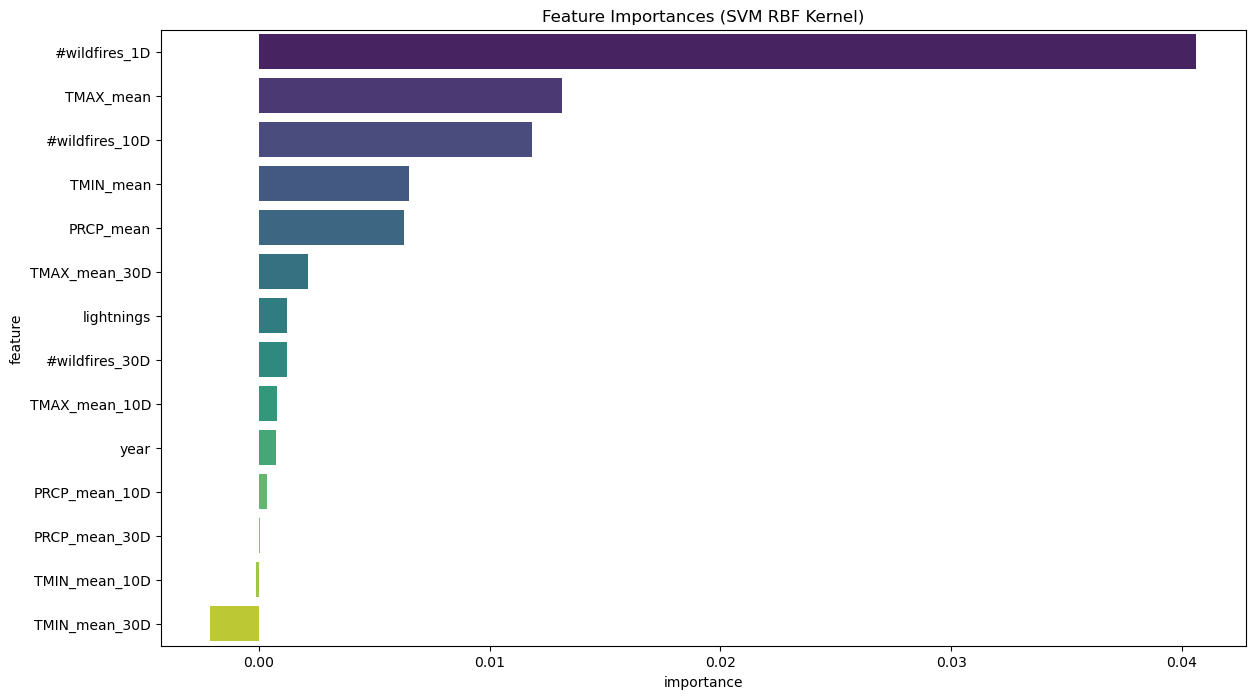


Processing Lolo National Forest...

SVM with year:
Accuracy: 0.8500570125427594
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1434
           1       0.69      0.32      0.44       320

    accuracy                           0.85      1754
   macro avg       0.78      0.64      0.68      1754
weighted avg       0.83      0.85      0.83      1754



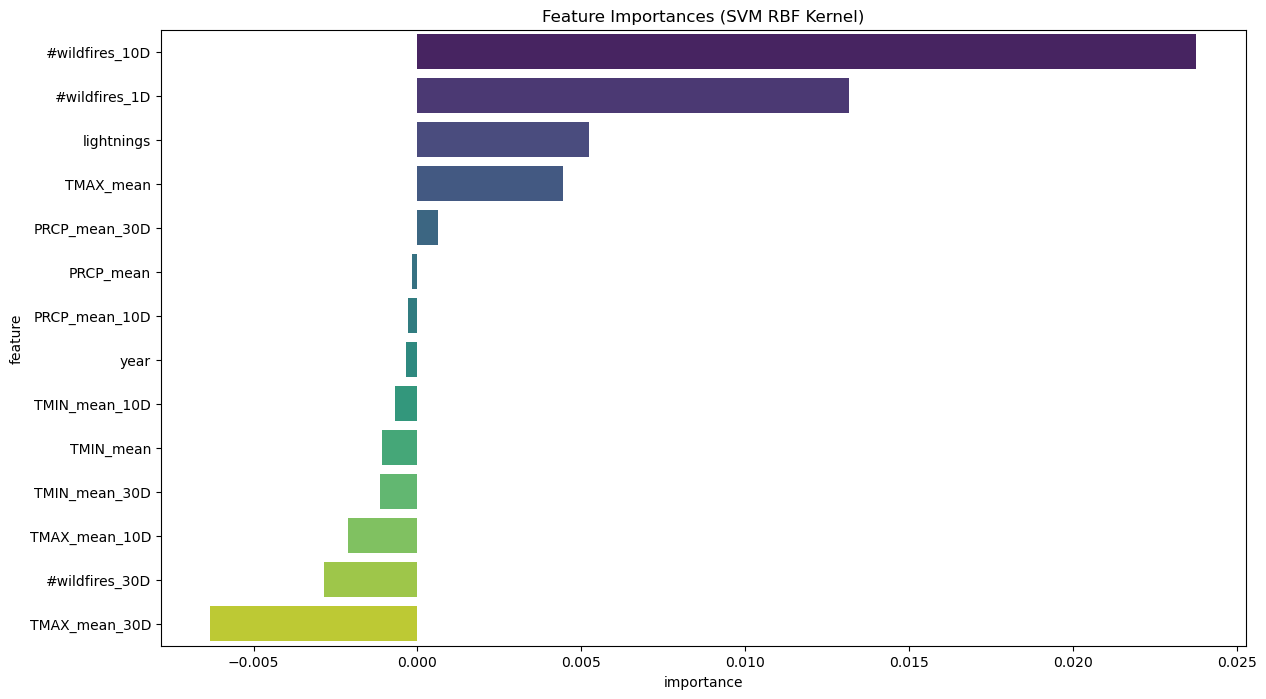


Processing De Soto National Forest...

SVM with year:
Accuracy: 0.7895037079292642
              precision    recall  f1-score   support

           0       0.79      0.98      0.88      1353
           1       0.69      0.14      0.24       400

    accuracy                           0.79      1753
   macro avg       0.74      0.56      0.56      1753
weighted avg       0.77      0.79      0.73      1753



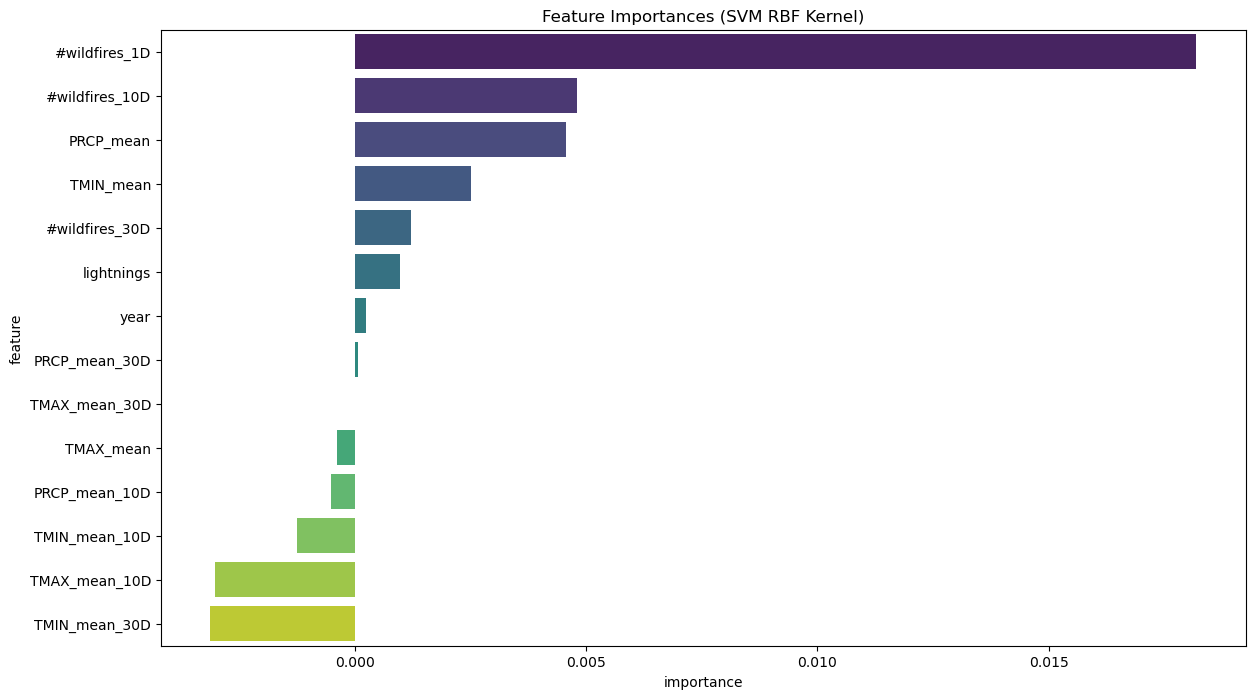

In [76]:
# Process each forest
for forest in forests:
    print(f"\nProcessing {forest}\n")
    forest_df = global_df[global_df['FORESTNAME'] == forest]
    forest_df = prepare_data(forest_df)
    process_and_train(forest_df)

## ***Gradient Boosting Classifier***

In [111]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Function to process the data and train the models
def process_and_train(df):
    # Data preparation
    X = df.drop(['date', 'target', '#wildfires'], axis=1)
    y = df['target']

    # Set numeric and circular columns
    num_cols = ['TMAX_mean', 'TMIN_mean', 'TMAX_mean_10D', 'TMAX_mean_30D', 'TMIN_mean_10D', 'TMIN_mean_30D',
                'PRCP_mean', 'PRCP_mean_10D', 'PRCP_mean_30D', 'lightnings', '#wildfires_1D', '#wildfires_10D',
                '#wildfires_30D']
    circular_cols = ['month', 'weekday']

    # Impute missing values with median
    imputer = SimpleImputer(strategy='median')
    X[num_cols] = imputer.fit_transform(X[num_cols])

    # Shift the 'weekday' values so that Monday is represented by 1
    X['weekday'] = X['weekday'] + 1

    # Create sin and cos for circular columns
    X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
    X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
    X['weekday_sin'] = np.sin(2 * np.pi * X['weekday'] / 7)
    X['weekday_cos'] = np.cos(2 * np.pi * X['weekday'] / 7)

    # Drop original circular columns
    #X = X.drop(columns=circular_cols)

    # Standardize the features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train a Gradient Boosting Classifier
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Evaluate the model performance
    print("Gradient Boosting Classifier:")
    print("Accuracy:", accuracy)
    print(classification_report(y_test, y_pred))

    # Plot feature importances
    importances = model.feature_importances_
    feature_names = X_train.columns
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
    
    # Remove sin and cos columns from the feature importances
    feature_importances = feature_importances[~feature_importances['feature'].isin(['month_sin', 'month_cos', 'weekday_sin', 'weekday_cos'])]
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(14, 8))
    sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')
    plt.title('Feature Importances (Gradient Boosting)')
    plt.show()



Processing Coconino National Forest

Gradient Boosting Classifier:
Accuracy: 0.7850627137970353
              precision    recall  f1-score   support

           0       0.81      0.86      0.84      1107
           1       0.74      0.65      0.69       647

    accuracy                           0.79      1754
   macro avg       0.77      0.76      0.76      1754
weighted avg       0.78      0.79      0.78      1754



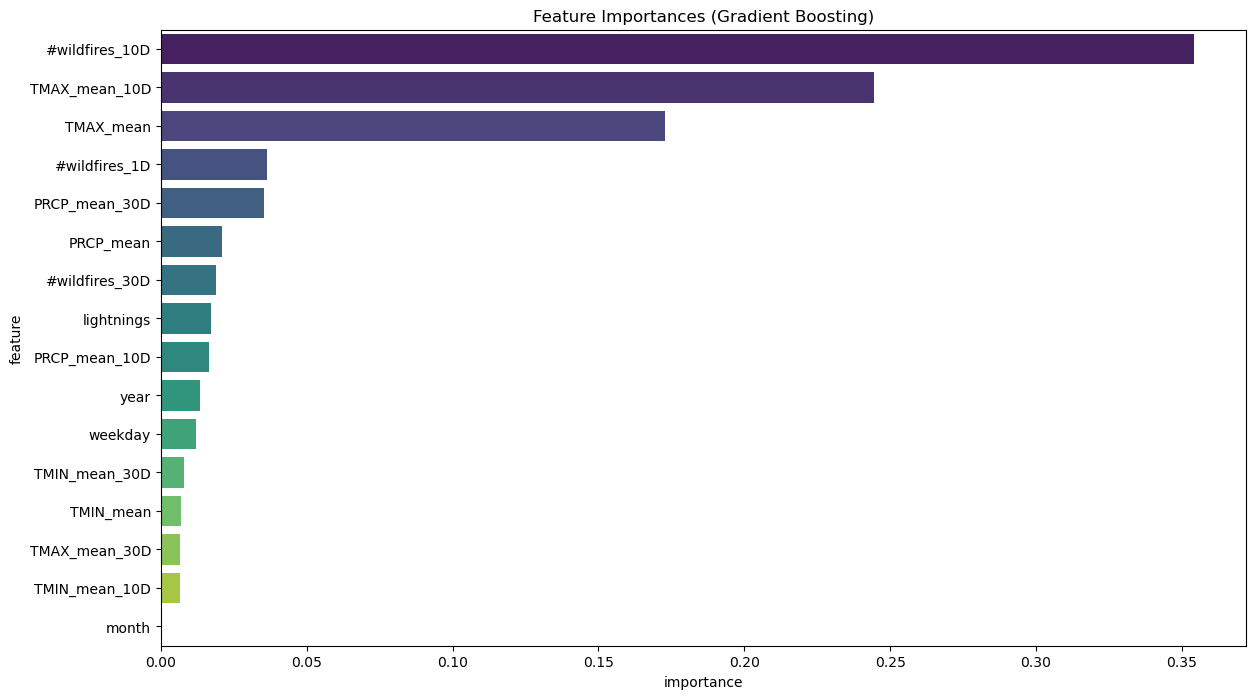


Processing Tonto National Forest

Gradient Boosting Classifier:
Accuracy: 0.7776510832383124
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1215
           1       0.68      0.53      0.59       539

    accuracy                           0.78      1754
   macro avg       0.74      0.71      0.72      1754
weighted avg       0.77      0.78      0.77      1754



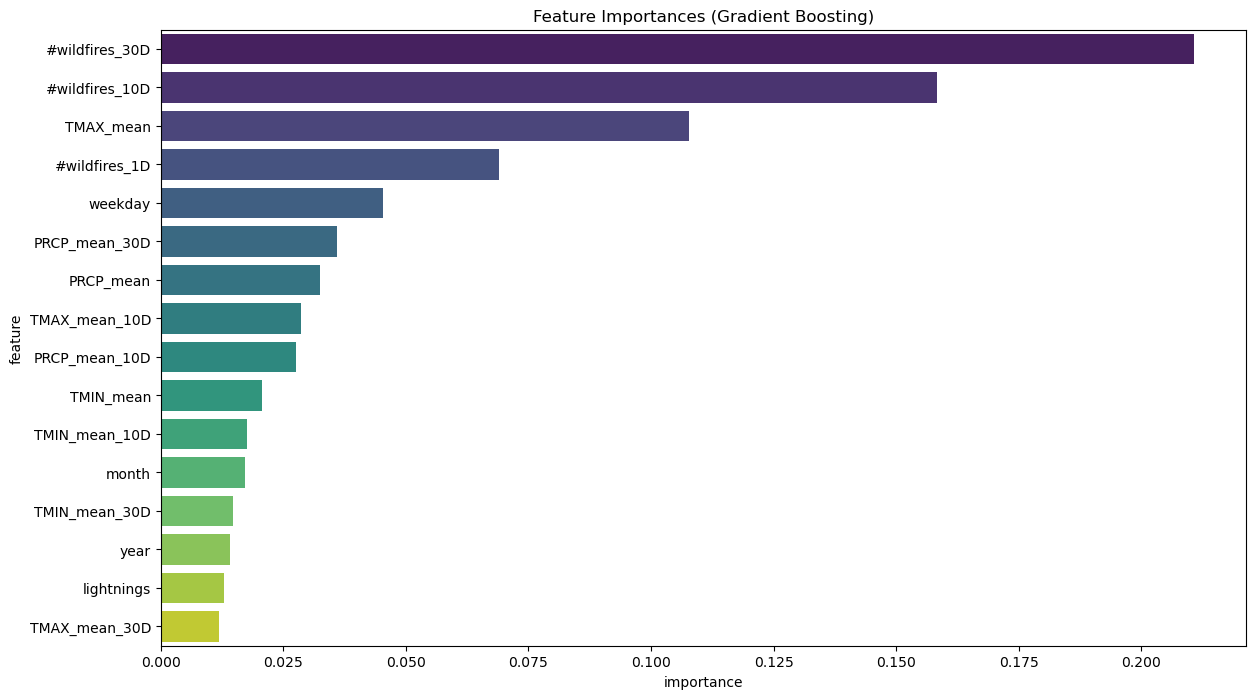


Processing San Bernardino National Forest

Gradient Boosting Classifier:
Accuracy: 0.7565564424173318
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1266
           1       0.60      0.37      0.46       488

    accuracy                           0.76      1754
   macro avg       0.69      0.64      0.65      1754
weighted avg       0.74      0.76      0.74      1754



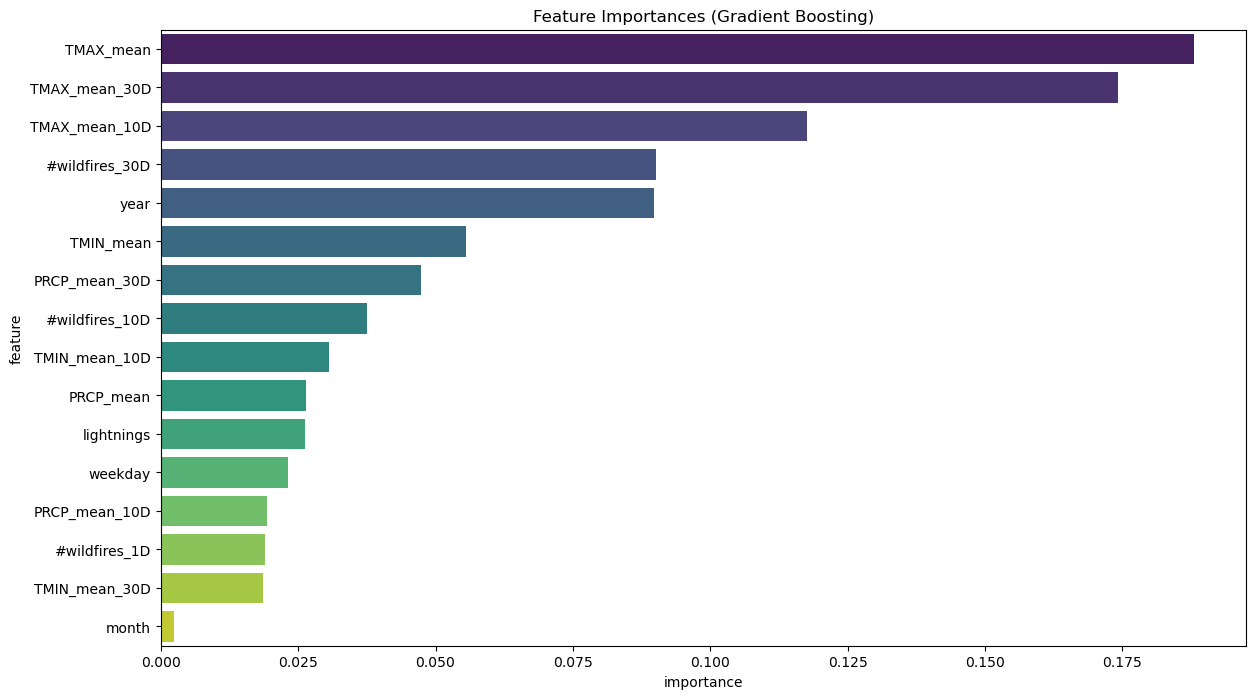


Processing Deschutes National Forest

Gradient Boosting Classifier:
Accuracy: 0.8078677309007982
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1288
           1       0.65      0.60      0.62       466

    accuracy                           0.81      1754
   macro avg       0.75      0.74      0.75      1754
weighted avg       0.80      0.81      0.81      1754



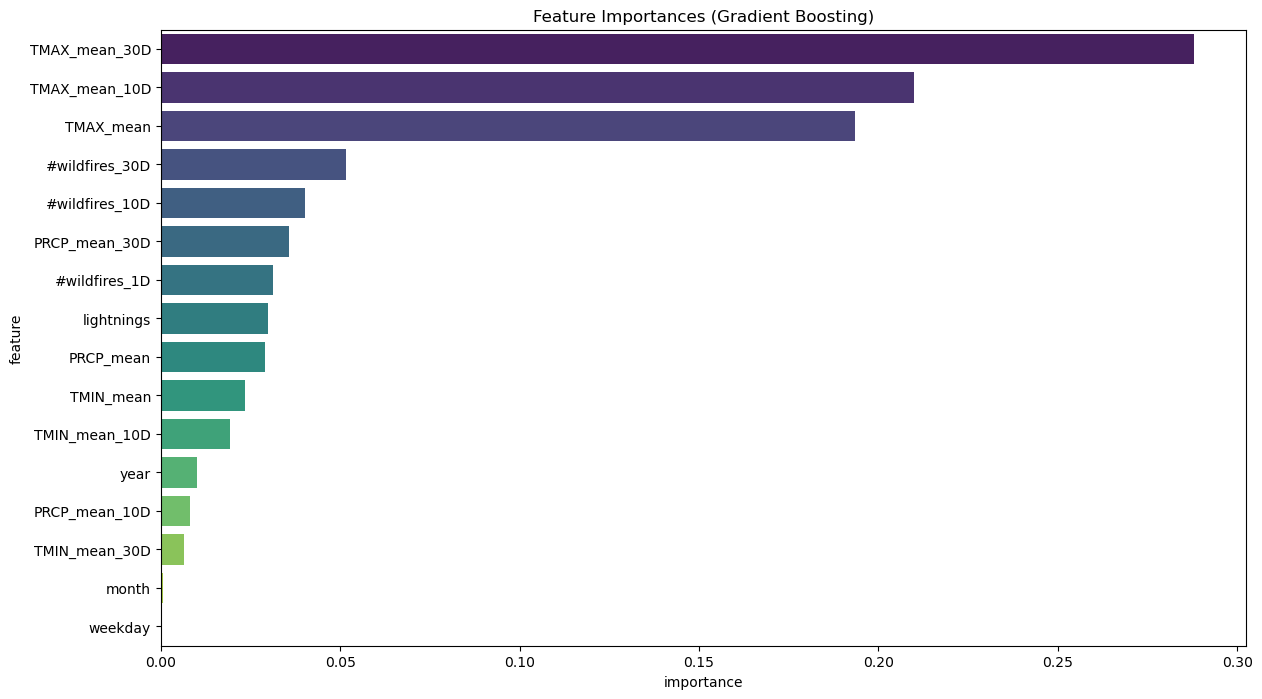


Processing Ouachita National Forest

Gradient Boosting Classifier:
Accuracy: 0.7879133409350056
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1277
           1       0.66      0.46      0.54       477

    accuracy                           0.79      1754
   macro avg       0.74      0.68      0.70      1754
weighted avg       0.77      0.79      0.77      1754



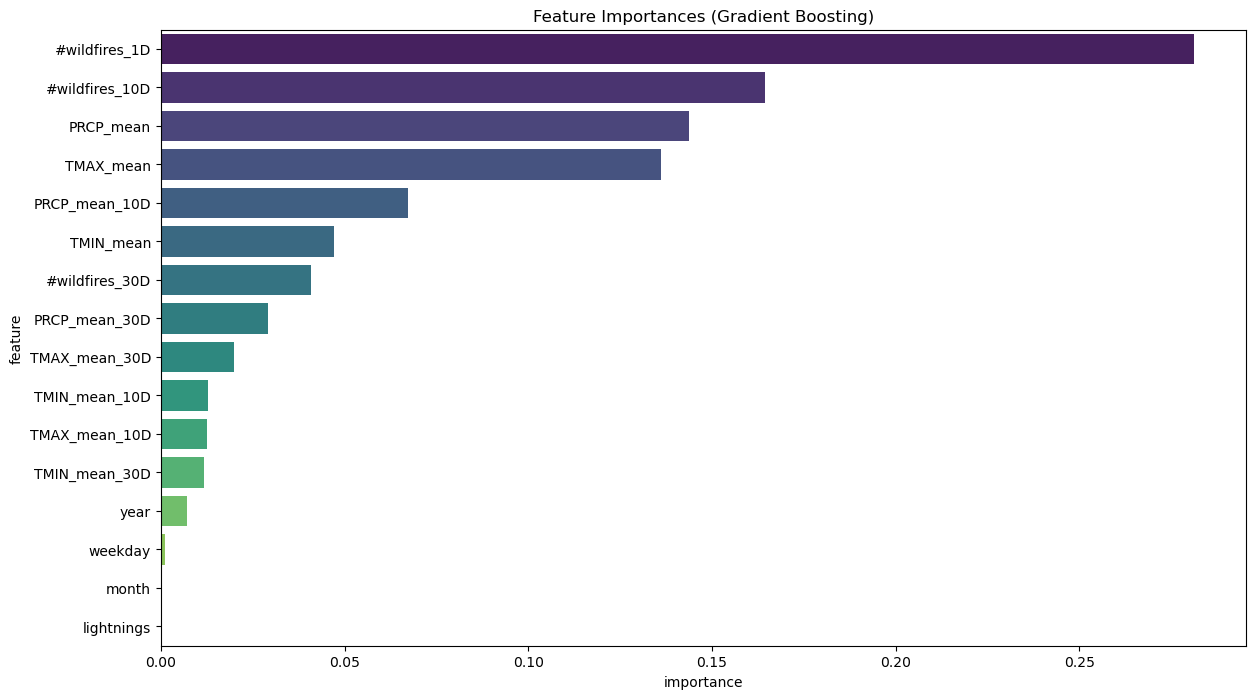


Processing Chattahoochee National Forest

Gradient Boosting Classifier:
Accuracy: 0.8314285714285714
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1332
           1       0.74      0.45      0.56       418

    accuracy                           0.83      1750
   macro avg       0.79      0.70      0.73      1750
weighted avg       0.82      0.83      0.82      1750



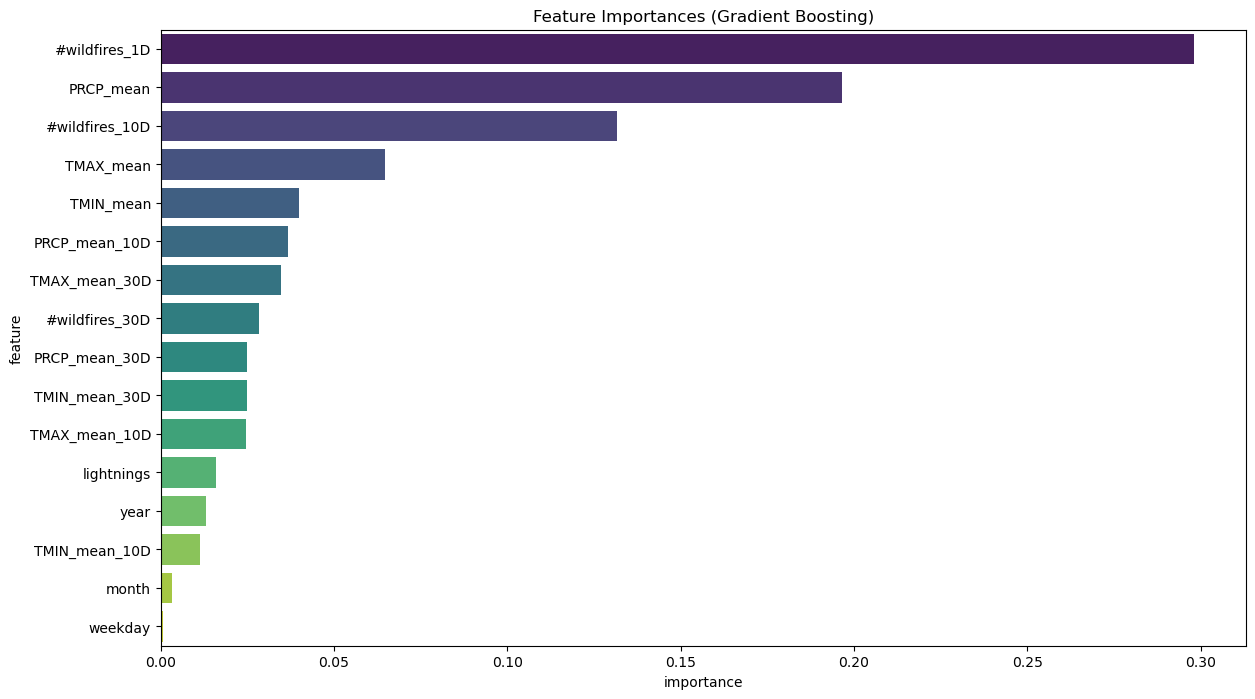


Processing Lolo National Forest

Gradient Boosting Classifier:
Accuracy: 0.8643101482326112
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1434
           1       0.67      0.50      0.57       320

    accuracy                           0.86      1754
   macro avg       0.78      0.72      0.75      1754
weighted avg       0.85      0.86      0.86      1754



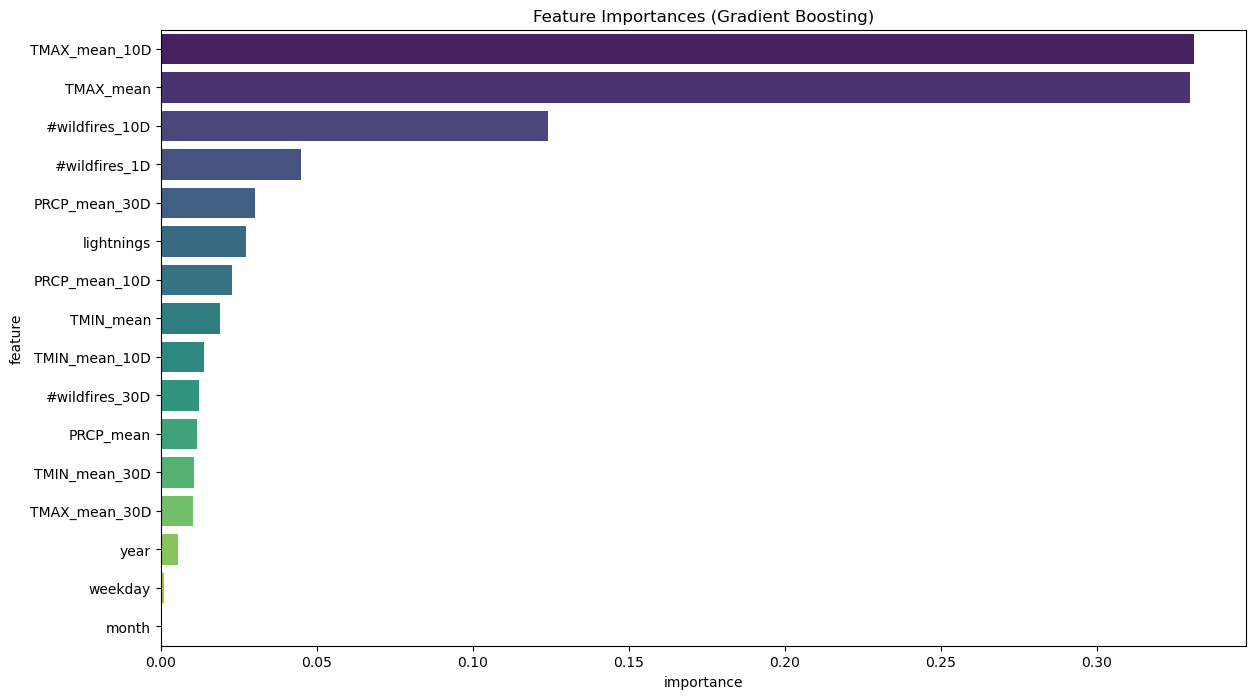


Processing De Soto National Forest

Gradient Boosting Classifier:
Accuracy: 0.8009127210496292
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1353
           1       0.61      0.35      0.44       400

    accuracy                           0.80      1753
   macro avg       0.72      0.64      0.66      1753
weighted avg       0.78      0.80      0.78      1753



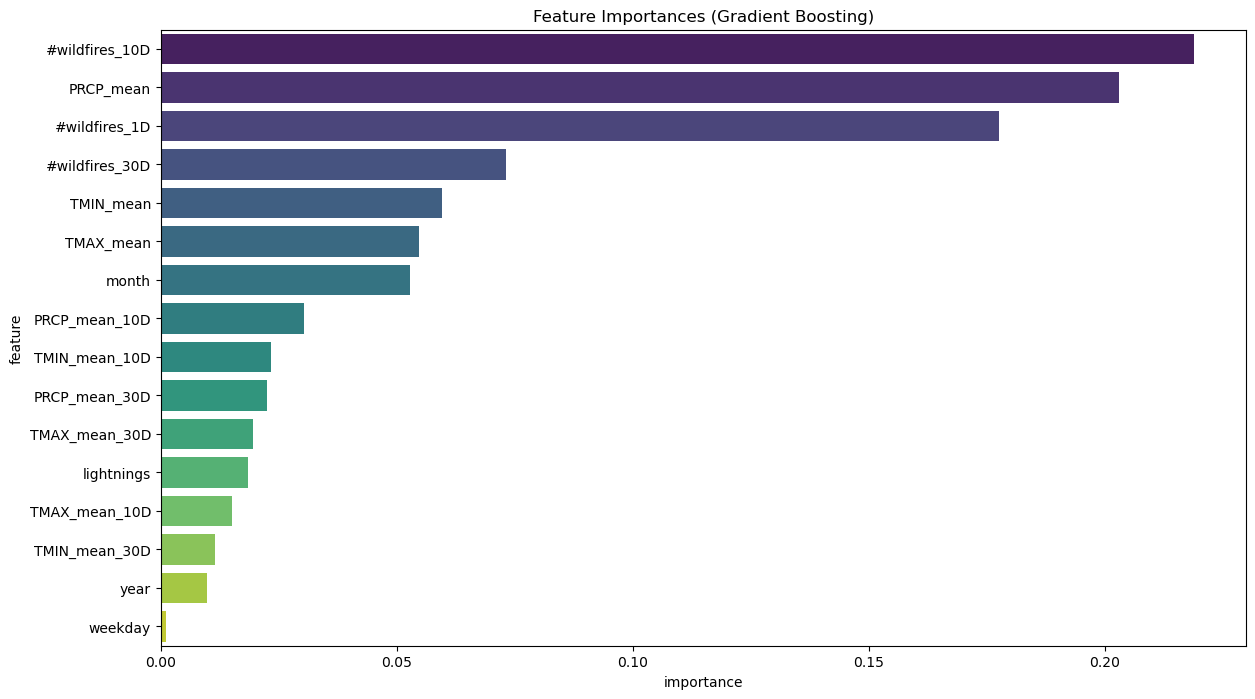

In [112]:
# Process each forest
for forest in forests:
    print(f"\nProcessing {forest}\n")
    forest_df = global_df[global_df['FORESTNAME'] == forest]
    forest_df = prepare_data(forest_df)
    process_and_train(forest_df)

## ***Random Forest Classifier + SMOTE***

In [109]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Function to process the data and train the model
def process_and_train(df):
    # Data preparation
    X = df.drop(['date', 'target', '#wildfires'], axis=1)
    y = df['target']

    # Set numeric columns
    num_cols = ['TMAX_mean', 'TMIN_mean', 'TMAX_mean_10D', 'TMAX_mean_30D', 'TMIN_mean_10D', 'TMIN_mean_30D', 
                'PRCP_mean', 'PRCP_mean_10D', 'PRCP_mean_30D', 'lightnings', '#wildfires_1D', '#wildfires_10D', 
                '#wildfires_30D']
    circular_cols = ['month', 'weekday']
    
    # Impute missing values with median
    imputer = SimpleImputer(strategy='median')
    X[num_cols] = imputer.fit_transform(X[num_cols])

    # Shift the 'weekday' values ​​so that Monday is represented by 1
    X['weekday'] = X['weekday'] + 1
           
    # Create sin and cos for circular columns
    X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
    X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
    X['weekday_sin'] = np.sin(2 * np.pi * X['weekday'] / 7)
    X['weekday_cos'] = np.cos(2 * np.pi * X['weekday'] / 7)

    # Drop original circular columns
    #X = X.drop(columns=circular_cols)
    
    # Standardize the features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    # Train a Random Forest Classifier model
    model = RandomForestClassifier(n_estimators=200, max_features=4, max_depth=None, random_state=42)
    model.fit(X_train_smote, y_train_smote)
    y_pred_smote = model.predict(X_test)
    accuracy_smote = accuracy_score(y_test, y_pred_smote)

    # Evaluate the model performance
    print("Random Forest Classifier with smote:") 
    print("Accuracy_smote :", accuracy_smote)
    print(classification_report(y_test, y_pred_smote))

    # Plot feature importances
    importances = model.feature_importances_
    feature_names = X_train_smote.columns
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
    
    # Remove sin and cos columns from the feature importances
    feature_importances = feature_importances[~feature_importances['feature'].isin(['month_sin', 'month_cos', 'weekday_sin', 'weekday_cos'])]
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(14, 8))
    sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')
    plt.title('Feature Importances with smote')
    plt.show()
  


Processing Coconino National Forest

Random Forest Classifier with smote:
Accuracy_smote : 0.7839224629418472
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1107
           1       0.71      0.70      0.71       647

    accuracy                           0.78      1754
   macro avg       0.77      0.77      0.77      1754
weighted avg       0.78      0.78      0.78      1754



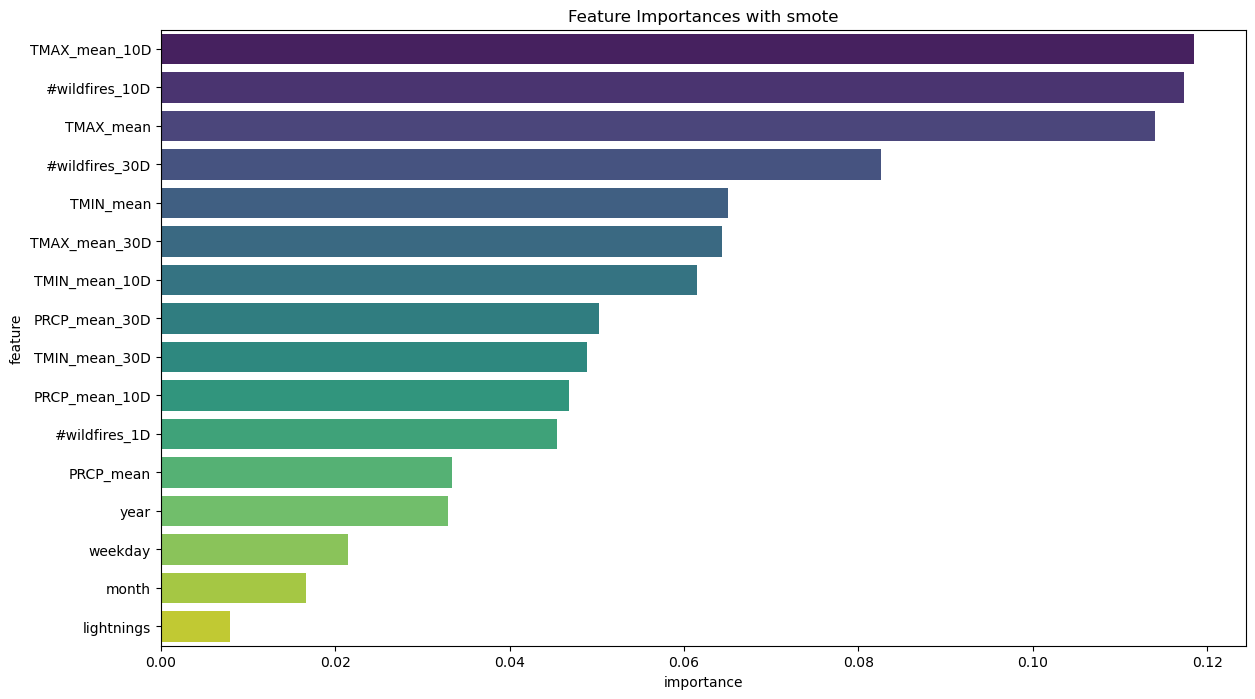


Processing Tonto National Forest

Random Forest Classifier with smote:
Accuracy_smote : 0.7554161915621437
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1215
           1       0.60      0.59      0.60       539

    accuracy                           0.76      1754
   macro avg       0.71      0.71      0.71      1754
weighted avg       0.75      0.76      0.75      1754



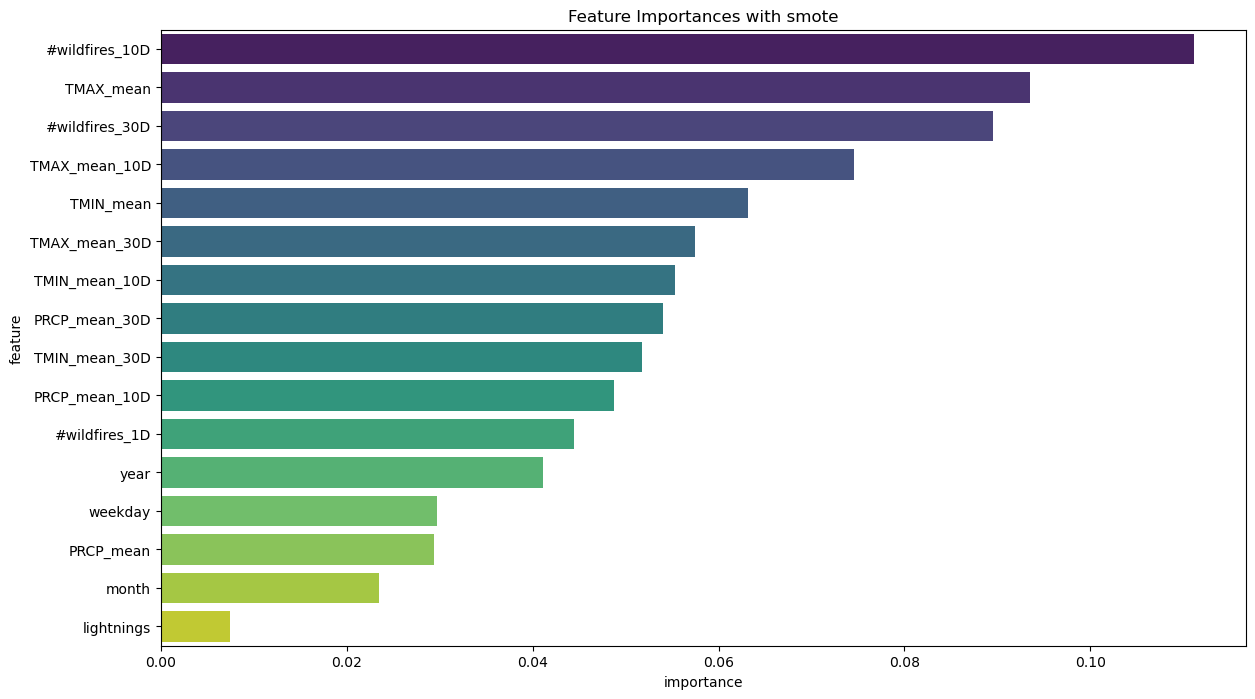


Processing San Bernardino National Forest

Random Forest Classifier with smote:
Accuracy_smote : 0.7183580387685291
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1266
           1       0.49      0.49      0.49       488

    accuracy                           0.72      1754
   macro avg       0.65      0.65      0.65      1754
weighted avg       0.72      0.72      0.72      1754



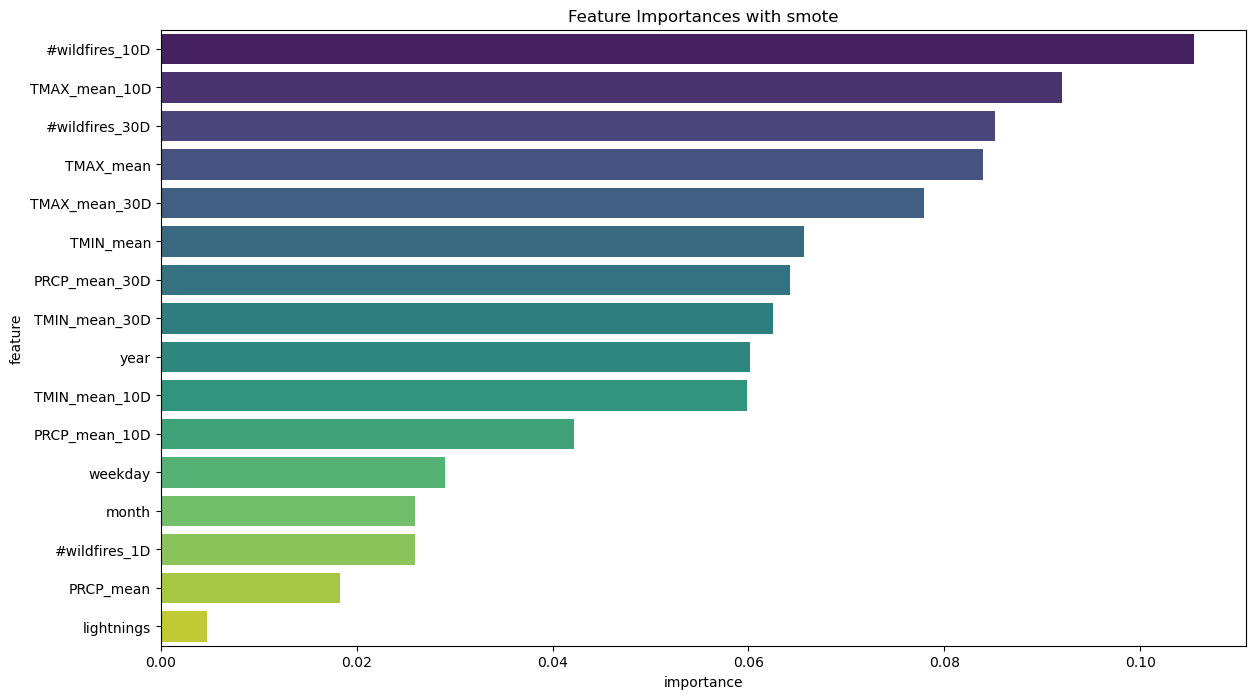


Processing Deschutes National Forest

Random Forest Classifier with smote:
Accuracy_smote : 0.7884834663625998
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1288
           1       0.59      0.70      0.64       466

    accuracy                           0.79      1754
   macro avg       0.73      0.76      0.74      1754
weighted avg       0.80      0.79      0.79      1754



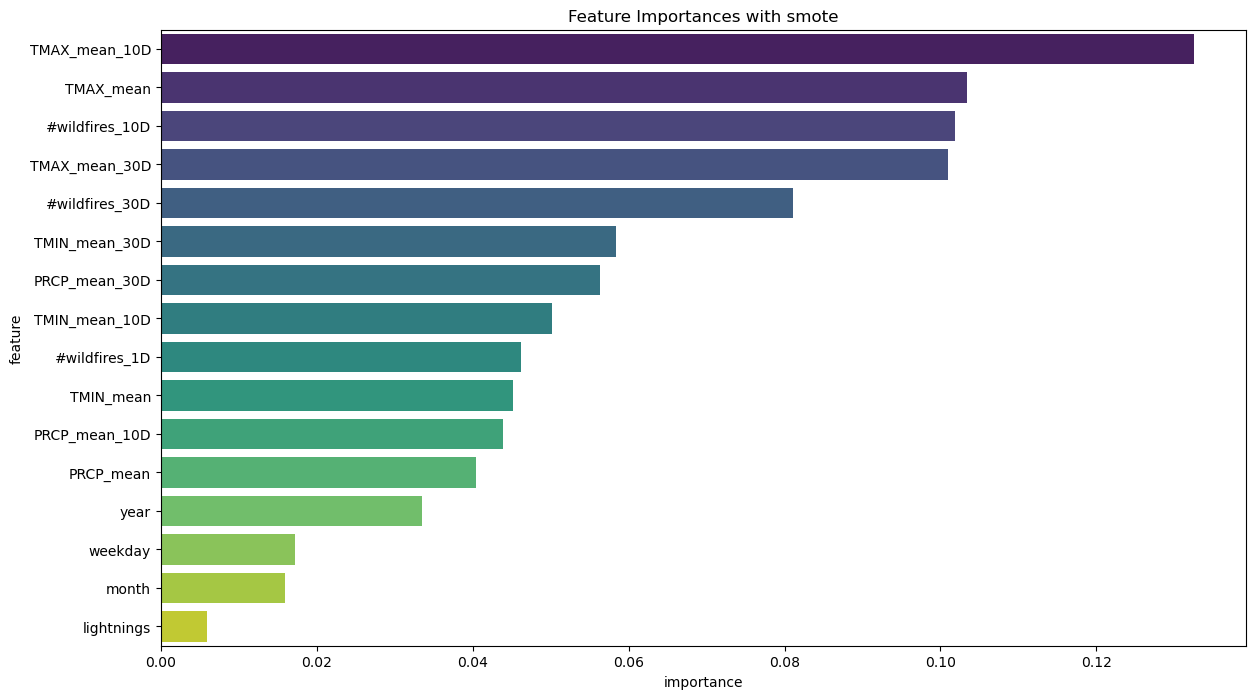


Processing Ouachita National Forest

Random Forest Classifier with smote:
Accuracy_smote : 0.7639680729760547
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1277
           1       0.57      0.55      0.56       477

    accuracy                           0.76      1754
   macro avg       0.70      0.70      0.70      1754
weighted avg       0.76      0.76      0.76      1754



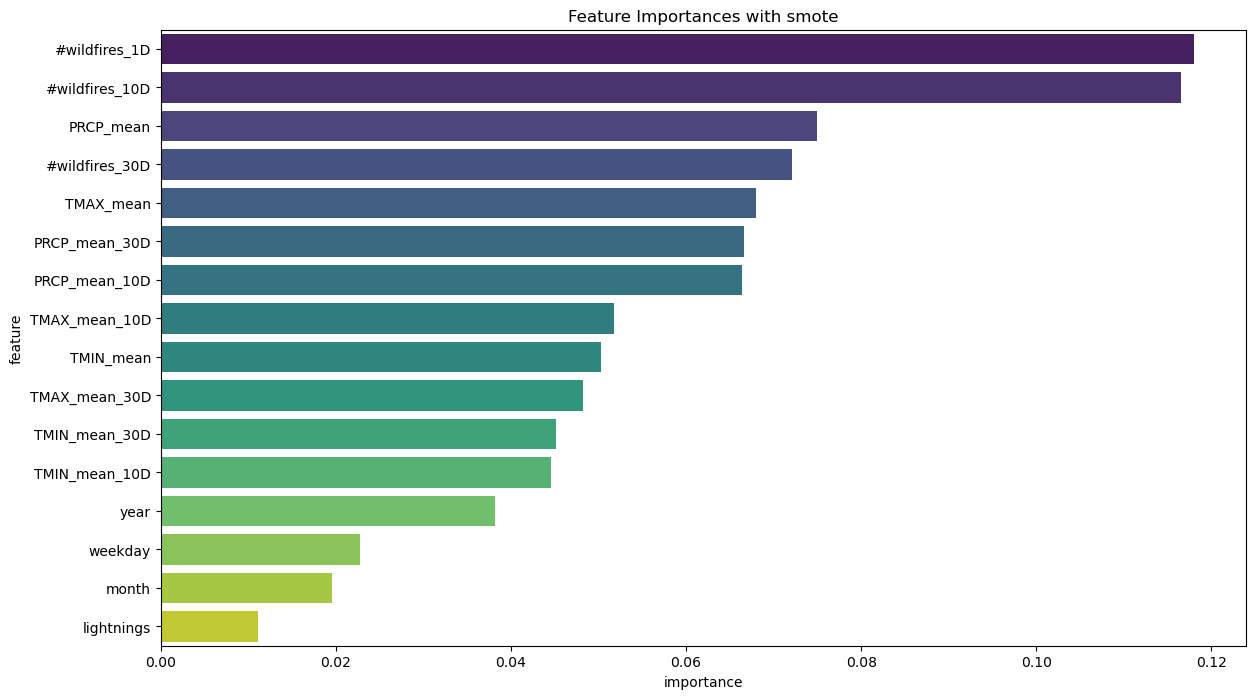


Processing Chattahoochee National Forest

Random Forest Classifier with smote:
Accuracy_smote : 0.8028571428571428
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      1332
           1       0.60      0.54      0.57       418

    accuracy                           0.80      1750
   macro avg       0.73      0.71      0.72      1750
weighted avg       0.80      0.80      0.80      1750



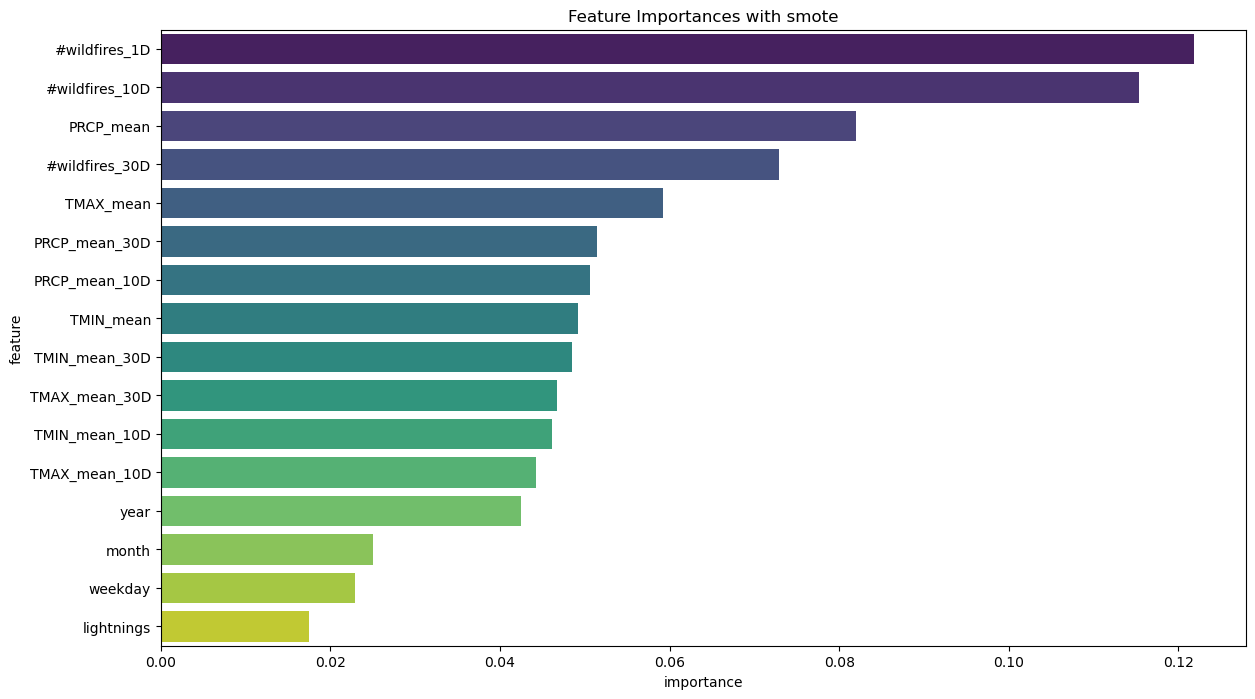


Processing Lolo National Forest

Random Forest Classifier with smote:
Accuracy_smote : 0.8392246294184721
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1434
           1       0.56      0.55      0.55       320

    accuracy                           0.84      1754
   macro avg       0.73      0.73      0.73      1754
weighted avg       0.84      0.84      0.84      1754



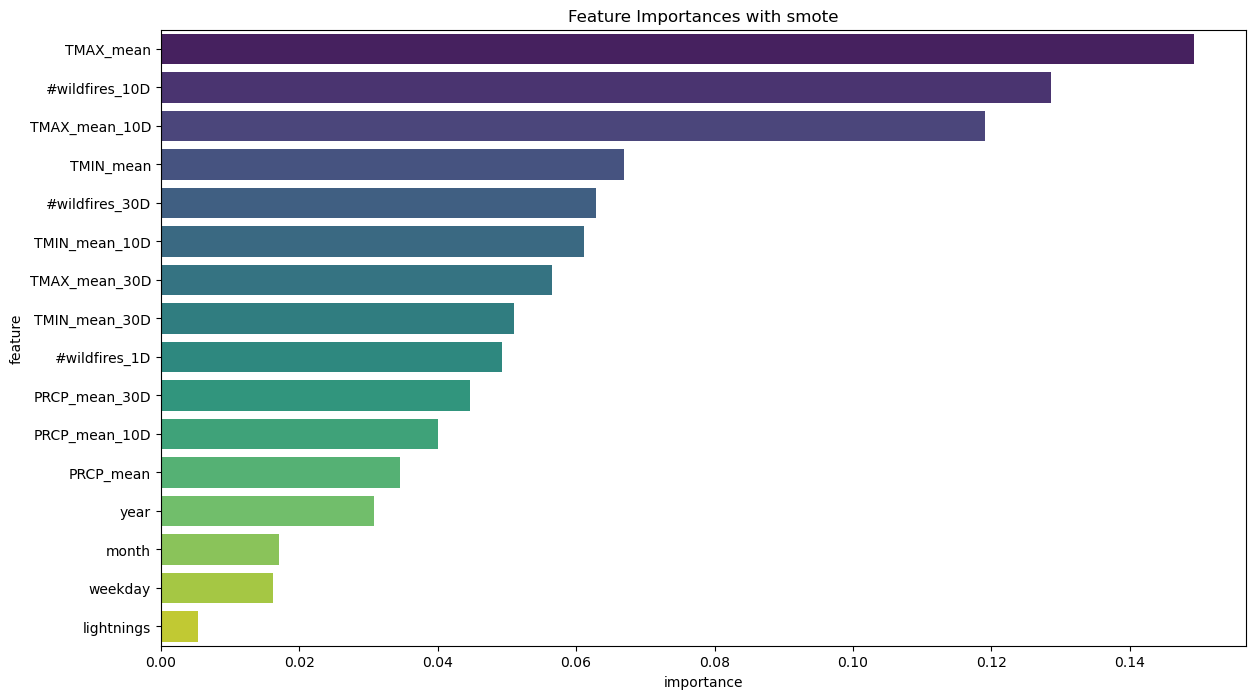


Processing De Soto National Forest

Random Forest Classifier with smote:
Accuracy_smote : 0.7877923559612093
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1353
           1       0.54      0.47      0.50       400

    accuracy                           0.79      1753
   macro avg       0.69      0.68      0.68      1753
weighted avg       0.78      0.79      0.78      1753



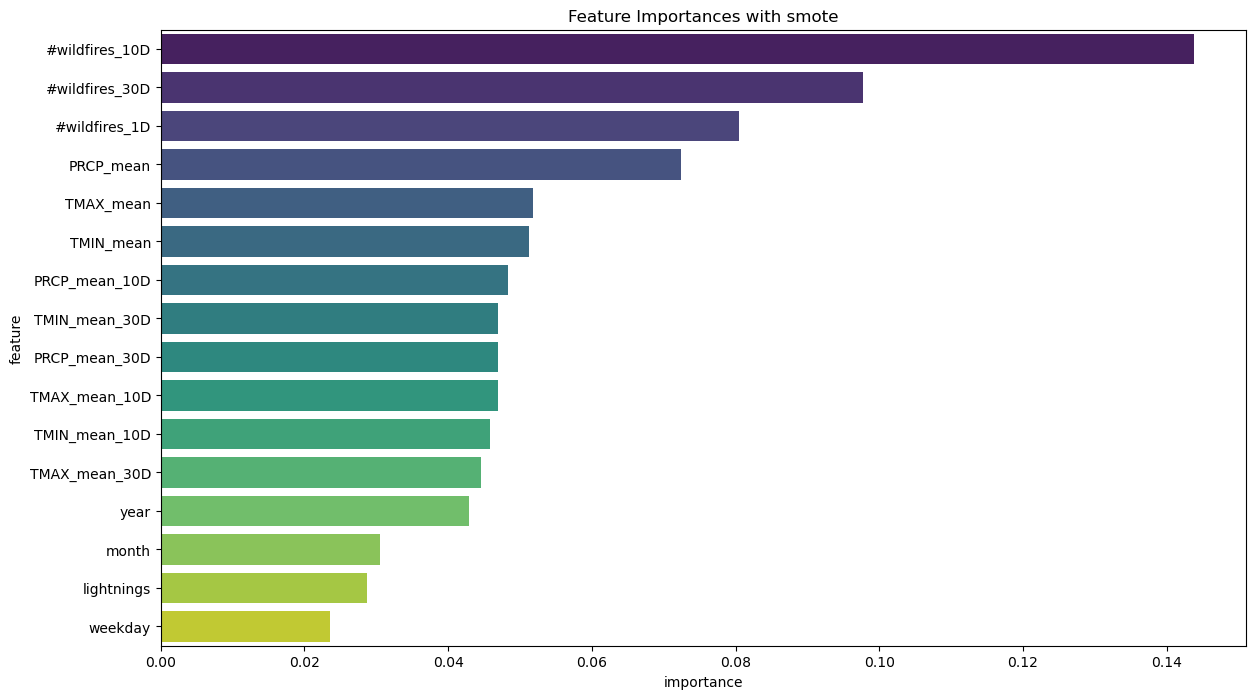

In [110]:
# Process each forest
for forest in forests:
    print(f"\nProcessing {forest}\n")
    forest_df = global_df[global_df['FORESTNAME'] == forest]
    forest_df = prepare_data(forest_df)
    process_and_train(forest_df)

## ***Logistic Regression + SMOTE***

In [107]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

# Function to process the data and train the models
def process_and_train(df):
    # Data preparation
    X = df.drop(['date', 'target', '#wildfires'], axis=1)
    y = df['target']

    # Set numeric and circular columns
    num_cols = ['TMAX_mean', 'TMIN_mean', 'TMAX_mean_10D', 'TMAX_mean_30D', 'TMIN_mean_10D', 'TMIN_mean_30D',
                'PRCP_mean', 'PRCP_mean_10D', 'PRCP_mean_30D', 'lightnings', '#wildfires_1D', '#wildfires_10D',
                '#wildfires_30D']
    circular_cols = ['month', 'weekday']

    # Impute missing values with median
    imputer = SimpleImputer(strategy='median')
    X[num_cols] = imputer.fit_transform(X[num_cols])

    # Shift the 'weekday' values so that Monday is represented by 1
    X['weekday'] = X['weekday'] + 1
           
    # Create sin and cos for circular columns
    X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
    X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
    X['weekday_sin'] = np.sin(2 * np.pi * X['weekday'] / 7)
    X['weekday_cos'] = np.cos(2 * np.pi * X['weekday'] / 7)

    # Drop original circular columns
    #X = X.drop(columns=circular_cols)

    # Standardize the features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    # Train a Logistic Regression model
    model = LogisticRegression(penalty='l2', C=1.0)
    model.fit(X_train_smote, y_train_smote)
    y_pred_smote = model.predict(X_test)
    accuracy_smote = accuracy_score(y_test, y_pred_smote)

    # Evaluate the model performance
    print("Logistic Regression with smote:")
    print("Accuracy_smote:", accuracy_smote)
    print(classification_report(y_test, y_pred_smote))

    # Plot feature importances (coefficients)
    coefficients = model.coef_[0]
    feature_names = X_train_smote.columns
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': coefficients})

    # Remove sin and cos columns from the feature importances
    feature_importances = feature_importances[~feature_importances['feature'].isin(['month_sin', 'month_cos', 'weekday_sin', 'weekday_cos'])]
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(14, 8))
    sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')
    plt.title('Feature Importances (Logistic Regression Coefficients with smote)')
    plt.show()
    


Processing Coconino National Forest

Logistic Regression with smote:
Accuracy_smote: 0.7679589509692132
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1107
           1       0.67      0.73      0.70       647

    accuracy                           0.77      1754
   macro avg       0.75      0.76      0.76      1754
weighted avg       0.77      0.77      0.77      1754



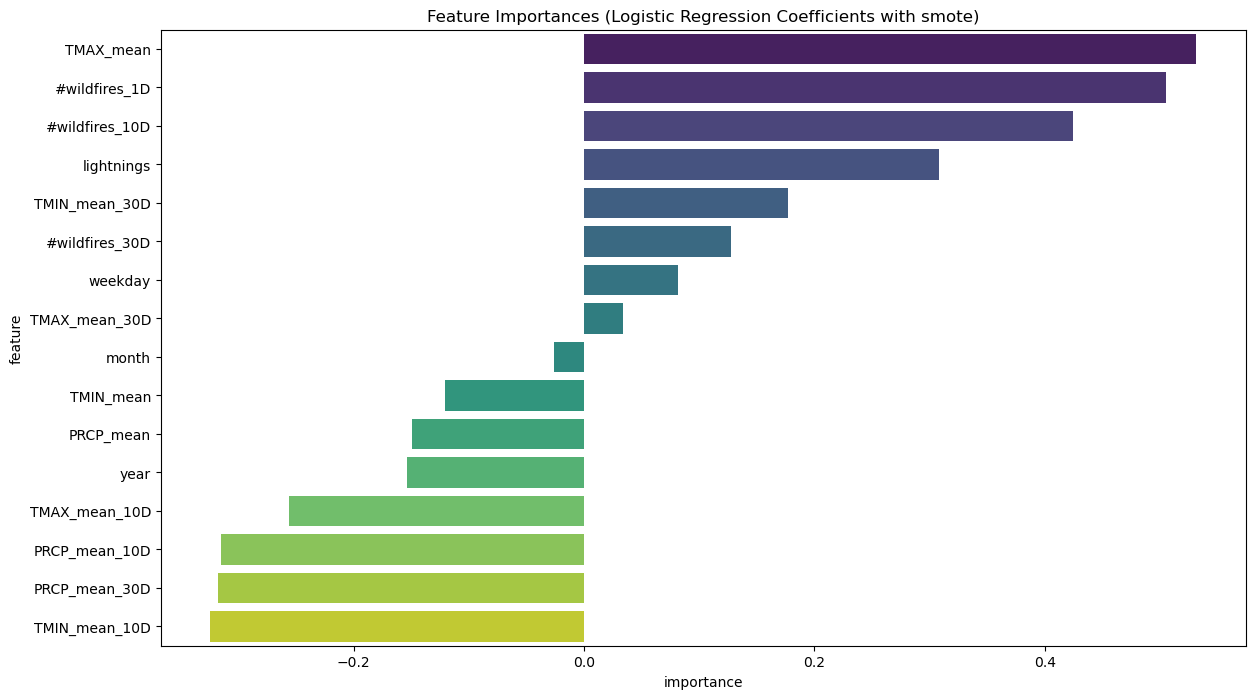


Processing Tonto National Forest

Logistic Regression with smote:
Accuracy_smote: 0.7309007981755986
              precision    recall  f1-score   support

           0       0.85      0.74      0.79      1215
           1       0.55      0.71      0.62       539

    accuracy                           0.73      1754
   macro avg       0.70      0.72      0.71      1754
weighted avg       0.76      0.73      0.74      1754



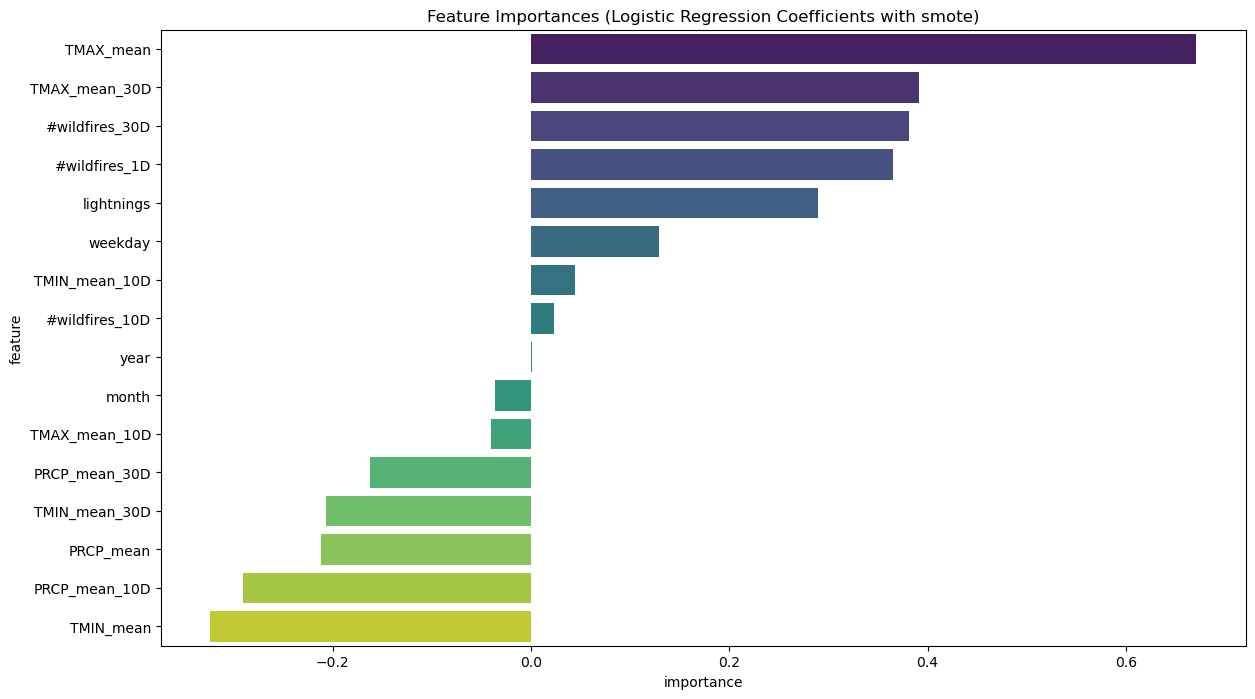


Processing San Bernardino National Forest

Logistic Regression with smote:
Accuracy_smote: 0.6966932725199544
              precision    recall  f1-score   support

           0       0.87      0.69      0.77      1266
           1       0.47      0.72      0.57       488

    accuracy                           0.70      1754
   macro avg       0.67      0.70      0.67      1754
weighted avg       0.76      0.70      0.71      1754



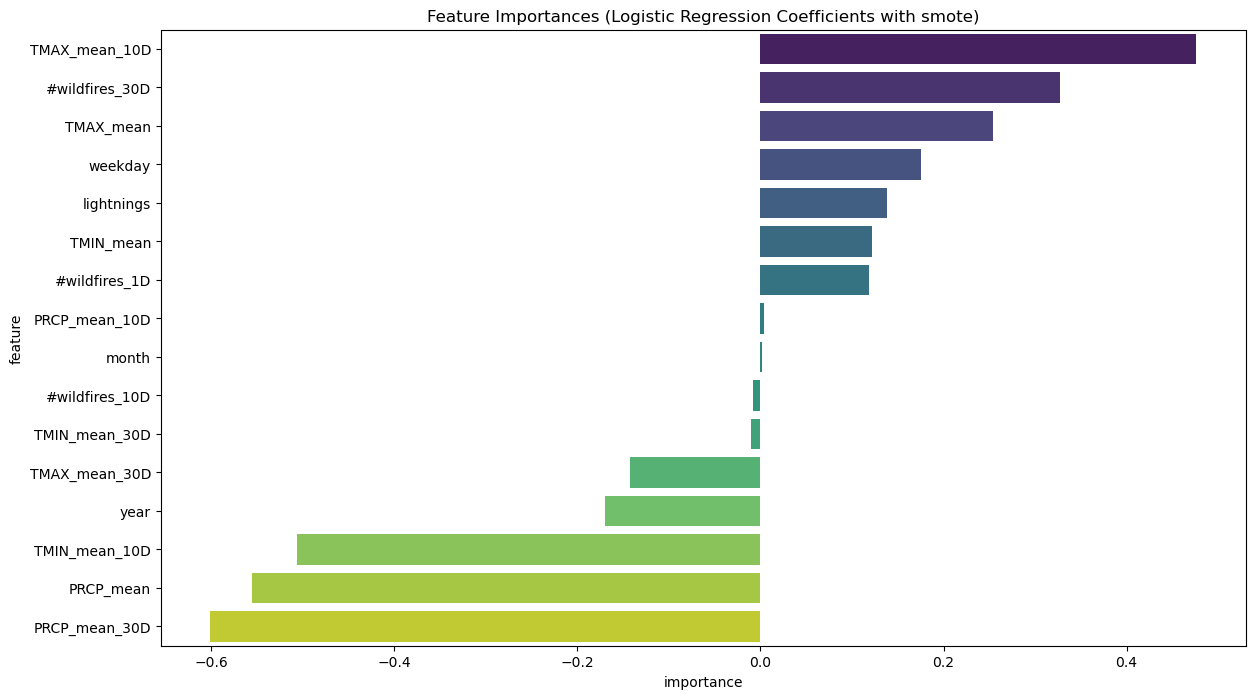


Processing Deschutes National Forest

Logistic Regression with smote:
Accuracy_smote: 0.7702394526795895
              precision    recall  f1-score   support

           0       0.92      0.76      0.83      1288
           1       0.55      0.81      0.65       466

    accuracy                           0.77      1754
   macro avg       0.73      0.78      0.74      1754
weighted avg       0.82      0.77      0.78      1754



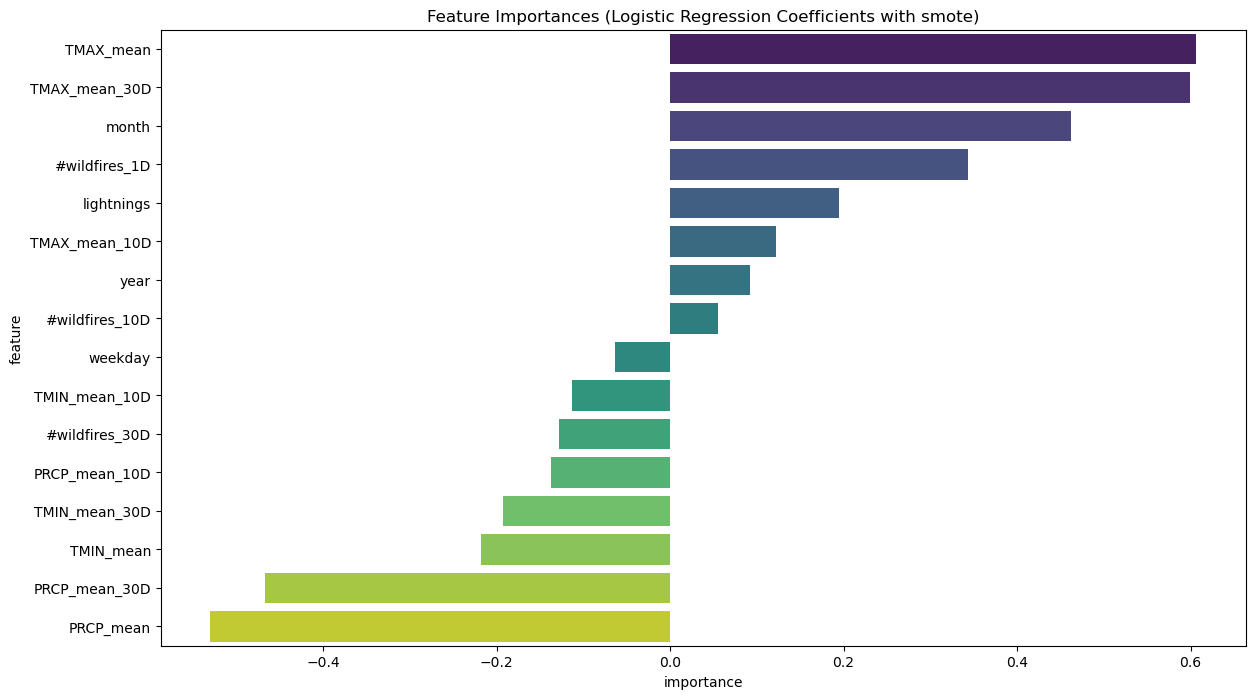


Processing Ouachita National Forest

Logistic Regression with smote:
Accuracy_smote: 0.7331812998859749
              precision    recall  f1-score   support

           0       0.87      0.74      0.80      1277
           1       0.51      0.71      0.59       477

    accuracy                           0.73      1754
   macro avg       0.69      0.73      0.70      1754
weighted avg       0.77      0.73      0.74      1754



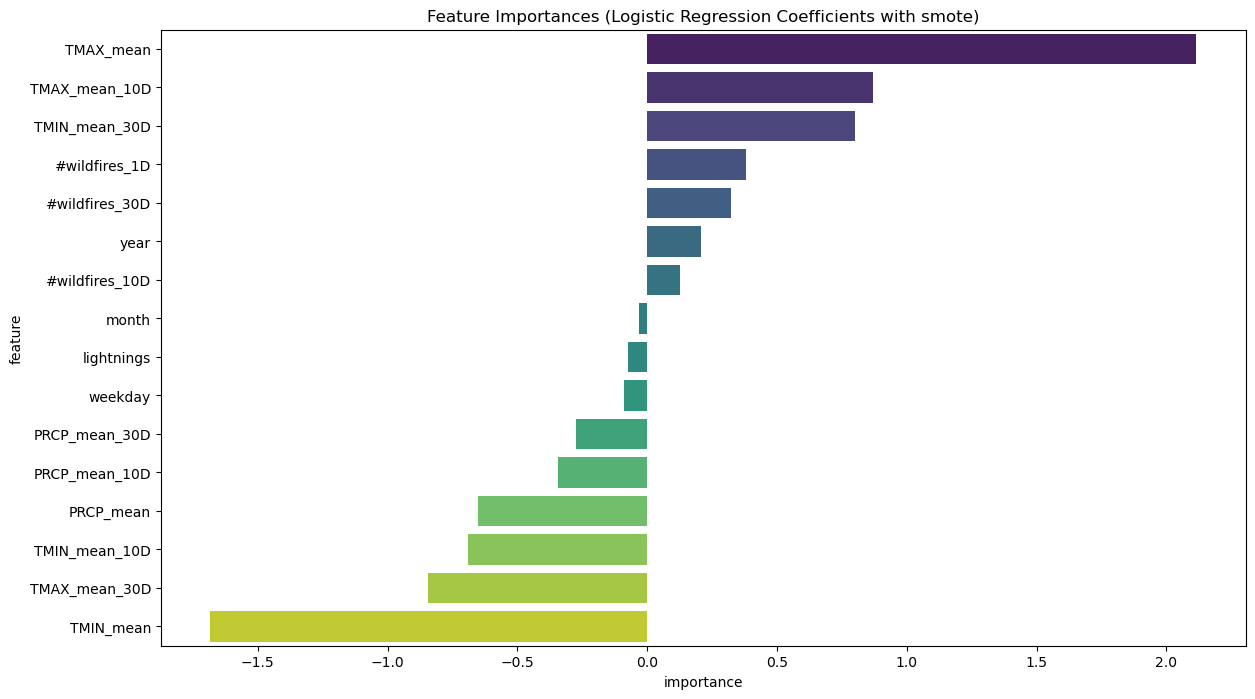


Processing Chattahoochee National Forest

Logistic Regression with smote:
Accuracy_smote: 0.7451428571428571
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1332
           1       0.48      0.75      0.59       418

    accuracy                           0.75      1750
   macro avg       0.69      0.75      0.70      1750
weighted avg       0.80      0.75      0.76      1750



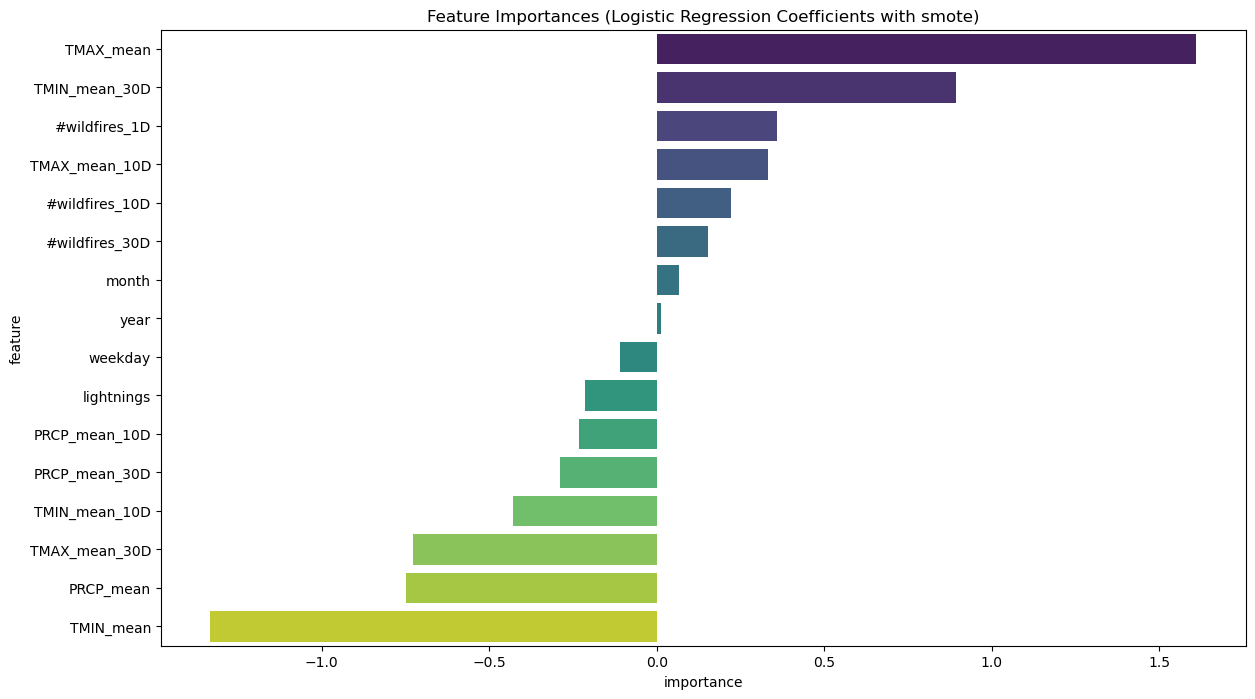


Processing Lolo National Forest

Logistic Regression with smote:
Accuracy_smote: 0.7873432155074116
              precision    recall  f1-score   support

           0       0.94      0.79      0.86      1434
           1       0.45      0.76      0.57       320

    accuracy                           0.79      1754
   macro avg       0.69      0.78      0.71      1754
weighted avg       0.85      0.79      0.81      1754



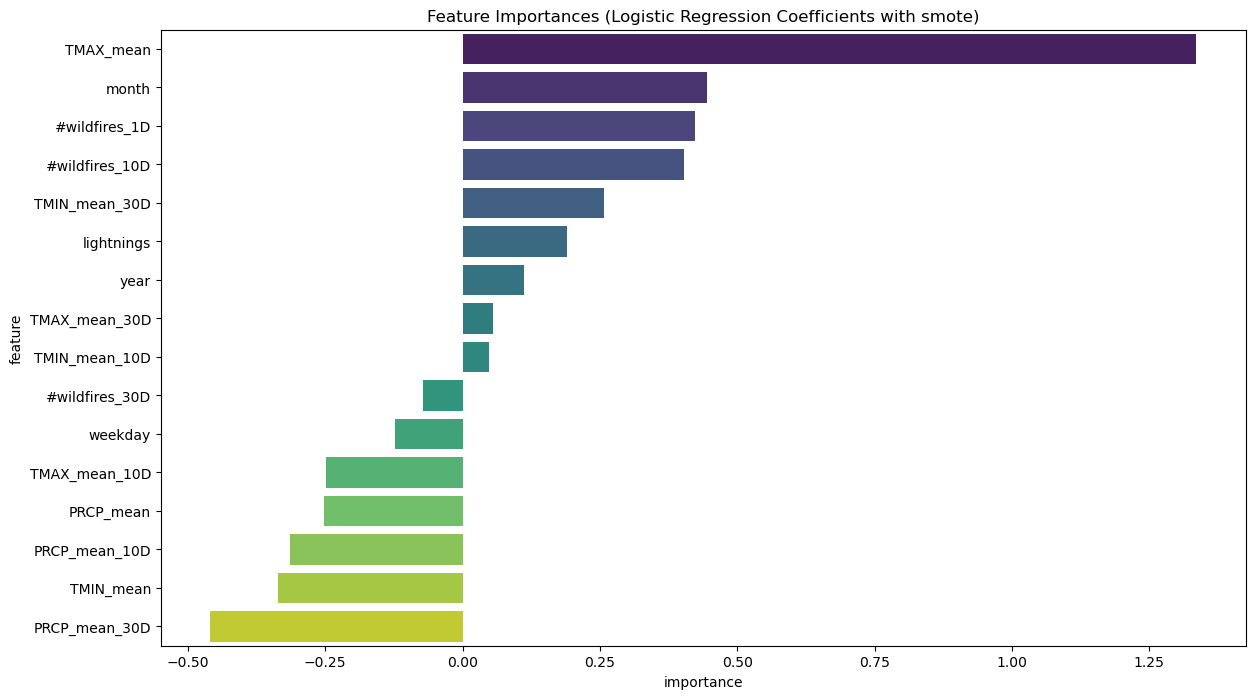


Processing De Soto National Forest

Logistic Regression with smote:
Accuracy_smote: 0.728465487735311
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1353
           1       0.44      0.72      0.55       400

    accuracy                           0.73      1753
   macro avg       0.67      0.72      0.68      1753
weighted avg       0.79      0.73      0.75      1753



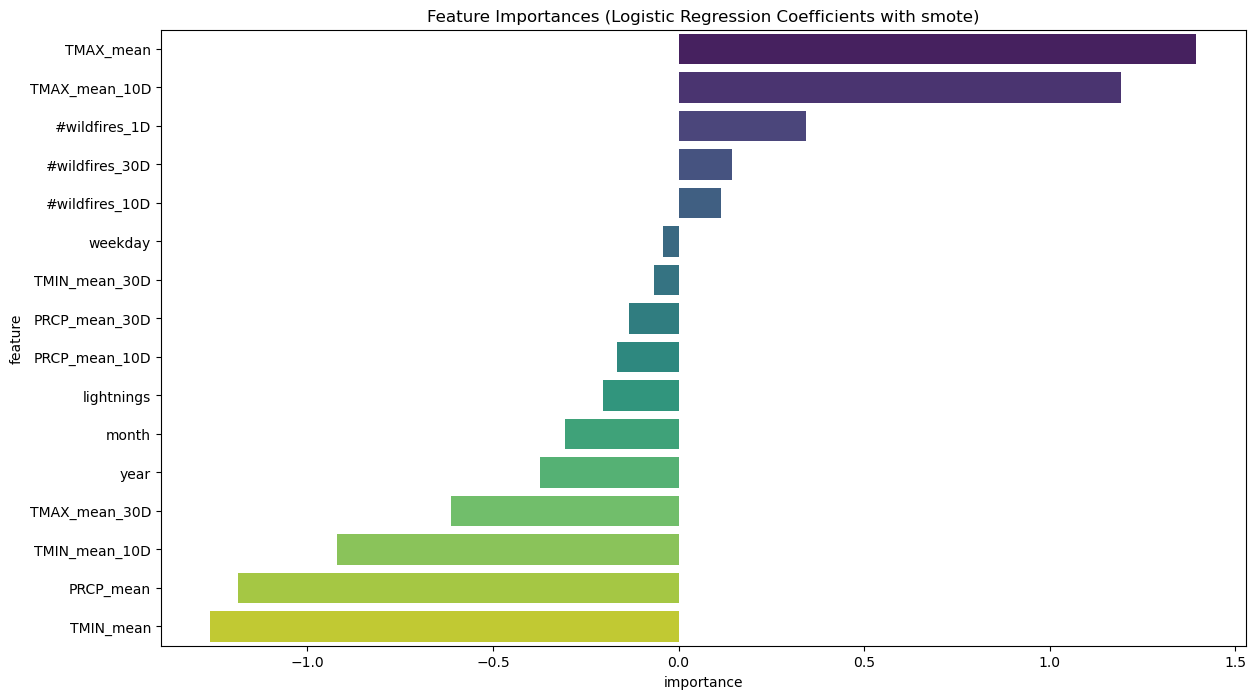

In [108]:
# Process each forest
for forest in forests:
    print(f"\nProcessing {forest}\n")
    forest_df = global_df[global_df['FORESTNAME'] == forest]
    forest_df = prepare_data(forest_df)
    process_and_train(forest_df)

## ***Multi Layer Perceptron + SMOTE***

In [105]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

# Function to process the data and train the models
def process_and_train(df):
    # Data preparation
    X = df.drop(['date', 'target', '#wildfires'], axis=1)
    y = df['target']

    # Set numeric and circular columns
    num_cols = ['TMAX_mean', 'TMIN_mean', 'TMAX_mean_10D', 'TMAX_mean_30D', 'TMIN_mean_10D', 'TMIN_mean_30D',
                'PRCP_mean', 'PRCP_mean_10D', 'PRCP_mean_30D', 'lightnings', '#wildfires_1D', '#wildfires_10D',
                '#wildfires_30D']
    circular_cols = ['month', 'weekday']

    # Impute missing values with median
    imputer = SimpleImputer(strategy='median')
    X[num_cols] = imputer.fit_transform(X[num_cols])

    # Shift the 'weekday' values so that Monday is represented by 1
    X['weekday'] = X['weekday'] + 1
           
    # Create sin and cos for circular columns
    X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
    X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
    X['weekday_sin'] = np.sin(2 * np.pi * X['weekday'] / 7)
    X['weekday_cos'] = np.cos(2 * np.pi * X['weekday'] / 7)

    # Drop original circular columns
    #X = X.drop(columns=circular_cols)

    # Standardize the features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    # Train an MLPClassifier
    model = MLPClassifier(hidden_layer_sizes=(50,), activation='identity', alpha=0.005,
                                    learning_rate='adaptive', solver='sgd', random_state=42, max_iter=1000)
    model.fit(X_train_smote, y_train_smote)
    y_pred_smote = model.predict(X_test)
    accuracy_smote = accuracy_score(y_test, y_pred_smote)

    # Evaluate the model performance
    print("MLP Classifier with smote:")
    print("Accuracy_smote:", accuracy_smote)
    print(classification_report(y_test, y_pred_smote))

    # Plot feature importances (using the weights of the first hidden layer)
    coefs = model.coefs_[0]  # Coefficients of the first hidden layer
    feature_names = X_train_smote.columns
    importances = np.mean(np.abs(coefs), axis=1)  # Mean absolute weights

    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

    # Remove sin and cos columns from the feature importances
    feature_importances = feature_importances[~feature_importances['feature'].isin(['month_sin', 'month_cos', 'weekday_sin', 'weekday_cos'])]
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(14, 8))
    sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')
    plt.title('Feature Importances (MLP Weights with smote)')
    plt.show()



Processing Coconino National Forest

MLP Classifier with smote:
Accuracy_smote: 0.7696693272519954
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1107
           1       0.67      0.73      0.70       647

    accuracy                           0.77      1754
   macro avg       0.75      0.76      0.76      1754
weighted avg       0.77      0.77      0.77      1754



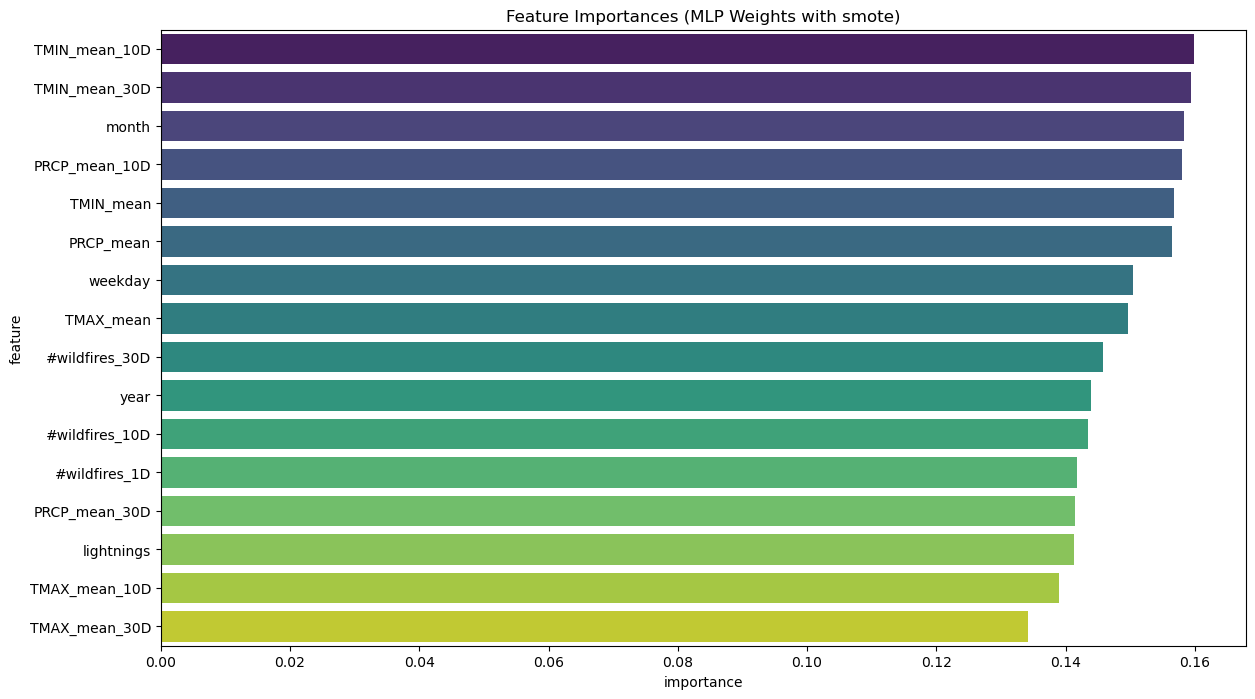


Processing Tonto National Forest

MLP Classifier with smote:
Accuracy_smote: 0.7309007981755986
              precision    recall  f1-score   support

           0       0.85      0.74      0.79      1215
           1       0.55      0.71      0.62       539

    accuracy                           0.73      1754
   macro avg       0.70      0.72      0.70      1754
weighted avg       0.76      0.73      0.74      1754



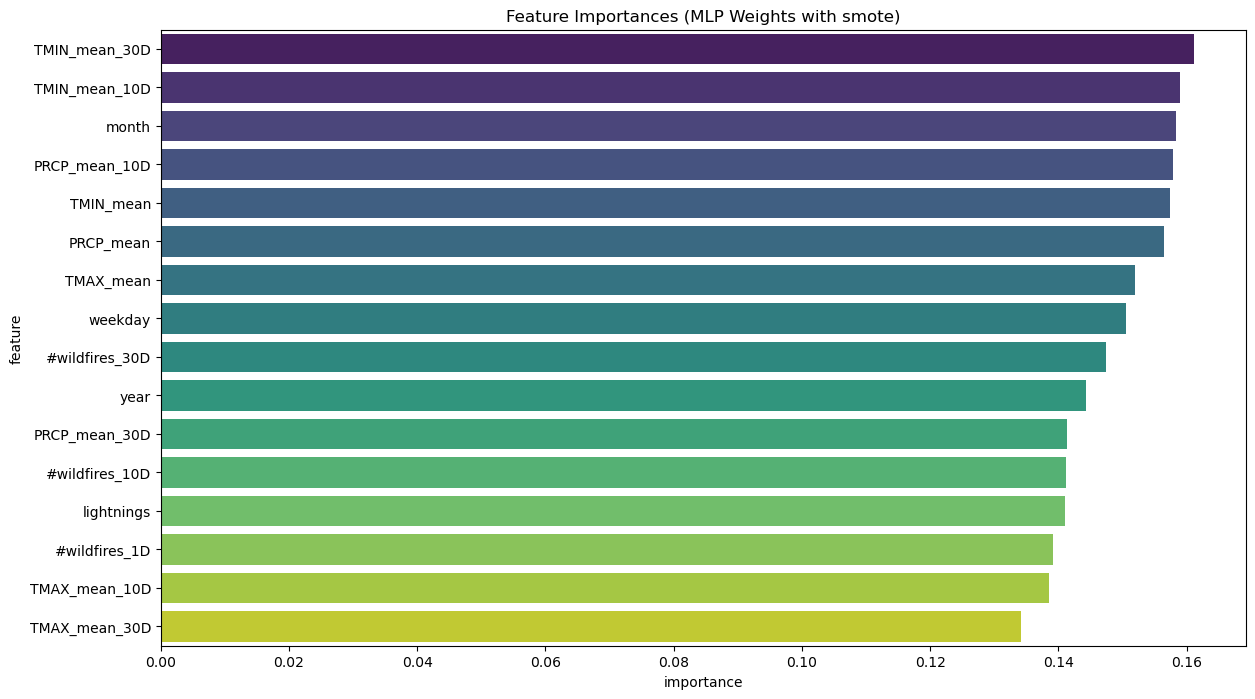


Processing San Bernardino National Forest

MLP Classifier with smote:
Accuracy_smote: 0.6944127708095781
              precision    recall  f1-score   support

           0       0.87      0.68      0.76      1266
           1       0.47      0.73      0.57       488

    accuracy                           0.69      1754
   macro avg       0.67      0.70      0.67      1754
weighted avg       0.76      0.69      0.71      1754



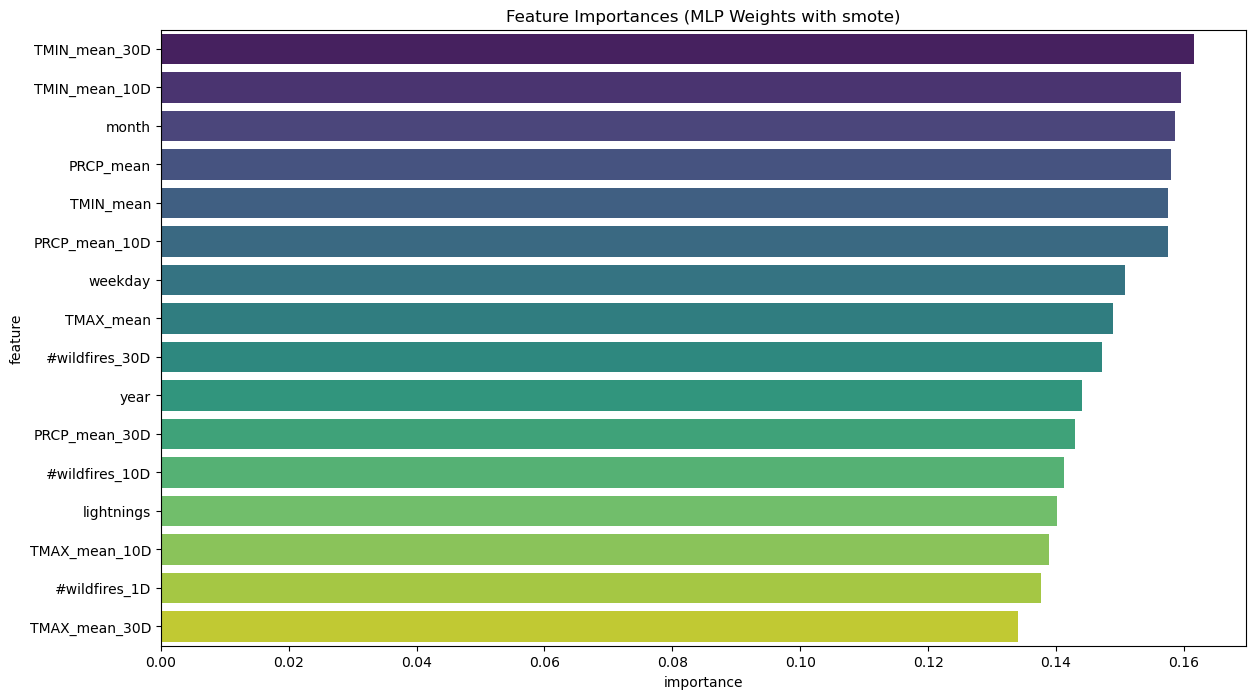


Processing Deschutes National Forest

MLP Classifier with smote:
Accuracy_smote: 0.7708095781071835
              precision    recall  f1-score   support

           0       0.92      0.76      0.83      1288
           1       0.55      0.81      0.65       466

    accuracy                           0.77      1754
   macro avg       0.73      0.78      0.74      1754
weighted avg       0.82      0.77      0.78      1754



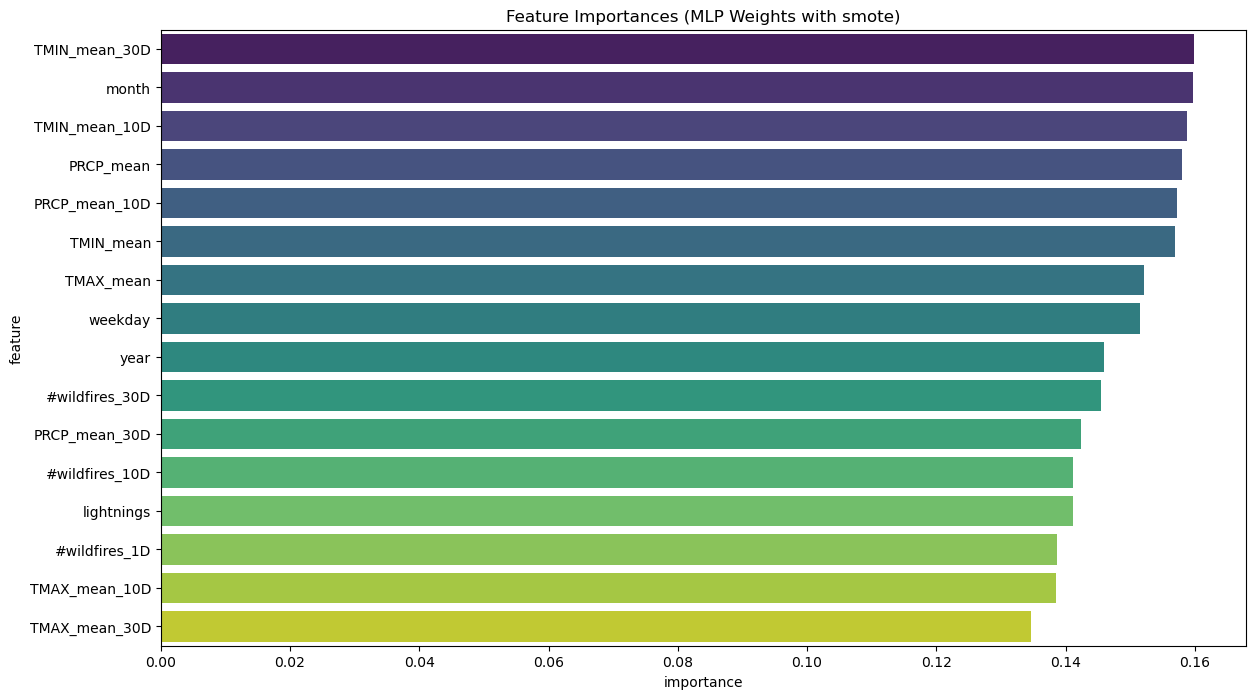


Processing Ouachita National Forest

MLP Classifier with smote:
Accuracy_smote: 0.734321550741163
              precision    recall  f1-score   support

           0       0.88      0.74      0.80      1277
           1       0.51      0.72      0.60       477

    accuracy                           0.73      1754
   macro avg       0.69      0.73      0.70      1754
weighted avg       0.78      0.73      0.75      1754



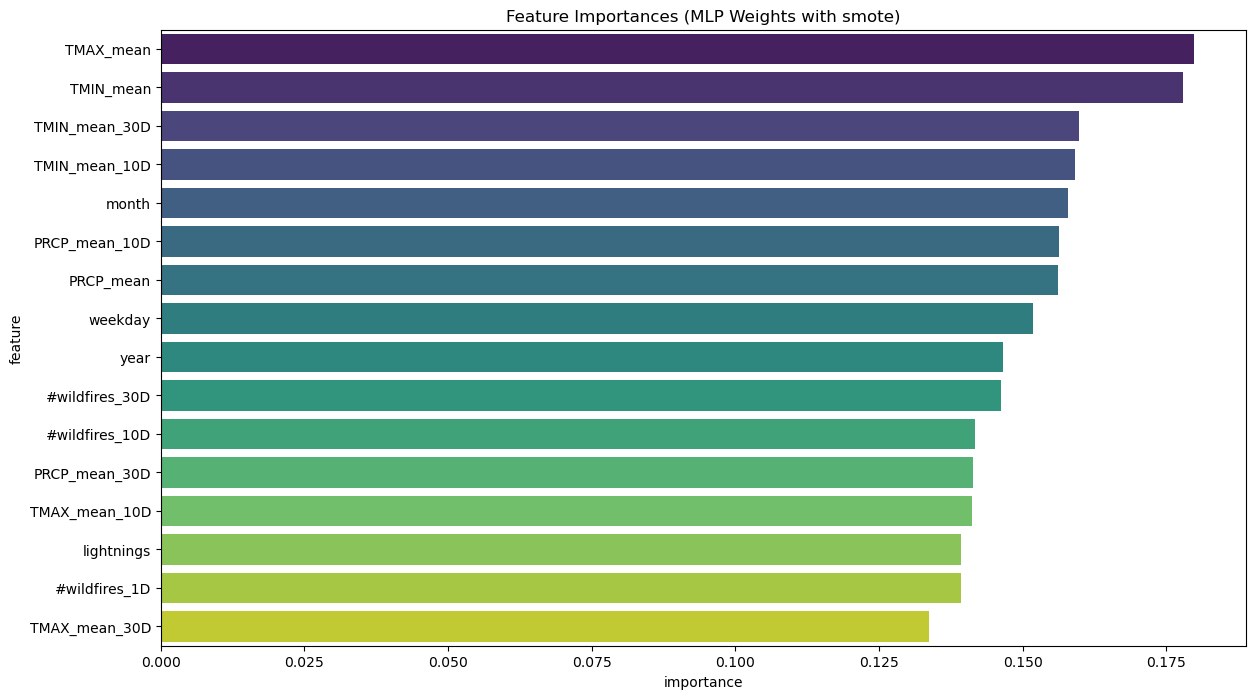


Processing Chattahoochee National Forest

MLP Classifier with smote:
Accuracy_smote: 0.7434285714285714
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1332
           1       0.48      0.75      0.58       418

    accuracy                           0.74      1750
   macro avg       0.69      0.75      0.70      1750
weighted avg       0.80      0.74      0.76      1750



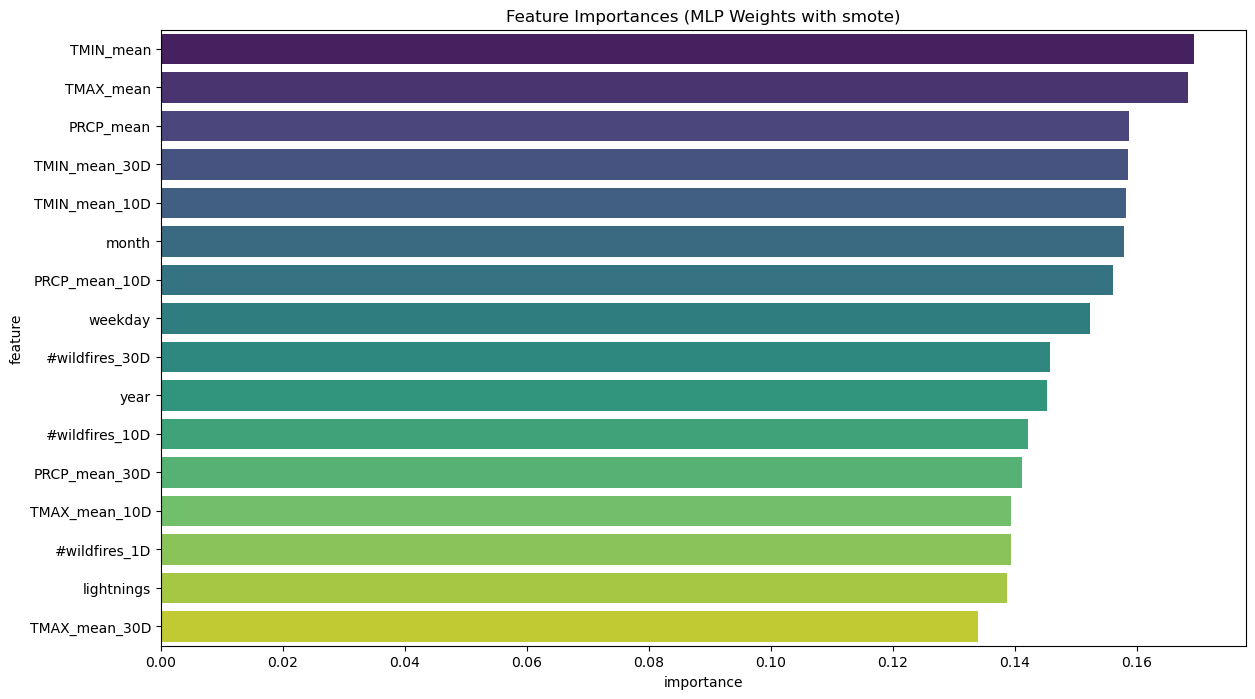


Processing Lolo National Forest

MLP Classifier with smote:
Accuracy_smote: 0.7873432155074116
              precision    recall  f1-score   support

           0       0.94      0.79      0.86      1434
           1       0.45      0.76      0.57       320

    accuracy                           0.79      1754
   macro avg       0.69      0.78      0.71      1754
weighted avg       0.85      0.79      0.81      1754



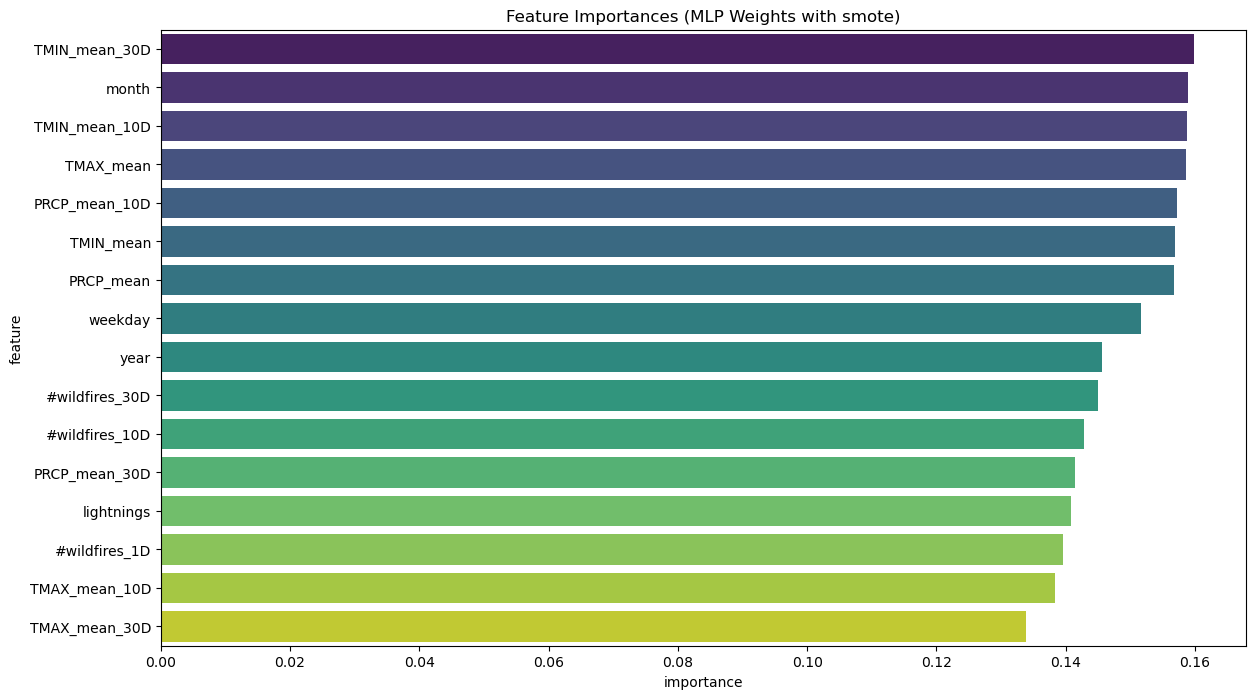


Processing De Soto National Forest

MLP Classifier with smote:
Accuracy_smote: 0.7307472903593839
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1353
           1       0.45      0.73      0.55       400

    accuracy                           0.73      1753
   macro avg       0.67      0.73      0.68      1753
weighted avg       0.80      0.73      0.75      1753



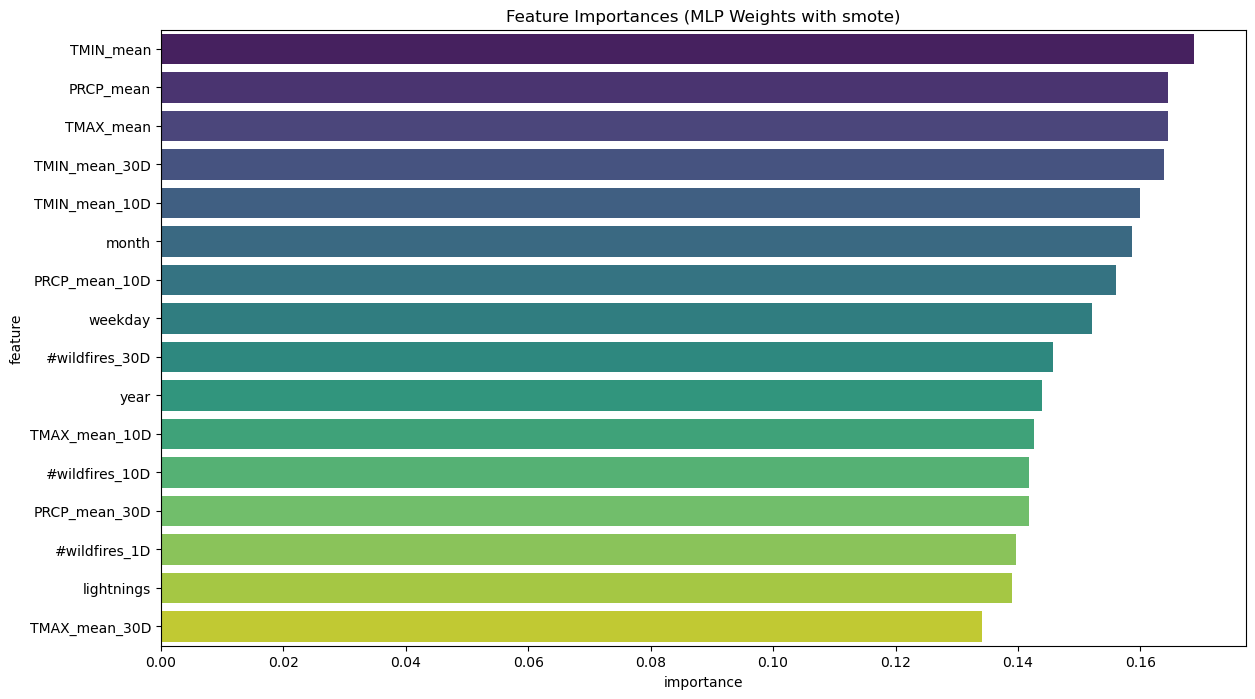

In [106]:
# Process each forest
for forest in forests:
    print(f"\nProcessing {forest}\n")
    forest_df = global_df[global_df['FORESTNAME'] == forest]
    forest_df = prepare_data(forest_df)
    process_and_train(forest_df)

## ***Support Vector Machine + SMOTE***

In [98]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE

# Function to process the data and train the models
def process_and_train(df):
    # Data preparation
    X = df.drop(['date', 'target', '#wildfires'], axis=1)
    y = df['target']

    # Set numeric and circular columns
    num_cols = ['TMAX_mean', 'TMIN_mean', 'TMAX_mean_10D', 'TMAX_mean_30D', 'TMIN_mean_10D', 'TMIN_mean_30D',
                'PRCP_mean', 'PRCP_mean_10D', 'PRCP_mean_30D', 'lightnings', '#wildfires_1D', '#wildfires_10D',
                '#wildfires_30D']
    circular_cols = ['month', 'weekday']

    # Impute missing values with median
    imputer = SimpleImputer(strategy='median')
    X[num_cols] = imputer.fit_transform(X[num_cols])

    # Shift the 'weekday' values so that Monday is represented by 1
    X['weekday'] = X['weekday'] + 1
           
    # Create sin and cos for circular columns
    X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
    X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
    X['weekday_sin'] = np.sin(2 * np.pi * X['weekday'] / 7)
    X['weekday_cos'] = np.cos(2 * np.pi * X['weekday'] / 7)

    # Drop original circular columns
    X = X.drop(columns=circular_cols)

    # Standardize the features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    # Train an SVM model
    model = SVC(kernel='rbf', gamma=0.0001, C=100)
    model.fit(X_train_smote, y_train_smote)
    y_pred_smote = model.predict(X_test)
    accuracy_smote = accuracy_score(y_test, y_pred_smote)

    # Print the accuracy and classification report for the model
    print("SVM with smote:")
    print("Accuracy_smote:", accuracy_smote)
    print(classification_report(y_test, y_pred_smote))

    # Calculate feature importances using permutation importance
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    importances = perm_importance.importances_mean
    feature_names = X_train.columns
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
    
    # Remove sin and cos columns from the feature importances
    feature_importances = feature_importances[~feature_importances['feature'].isin(['month_sin', 'month_cos', 'weekday_sin', 'weekday_cos'])]
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(14, 8))
    sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')
    plt.title('Feature Importances (SVM RBF Kernel with smote)')
    plt.show()



Processing Coconino National Forest

SVM with smote:
Accuracy_smote: 0.766248574686431
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      1107
           1       0.66      0.75      0.70       647

    accuracy                           0.77      1754
   macro avg       0.75      0.76      0.75      1754
weighted avg       0.77      0.77      0.77      1754



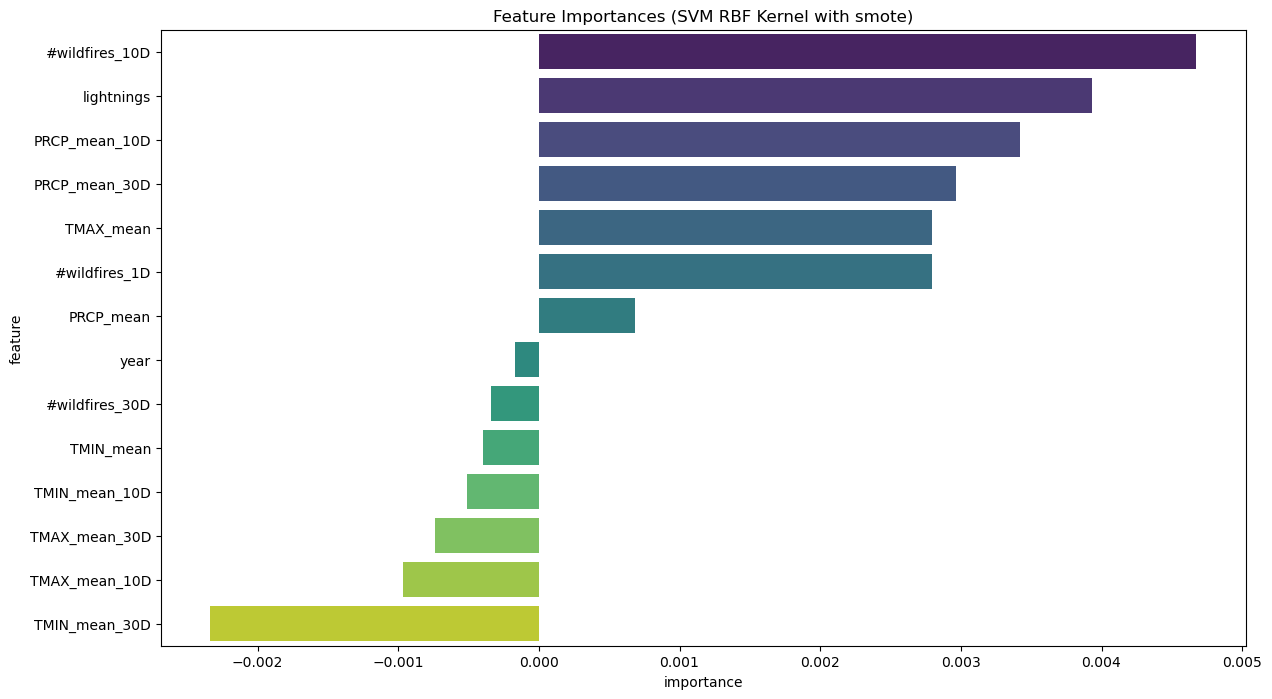


Processing Tonto National Forest

SVM with smote:
Accuracy_smote: 0.7320410490307868
              precision    recall  f1-score   support

           0       0.86      0.74      0.79      1215
           1       0.55      0.72      0.62       539

    accuracy                           0.73      1754
   macro avg       0.70      0.73      0.71      1754
weighted avg       0.76      0.73      0.74      1754



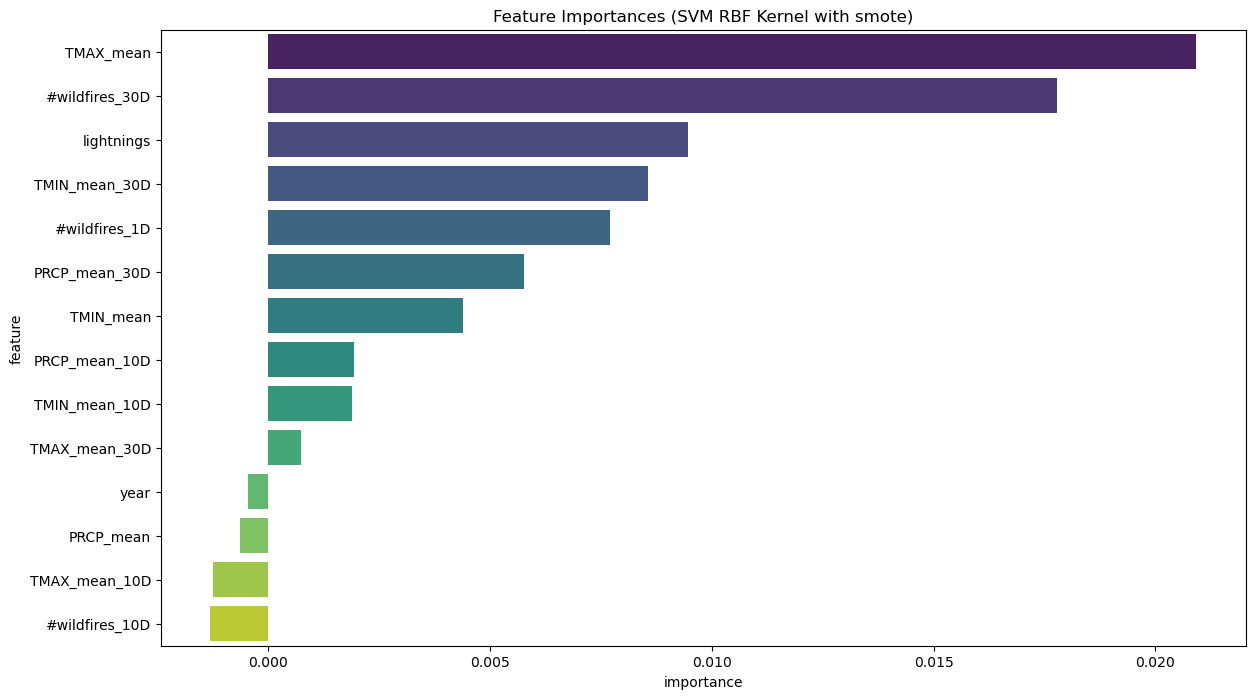


Processing San Bernardino National Forest

SVM with smote:
Accuracy_smote: 0.6761687571265679
              precision    recall  f1-score   support

           0       0.86      0.65      0.74      1266
           1       0.45      0.73      0.56       488

    accuracy                           0.68      1754
   macro avg       0.66      0.69      0.65      1754
weighted avg       0.75      0.68      0.69      1754



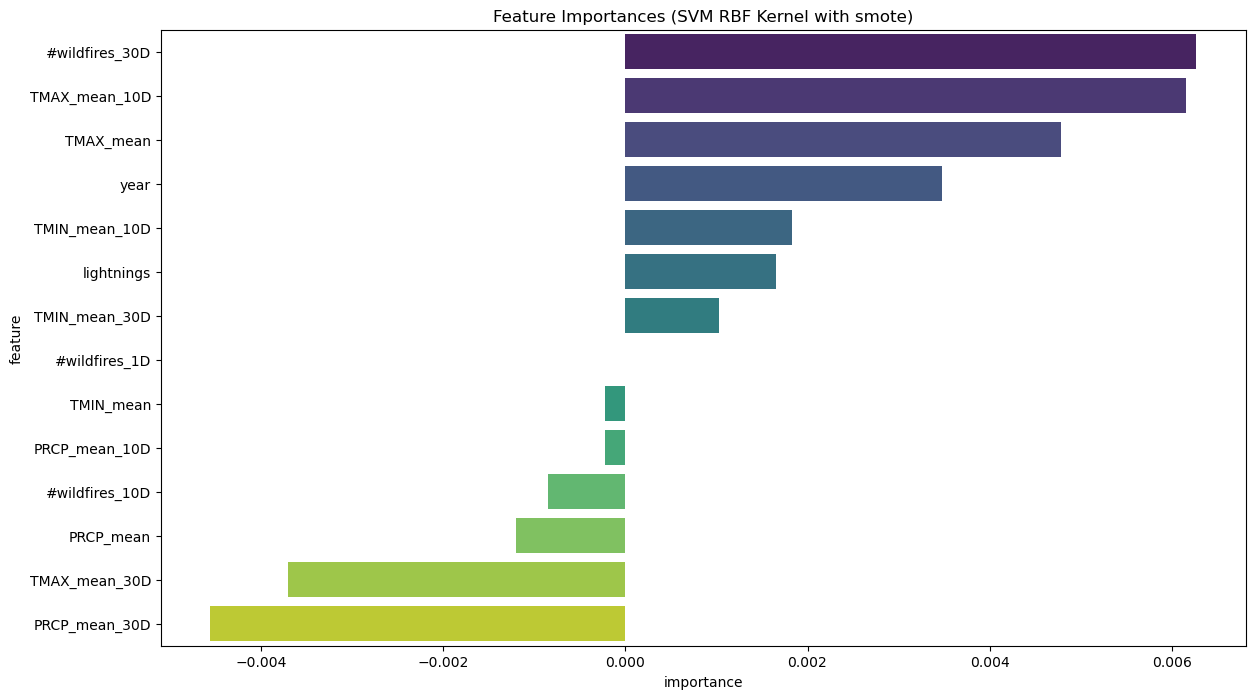


Processing Deschutes National Forest

SVM with smote:
Accuracy_smote: 0.75769669327252
              precision    recall  f1-score   support

           0       0.92      0.73      0.82      1288
           1       0.53      0.83      0.65       466

    accuracy                           0.76      1754
   macro avg       0.73      0.78      0.73      1754
weighted avg       0.82      0.76      0.77      1754



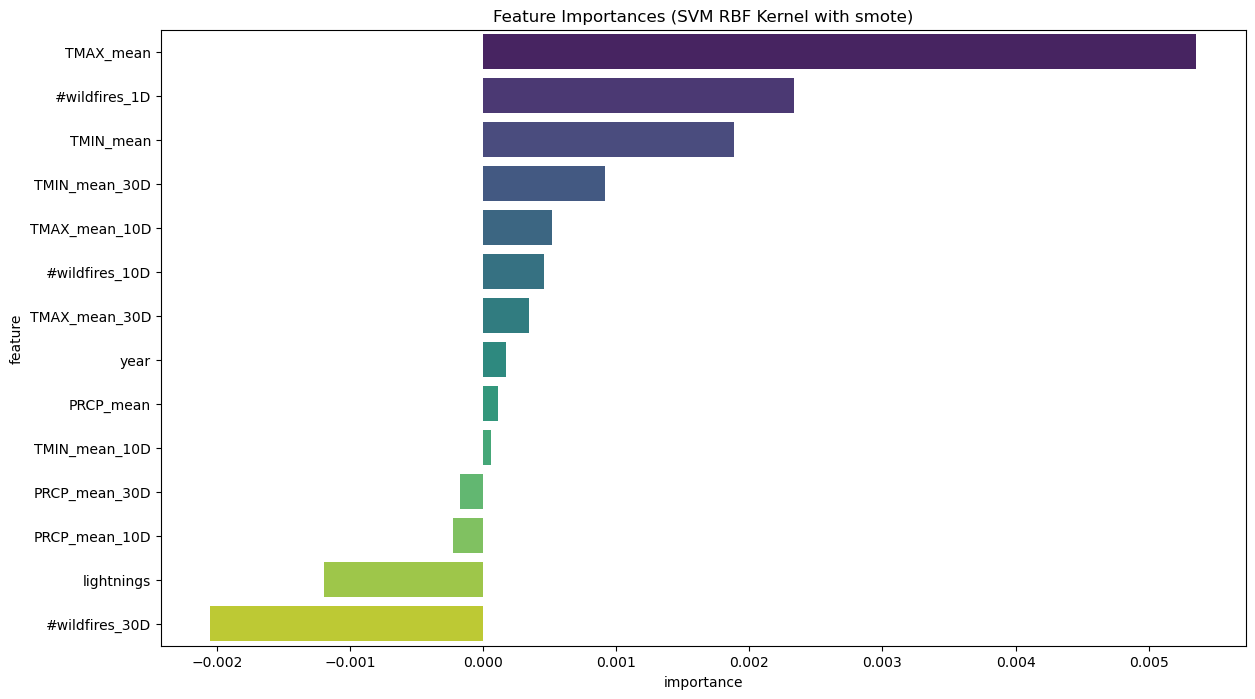


Processing Ouachita National Forest

SVM with smote:
Accuracy_smote: 0.7246294184720639
              precision    recall  f1-score   support

           0       0.87      0.73      0.79      1277
           1       0.50      0.72      0.59       477

    accuracy                           0.72      1754
   macro avg       0.68      0.72      0.69      1754
weighted avg       0.77      0.72      0.74      1754



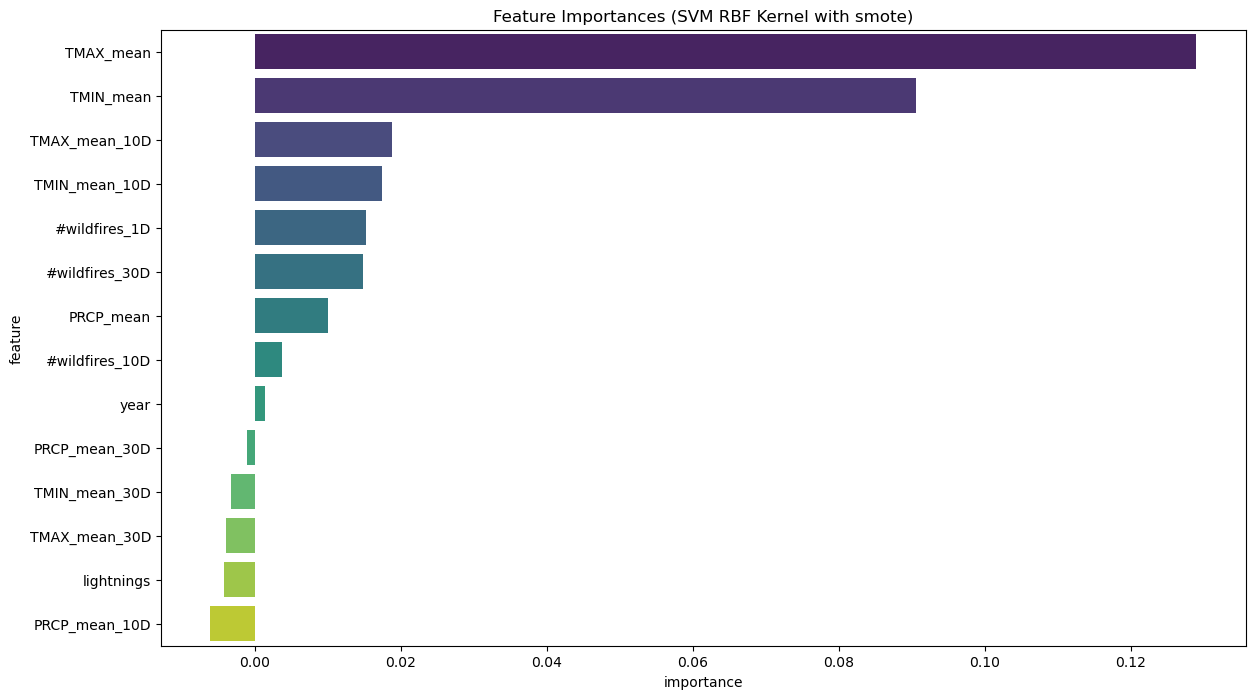


Processing Chattahoochee National Forest

SVM with smote:
Accuracy_smote: 0.7394285714285714
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1332
           1       0.47      0.75      0.58       418

    accuracy                           0.74      1750
   macro avg       0.69      0.74      0.69      1750
weighted avg       0.80      0.74      0.76      1750



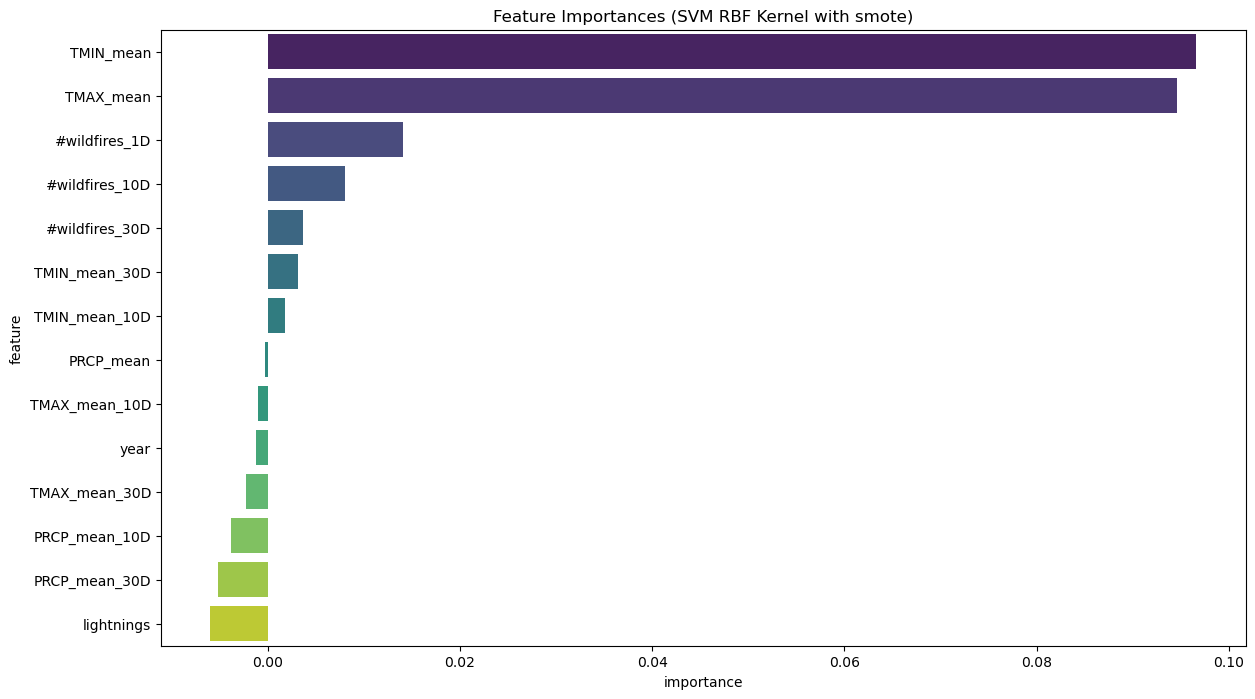


Processing Lolo National Forest

SVM with smote:
Accuracy_smote: 0.7787913340935005
              precision    recall  f1-score   support

           0       0.94      0.78      0.85      1434
           1       0.44      0.77      0.56       320

    accuracy                           0.78      1754
   macro avg       0.69      0.77      0.71      1754
weighted avg       0.85      0.78      0.80      1754



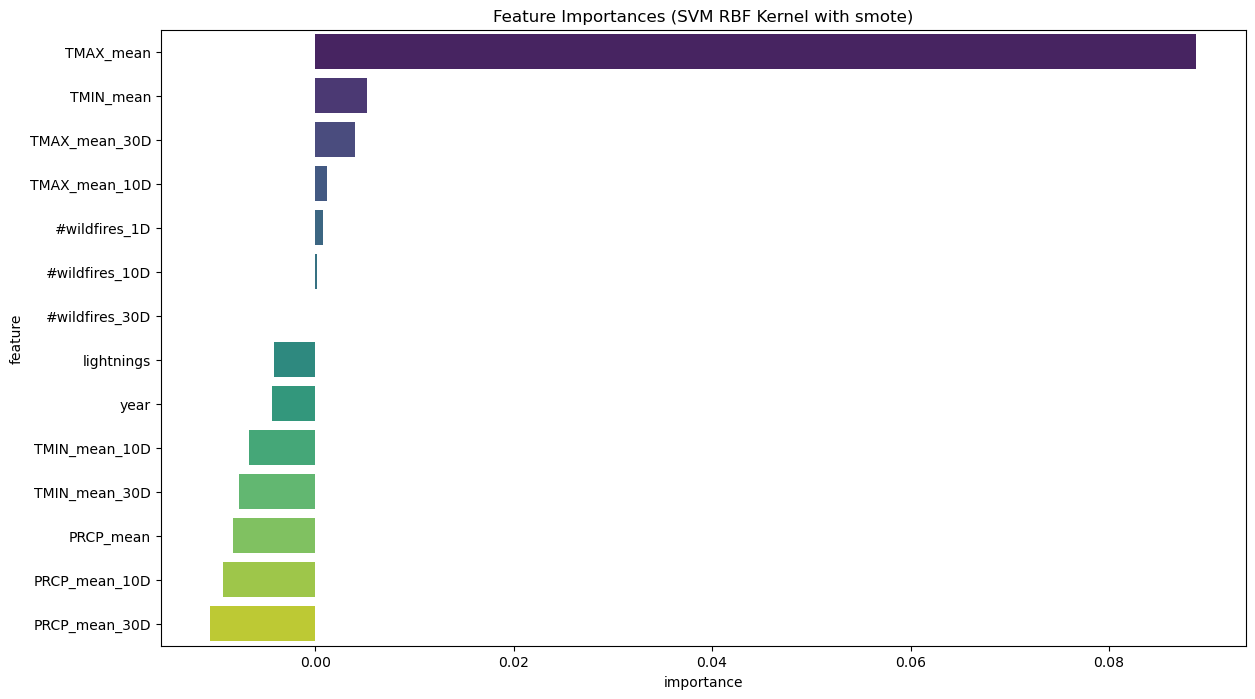


Processing De Soto National Forest

SVM with smote:
Accuracy_smote: 0.7221905305191101
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1353
           1       0.44      0.75      0.55       400

    accuracy                           0.72      1753
   macro avg       0.67      0.73      0.67      1753
weighted avg       0.80      0.72      0.74      1753



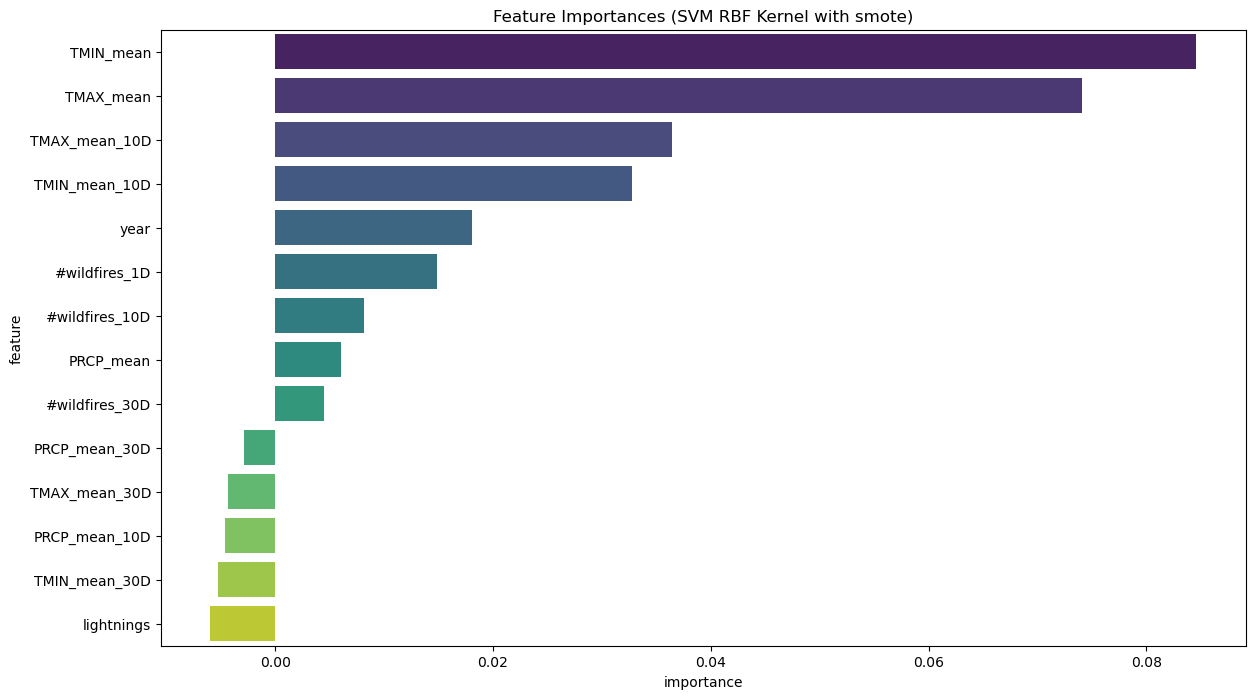

In [99]:
# Process each forest
for forest in forests:
    print(f"\nProcessing {forest}\n")
    forest_df = global_df[global_df['FORESTNAME'] == forest]
    forest_df = prepare_data(forest_df)
    process_and_train(forest_df)

## ***Gradient Boosting Classifier + SMOTE***

In [103]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Function to process the data and train the models
def process_and_train(df):
    # Data preparation
    X = df.drop(['date', 'target', '#wildfires'], axis=1)
    y = df['target']

    # Set numeric and circular columns
    num_cols = ['TMAX_mean', 'TMIN_mean', 'TMAX_mean_10D', 'TMAX_mean_30D', 'TMIN_mean_10D', 'TMIN_mean_30D',
                'PRCP_mean', 'PRCP_mean_10D', 'PRCP_mean_30D', 'lightnings', '#wildfires_1D', '#wildfires_10D',
                '#wildfires_30D']
    circular_cols = ['month', 'weekday']

    # Impute missing values with median
    imputer = SimpleImputer(strategy='median')
    X[num_cols] = imputer.fit_transform(X[num_cols])

    # Shift the 'weekday' values so that Monday is represented by 1
    X['weekday'] = X['weekday'] + 1

    # Create sin and cos for circular columns
    X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
    X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
    X['weekday_sin'] = np.sin(2 * np.pi * X['weekday'] / 7)
    X['weekday_cos'] = np.cos(2 * np.pi * X['weekday'] / 7)

    # Drop original circular columns
    #X = X.drop(columns=circular_cols)

    # Standardize the features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    # Train a Gradient Boosting Classifier
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train_smote, y_train_smote)
    y_pred_smote = model.predict(X_test)
    accuracy_smote = accuracy_score(y_test, y_pred_smote)

    # Evaluate the model performance
    print("Gradient Boosting Classifier with smote:")
    print("Accuracy_smote:", accuracy_smote)
    print(classification_report(y_test, y_pred_smote))

    # Plot feature importances
    importances = model.feature_importances_
    feature_names = X_train_smote.columns
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
    
    # Remove sin and cos columns from the feature importances
    feature_importances = feature_importances[~feature_importances['feature'].isin(['month_sin', 'month_cos', 'weekday_sin', 'weekday_cos'])]
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(14, 8))
    sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')
    plt.title('Feature Importances (Gradient Boosting with smote)')
    plt.show()



Processing Coconino National Forest

Gradient Boosting Classifier with smote:
Accuracy_smote: 0.7776510832383124
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1107
           1       0.68      0.74      0.71       647

    accuracy                           0.78      1754
   macro avg       0.76      0.77      0.76      1754
weighted avg       0.78      0.78      0.78      1754



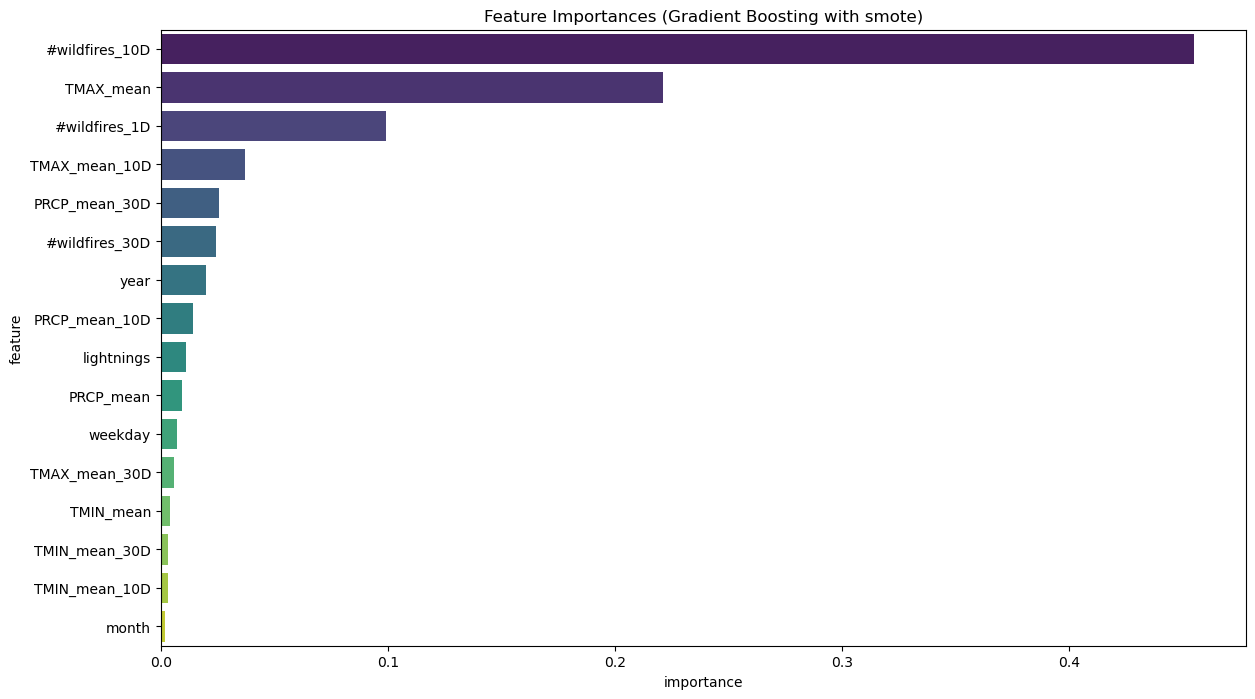


Processing Tonto National Forest

Gradient Boosting Classifier with smote:
Accuracy_smote: 0.7519954389965793
              precision    recall  f1-score   support

           0       0.83      0.80      0.82      1215
           1       0.59      0.63      0.61       539

    accuracy                           0.75      1754
   macro avg       0.71      0.72      0.71      1754
weighted avg       0.76      0.75      0.75      1754



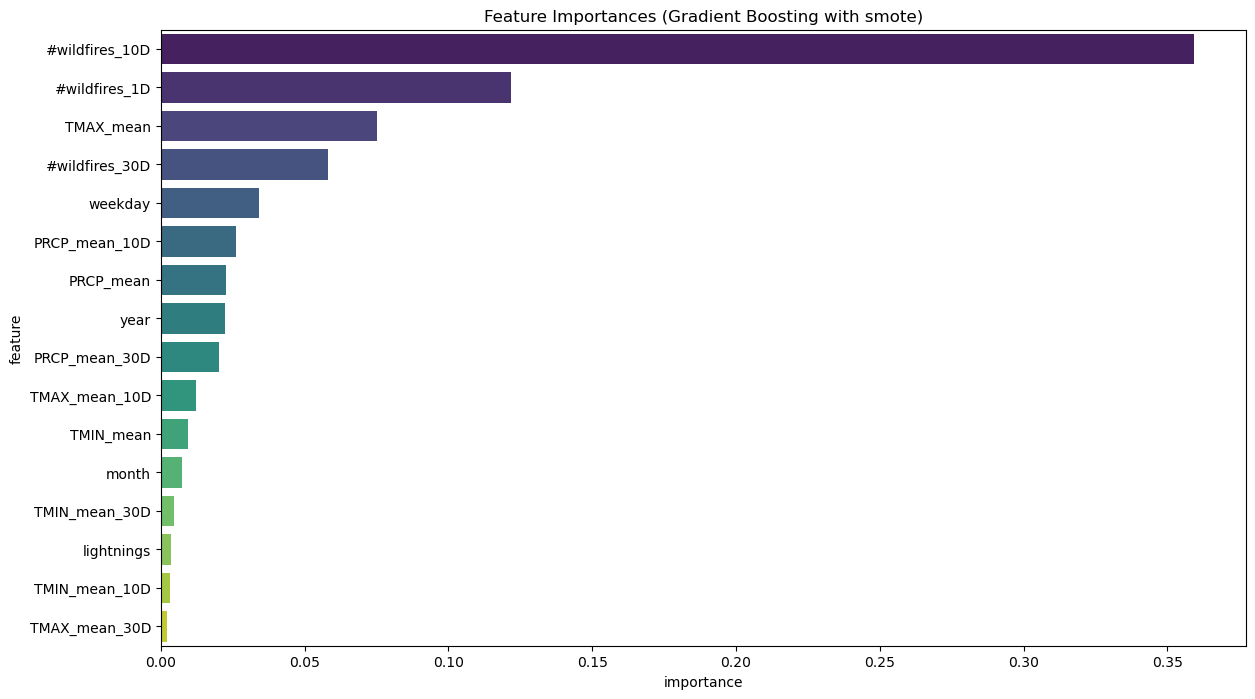


Processing San Bernardino National Forest

Gradient Boosting Classifier with smote:
Accuracy_smote: 0.7234891676168758
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1266
           1       0.50      0.59      0.54       488

    accuracy                           0.72      1754
   macro avg       0.67      0.68      0.67      1754
weighted avg       0.74      0.72      0.73      1754



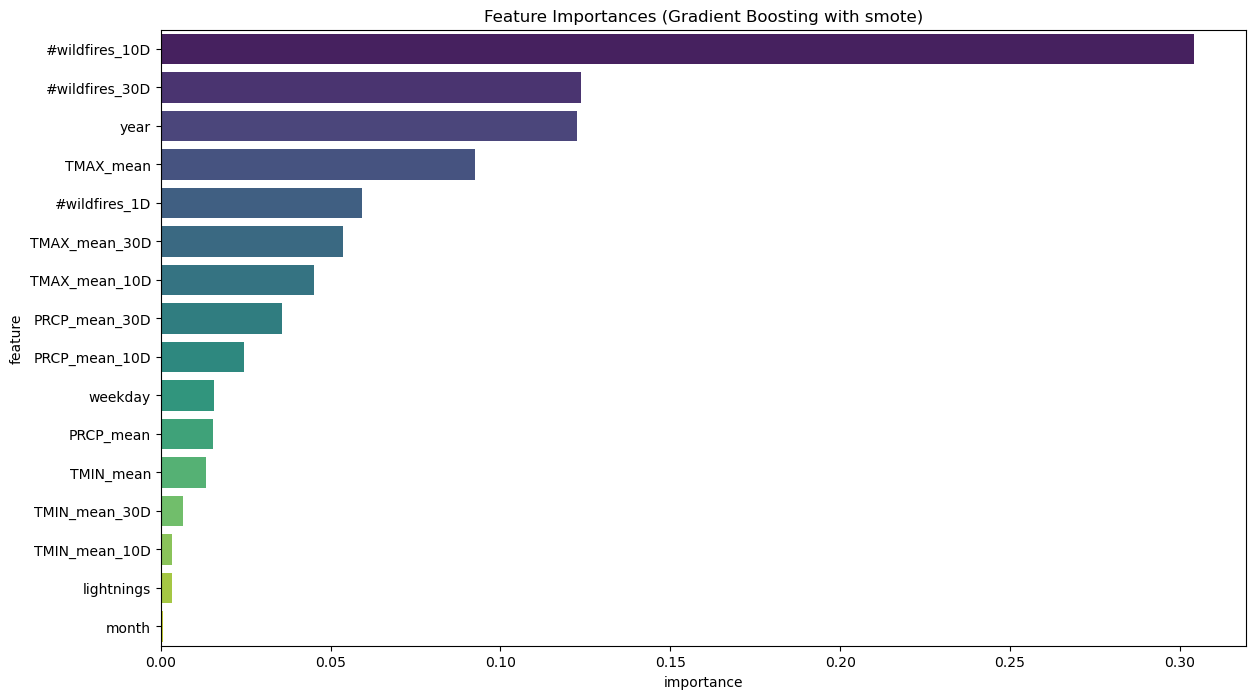


Processing Deschutes National Forest

Gradient Boosting Classifier with smote:
Accuracy_smote: 0.7970353477765109
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      1288
           1       0.59      0.76      0.67       466

    accuracy                           0.80      1754
   macro avg       0.75      0.79      0.76      1754
weighted avg       0.82      0.80      0.80      1754



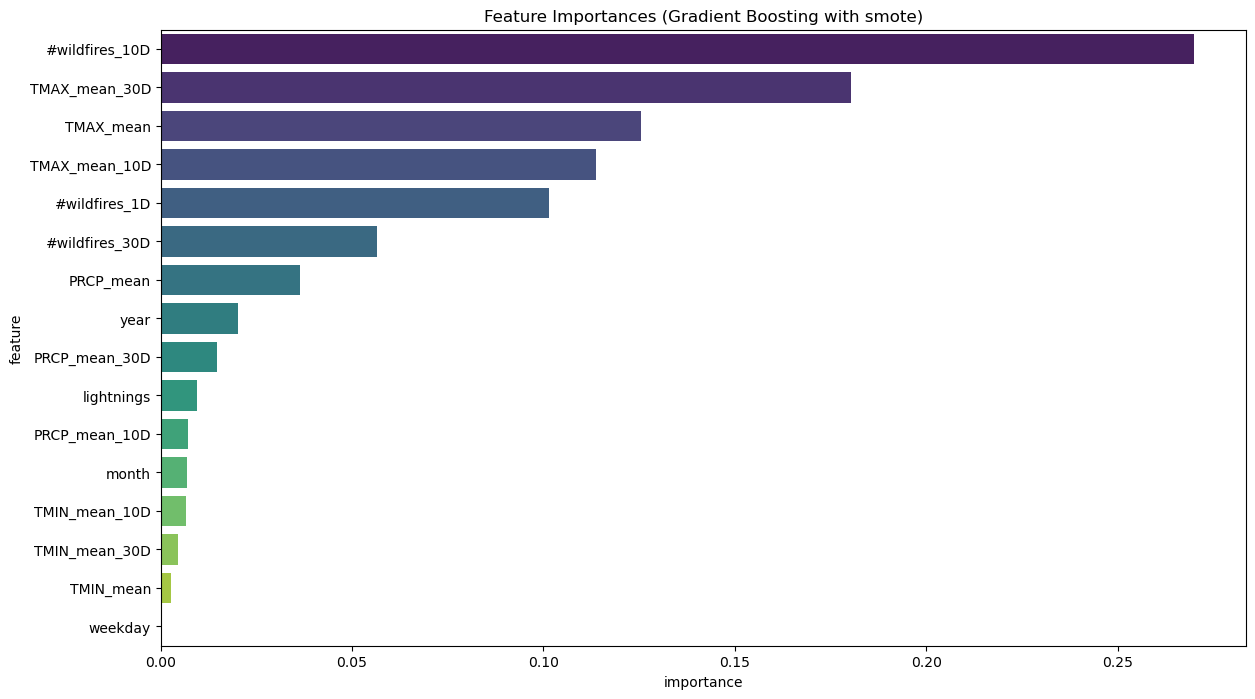


Processing Ouachita National Forest

Gradient Boosting Classifier with smote:
Accuracy_smote: 0.7690992018244014
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1277
           1       0.57      0.62      0.59       477

    accuracy                           0.77      1754
   macro avg       0.71      0.72      0.72      1754
weighted avg       0.78      0.77      0.77      1754



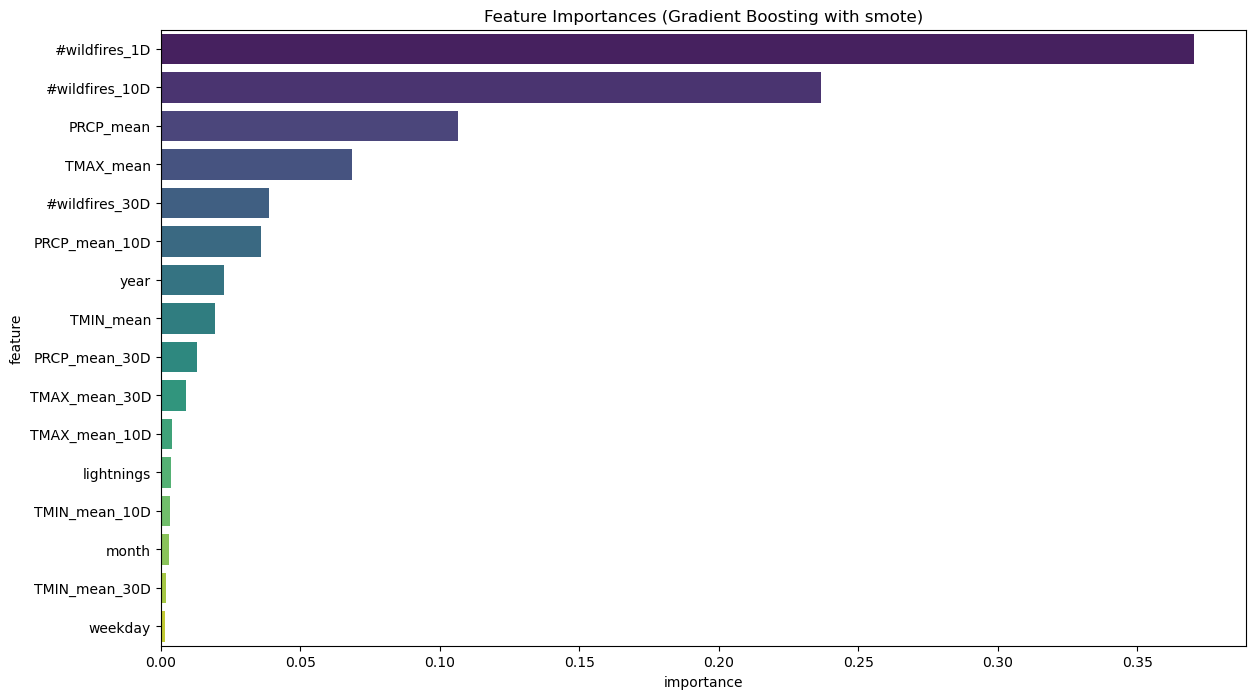


Processing Chattahoochee National Forest

Gradient Boosting Classifier with smote:
Accuracy_smote: 0.8074285714285714
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      1332
           1       0.59      0.61      0.60       418

    accuracy                           0.81      1750
   macro avg       0.74      0.74      0.74      1750
weighted avg       0.81      0.81      0.81      1750



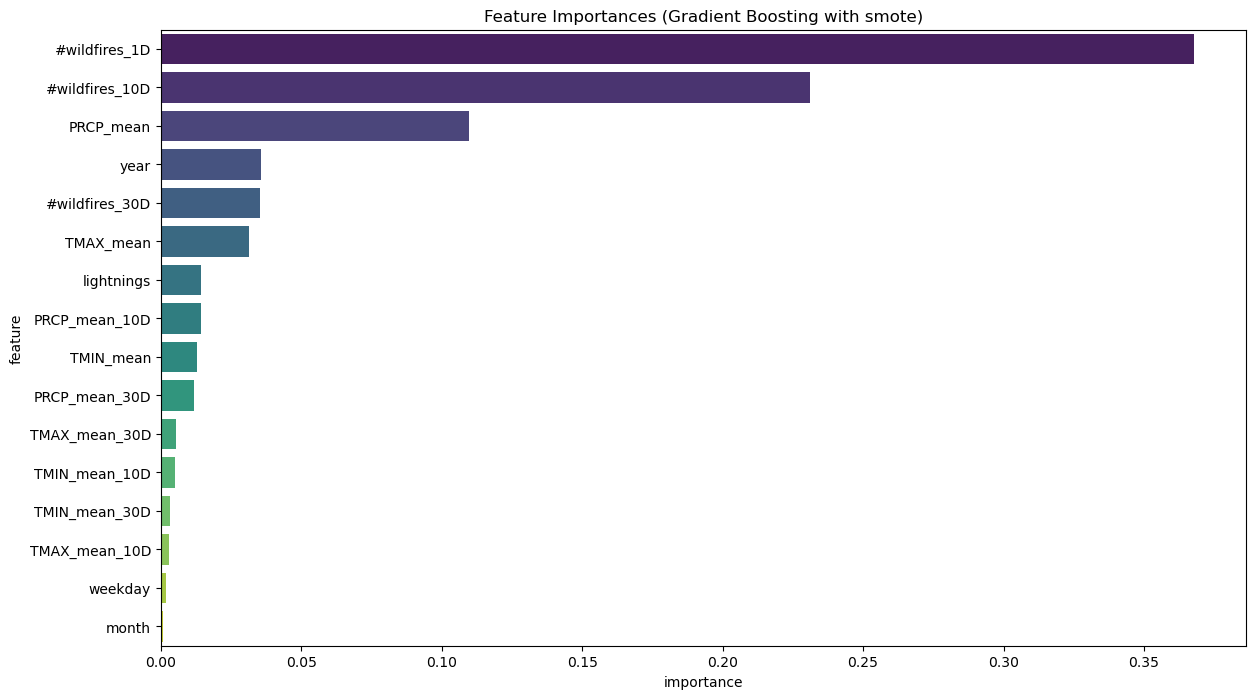


Processing Lolo National Forest

Gradient Boosting Classifier with smote:
Accuracy_smote: 0.8437856328392246
              precision    recall  f1-score   support

           0       0.92      0.89      0.90      1434
           1       0.56      0.64      0.60       320

    accuracy                           0.84      1754
   macro avg       0.74      0.76      0.75      1754
weighted avg       0.85      0.84      0.85      1754



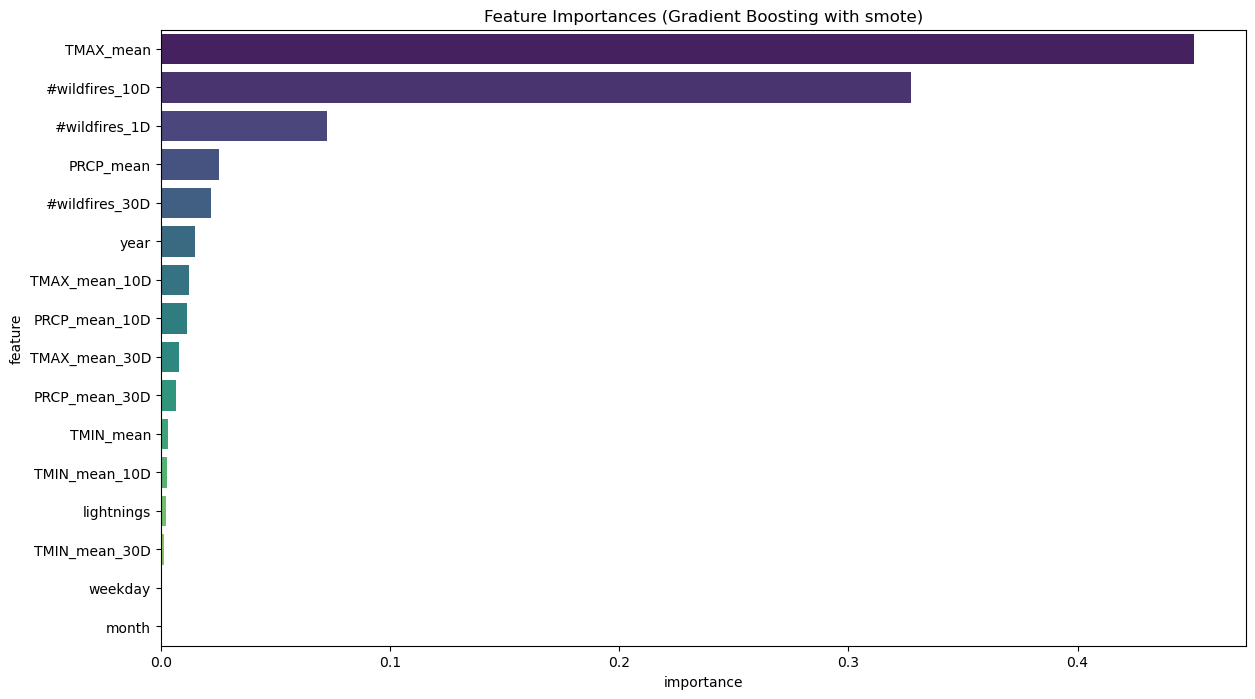


Processing De Soto National Forest

Gradient Boosting Classifier with smote:
Accuracy_smote: 0.7837992013690815
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1353
           1       0.52      0.60      0.56       400

    accuracy                           0.78      1753
   macro avg       0.70      0.72      0.71      1753
weighted avg       0.80      0.78      0.79      1753



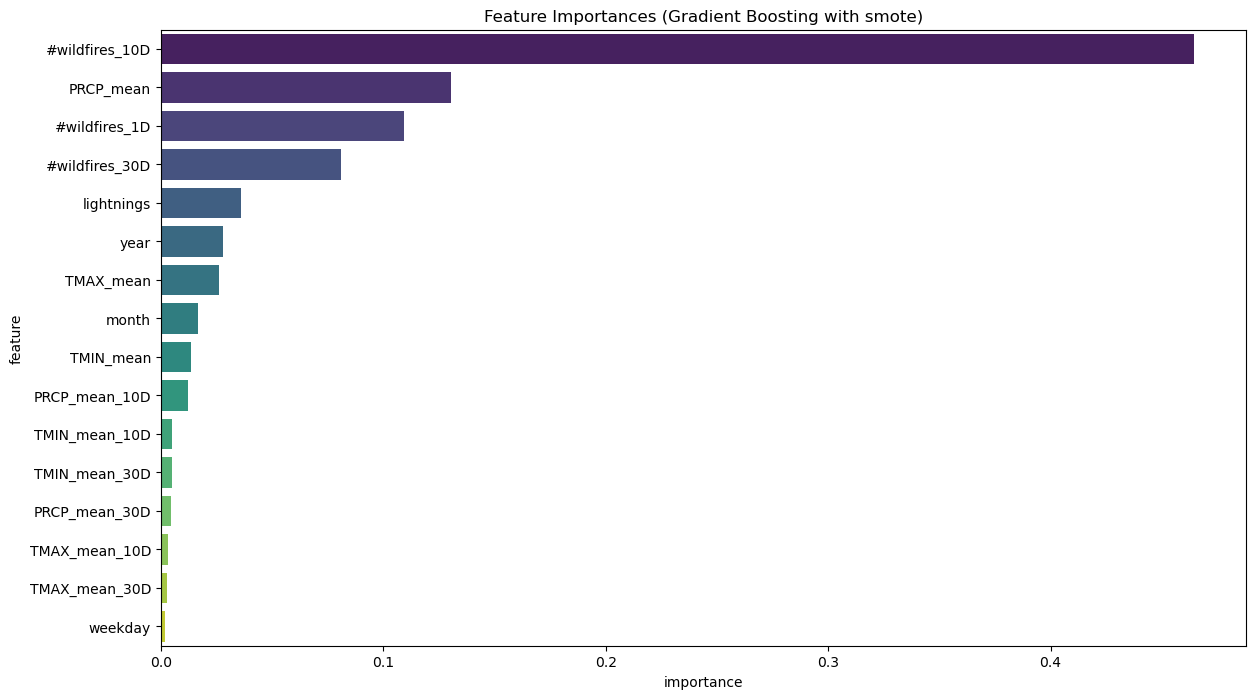

In [104]:
# Process each forest
for forest in forests:
    print(f"\nProcessing {forest}\n")
    forest_df = global_df[global_df['FORESTNAME'] == forest]
    forest_df = prepare_data(forest_df)
    process_and_train(forest_df)